In [1]:
debug = True

In [2]:
on_drive = False

In [3]:
if on_drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Importing modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import copy
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import VotingClassifier
from sklearn import metrics

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Preparing data

## Loading expression data

In [5]:
# load expression data

if(on_drive):
    f = open("/content/drive/MyDrive/Laura Speggiorin - TCC/GSE123302_series_matrix.txt/GSE123302_series_matrix.txt", "r")
else:
    f = open("./GSE123302_series_matrix.txt", "r")


tmp = f.readlines()

f.close()

# select relevant parts (as strings)
header_str = tmp[69]
class_str = tmp[42]
matrix_str = tmp[70:-1]

In [6]:
# make list of instance ID's

header = header_str.replace("\"", "")
header = header.replace("\n", "")
header = header.replace("ID_REF\t", "")

header = header.split("\t")

#header
#['GSM3499537',
# 'GSM3499538',
# 'GSM3499539',
# ...
# 'GSM3499758',
# 'GSM3499759',
# 'GSM3499760']

In [7]:
# make list of diagnosis class ('ASD', 'Non-TD', 'TD')

classes = class_str.replace("\"", "")
classes = classes.replace("\n", "")
classes = classes.replace("!Sample_characteristics_ch1\t", "")
classes = classes.replace("diagnosis: ", "")

classes = classes.split("\t")

#classes
# ['ASD',
# 'ASD',
# 'ASD',
# ...
# 'Non-TD',
# 'Non-TD',
# 'Non-TD',
# ...
# 'TD',
# 'TD',
# 'TD']

In [8]:
("TD instances: " + str(len([y for y in classes if y=='TD'])),
"Non-TD instances: " + str(len([y for y in classes if y=='Non-TD'])),
"ASD instances: " + str(len([y for y in classes if y=='ASD'])))

('TD instances: 91', 'Non-TD instances: 80', 'ASD instances: 53')

In [9]:
# make dataframe out of expression matrix

matrix_str = [matrix_str[i].replace("\n", "") for i in range(len(matrix_str))]

header.insert(0,"ID")
df = []
string = ""
for i in range(len(matrix_str)):
    string = matrix_str[i]
    df.append(string.split("\t"))

df = pd.DataFrame(df)
df.columns = header
df.set_index('ID', inplace=True)

df.head()

,GSM3499537,GSM3499538,GSM3499539,GSM3499540,GSM3499541,GSM3499542,GSM3499543,GSM3499544,GSM3499545,GSM3499546,...,GSM3499751,GSM3499752,GSM3499753,GSM3499754,GSM3499755,GSM3499756,GSM3499757,GSM3499758,GSM3499759,GSM3499760
ID,,,,,,,,,,,,,,,,,,,,,
16657436,6.59413,7.87068,8.24341,8.82145,7.28308,7.20000,9.23493,7.20748,7.42416,7.64885,...,7.89938,7.05351,6.51581,7.79333,8.15164,7.57387,7.53656,7.70415,7.49588,7.01858
16657440,5.93156,5.69836,5.51954,5.28161,5.78602,5.48469,5.81990,6.45421,5.99021,5.89918,...,5.89504,5.49660,4.94837,5.33726,5.31676,5.20505,5.13099,5.44787,5.49887,5.28380
16657445,3.15314,2.83453,3.95568,3.44626,3.32776,3.41798,2.64097,2.97989,3.29357,3.04085,...,3.37387,3.39238,2.42227,3.20146,2.70834,2.77802,2.93332,2.72043,2.45639,2.74394
16657447,3.65784,2.08780,2.41832,2.53530,4.08640,2.70086,2.23447,2.27813,2.21519,3.25745,...,2.62774,2.77415,2.07024,2.66232,2.26471,2.23681,2.42367,2.34175,2.62971,2.54580
16657450,11.64852,11.21240,11.29504,11.51345,11.52633,11.47545,11.52348,11.55696,11.58122,11.55579,...,10.73590,10.72824,10.30400,10.47405,10.01123,10.54521,10.68286,10.85129,10.71401,10.51731


In [10]:
df_t = df.transpose()

df_t = df_t.astype('float')

df_t.head()

ID,16657436,16657440,16657445,16657447,16657450,16657469,16657473,16657476,16657489,16657492,...,17118432,17118434,17118436,17118438,17118440,17118442,17118444,17118446,17118451,17118478
GSM3499537,6.59413,5.93156,3.15314,3.65784,11.64852,9.18746,4.59582,6.50885,5.50111,4.76784,...,6.36994,5.18167,6.14821,5.98637,3.89763,1.95365,3.45978,2.80000,3.44546,5.01391
GSM3499538,7.87068,5.69836,2.83453,2.08780,11.21240,8.69769,3.90464,6.17625,5.54039,4.40995,...,6.38951,4.71130,5.74481,6.17986,4.39488,2.34992,3.46852,3.49701,3.32475,5.10275
GSM3499539,8.24341,5.51954,3.95568,2.41832,11.29504,8.52116,3.85387,6.26045,4.82621,5.19215,...,6.06655,4.88073,5.45233,5.95467,4.39322,2.10524,3.83358,2.79608,3.43109,4.52188
GSM3499540,8.82145,5.28161,3.44626,2.53530,11.51345,8.72665,4.05922,5.95970,5.52619,4.58389,...,6.42090,5.08474,5.62217,5.78808,4.22873,2.07298,3.14549,2.75074,3.65670,5.14589
GSM3499541,7.28308,5.78602,3.32776,4.08640,11.52633,8.69042,4.29833,6.47306,4.79904,4.92781,...,6.17093,5.61961,5.27742,5.94552,3.71425,2.13377,3.38367,3.52271,3.40723,4.72626


## Filtering data

### Loading platform data

In [11]:
# load platform data

if(on_drive):
    f = open("/content/drive/MyDrive/Laura Speggiorin - TCC/GSE123302_family.soft", "r")
else:
    f = open("./GSE123302_family.soft", "r")

tmp = f.readlines()

f.close()

# select relevant parts (as strings)
platform_table_str = tmp[309:54291]

In [12]:
# make dataframe out of platform matrix
platform_table = []
line = ""
for i in range(len(platform_table_str)):
    line = platform_table_str[i]
    platform_table.append(line.split("\t"))

platform_table = pd.DataFrame(platform_table)

platform_table.columns = platform_table.iloc[0]
platform_table = platform_table[1:]

platform_table.head()

,ID,RANGE_STRAND,RANGE_START,RANGE_END,total_probes,GB_ACC,SPOT_ID,RANGE_GB\n
1,16657436,+,12190,13639,25,NR_046018,chr1:12190-13639,NC_000001.10\n
2,16657440,+,29554,31109,28,,chr1:29554-31109,NC_000001.10\n
3,16657445,+,69091,70008,8,,chr1:69091-70008,NC_000001.10\n
4,16657447,+,160446,161525,13,,chr1:160446-161525,NC_000001.10\n
5,16657450,+,317811,328581,36,NR_024368,chr1:317811-328581,NC_000001.10\n


In [13]:
platform_table.shape

(53981, 8)

### Dataframe feature filtering

In [14]:
#contagem de sondas com o prefixo NM_xxxxxx
platform_table['GB_ACC'].str.startswith('NM').value_counts()

GB_ACC
False    40731
True     13250
Name: count, dtype: int64

In [15]:
#selecionar IDs das sondas com prefixo 'NM' na coluna 'GB_ACC'

filtered_list = platform_table[platform_table['GB_ACC'].str.startswith('NM')]

filtered_list = list(filtered_list['ID'])

filtered_df = df_t.loc[:,[sonda for sonda in df_t.columns.tolist() if sonda in filtered_list]]
filtered_df.shape

(224, 12896)

In [16]:
top_t_genes = 5000 #@param {type:"integer"}

In [17]:
#filtrar por variancia (manter top 5000 atributos que mais variam)

variance = filtered_df.var(axis=0)
filtered_varlist = variance.rank().sort_values(ascending=False)

filtered_varlist = list(filtered_varlist[0:top_t_genes].index)

filtered_df = filtered_df.loc[:,[sonda for sonda in df_t.columns.tolist() if sonda in filtered_varlist]]
filtered_df.shape

(224, 5000)

# Pre-processing data

In [18]:
#separar em desenvolvimento tipico e atipico
#0 == desenvolvimento typico, 1 == desenvolvimento atipico
def is_TD(class_list):
    isTD = np.array([0 if y=='TD' else 1 for y in class_list])

    if(debug):
        print("Number Non-Tipical Development: " + str(len(isTD[isTD == 1])))
        print("Number Tipical Development: " + str(len(isTD[isTD == 0])))

    return isTD

#separar em nao-ASD e ASD
#0 == não TEA, 1 == TEA
def is_ASD(class_list):
    isASD = np.array([1 if y=='ASD' else 0 for y in class_list])

    if(debug):
        print("Number ASD Development: " + str((len(isASD[isASD == 1]))))

    return isASD

#dentro de desenvolvimento não-típico 0 == não TEA, 1 == TEA
def NonTD_isASD(df):
    # dataframe de desenvolvimento não-típico
    NonTD_df = df[is_TD(df["Class"]) == 1]

    NonTD_isASD = np.array([1 if y=='ASD' else 0 for y in NonTD_df["Class"]])

    if(debug):
        print("Number other non-TD Development: " + str((len(NonTD_isASD[NonTD_isASD == 0]))))

    return NonTD_isASD


In [19]:
#holdout 80/20

X_train, X_test, y_train, y_test = train_test_split(filtered_df, classes, test_size=0.2, random_state=3, stratify=classes)

In [20]:
pd.Series(y_train).value_counts()

TD        73
Non-TD    64
ASD       42
Name: count, dtype: int64

In [21]:
print(pd.Series(y_test).value_counts())

TD        18
Non-TD    16
ASD       11
Name: count, dtype: int64


In [22]:
#nro de folds
K = 5 #@param {type:"integer"}

In [23]:
#separar dataframe de treino em k folds para k fold cross validation
kfold = StratifiedKFold(n_splits=K, random_state=3, shuffle=True)

# Models

### GridSearch parameters and pipelines

In [24]:
param_dict = {}
pipeline_dict = {}

In [25]:
#knn
pipeline_dict["KNN"] = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())])

# KNN Rule of thumb: k should be the square root of the number of points
param_dict["KNN"] = {
    'classifier__n_neighbors': list(range(1, 15)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__leaf_size': list(range(20, 40)),
    'classifier__p': [1, 2, 3],
    'classifier__metric': ['minkowski', 'chebyshev']
}


In [26]:
#nayve bayes
pipeline_dict["NB"] = Pipeline([('scaler', StandardScaler()), ('classifier', GaussianNB())])

param_dict["NB"] = {
    'classifier__var_smoothing': np.linspace(0,1,101)
}


In [27]:
#logistic regression

pipeline_dict["LR"] = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=5000))])

param_dict["LR"] =  {
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 2, 20),
    'classifier__solver' : ['lbfgs','newton-cg','liblinear','sag','saga']
}


In [28]:
#support vector machine

pipeline_dict["SVM"] = Pipeline([('scaler', StandardScaler()), ('classifier', svm.SVC(probability=True))])

C_range = np.logspace(-4, 2, 20)

param_dict["SVM"] = {
    'classifier__C': C_range,
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__coef0': range(1, 11),
    'classifier__shrinking': [True, False]
}


In [29]:
#multi layer perceptron (neural network)

pipeline_dict["MLP"] = Pipeline([('scaler', StandardScaler()), ('classifier', MLPClassifier(max_iter=1000,
                                                                                            random_state=3))])

alpha_range = np.logspace(-5, -1, 15)

param_dict["MLP"] = {
    'classifier__hidden_layer_sizes': [(100,100,100), (50,100,50), (10,30,10) ],
    'classifier__solver': ['lbfgs', 'sgd', 'adam'],
    'classifier__alpha': alpha_range,
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
}

In [30]:
#random forest
n_estimators_range = range(1,402,20)
n_estimators_range = [i-1 if i!= 1 else i for i in n_estimators_range]

max_depth_range = range(1,52,5)
max_depth_range = [i-1 if i!= 1 else i for i in max_depth_range]
max_depth_range.append(None)

pipeline_dict["RF-1"] = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
pipeline_dict["RF-2"] = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])

param_dict["RF-1"] = {
    'classifier__n_estimators': n_estimators_range,
    'classifier__max_depth': max_depth_range
}

param_dict["RF-2"] = {
    'classifier__min_samples_split': [5, 10, 15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10, 15, 20, 25 ,30],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2']
}


In [31]:
# xgboost tree
pipeline_dict["XGB-1"] = Pipeline([('scaler', StandardScaler()),
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])
pipeline_dict["XGB-2"] = Pipeline([('scaler', StandardScaler()),
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])
pipeline_dict["XGB-3"] = Pipeline([('scaler', StandardScaler()),
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])
pipeline_dict["XGB-4"] = Pipeline([('scaler', StandardScaler()),
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])


param_dict["XGB-1"] = {
    'classifier__n_estimators': range(1,201, 5),
    'classifier__max_depth': range(0,16)
}

param_dict["XGB-2"] = {
    'classifier__min_child_weight':range(1,16),
    'classifier__gamma':np.linspace(0,1,101)
}

param_dict["XGB-3"] = {
    'classifier__subsample': np.linspace(0,1,25),
    'classifier__colsample_bytree': np.linspace(0,1,25)
}

param_dict["XGB-4"] = {
    'classifier__objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
    'classifier__learning_rate': np.linspace(0.005, 0.5, 100)
}


In [32]:
# light gbm

pipeline_dict["LGBM-1"] = Pipeline([('scaler', StandardScaler()), ('classifier', LGBMClassifier(random_state=3,
                                                                                               verbose=-1))])
pipeline_dict["LGBM-2"] = Pipeline([('scaler', StandardScaler()), ('classifier', LGBMClassifier(random_state=3,
                                                                                               verbose=-1))])

param_dict["LGBM-1"] =  {
    'classifier__boosting_type' : ['gbdt', 'dart', 'rf'],
    'classifier__feature_fraction':np.linspace(0.05, 1, 19, endpoint=False)
}

param_dict["LGBM-2"] =  {
    'classifier__learning_rate' : np.logspace(-4, 0, 15),
    'classifier__subsample' : np.linspace(0.05, 1, 20)
}

### Support functions

In [33]:
class GridSearch_Results:
    def __init__(self, gc):
        self.cv_results_ = gc.cv_results_
        self.best_estimator_ = gc.best_estimator_
        self.best_score_ = gc.best_score_
        self.best_params_ = gc.best_params_

In [34]:
def grid_search_cv_fit_and_print(X, y, estimator, param_grid, cv = 5, scoring = 'f1', printing_name = ""):
    grid_search = GridSearchCV(estimator,
                             param_grid,
                             cv=cv,
                             n_jobs=-1,
                             scoring=scoring,
                             return_train_score=True,
                             verbose = True)

    grid_search.fit(X, y)

    print(printing_name)
    print("   Best score: ", grid_search.best_score_)
    print("   Best params: ", grid_search.best_params_)

    return GridSearch_Results(grid_search)

In [35]:
def print_all_scores(score_series):
    #print("\n---------------------------------------------------\n")

    print("Confusion matrix:")
    disp = metrics.ConfusionMatrixDisplay(score_series["Confusion matrix"])
    disp.plot()
    plt.show()

    print("All metric scores:")

    [print(" - ", score_series.index[i], ": ", score_series.values[i]) for i in range(1, score_series.size)]



In [36]:
def all_scores(y_true, y_pred, to_print = False):
    cm = metrics.confusion_matrix(y_true, y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    f2_score = metrics.fbeta_score(y_true, y_pred, beta = 2)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    all_score = pd.Series({
        "Confusion matrix": cm,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 score": f1,
        "F2 score": f2_score,
        "ROC AUC": roc_auc
    })


    if(to_print):
        print_all_scores(all_score)

    return all_score

In [37]:
b = 1.5 #@param {type:"number"}

f2 = metrics.make_scorer(metrics.fbeta_score, beta=b)

## MODEL 1: TD or non-TD

### Hyperparameter tunning

**Descomentar celula (teclas 'ctrl'+'/' ou 'command'+'/') para rodar o hiperparameter tunning com GridSearchCV, comentado para facilitar execução de todas as celulas de uma vez**

In [38]:
# gs_results_dict_m1={
#     'KNN':[],
#     'NB':[],
#     'LR':[],
#     'SVM':[],
#     'MLP':[],
#     'RF-1':[],
#     'RF-2':[],
#     'XGB-1':[],
#     'XGB-2':[],
#     'XGB-3':[],
#     'XGB-4':[],
#     'LGBM-1':[],
#     'LGBM-2':[]
# }

# pipeline_dict_m1 = copy.deepcopy(pipeline_dict)

# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     print("\nFOLD: " + str(i))

#     X_train_CV = X_train.iloc[train_index]
#     X_val_CV = X_train.iloc[test_index]

#     print(X_train_CV.shape)
#     print(X_val_CV.shape)

#     y_train_CV = is_TD(pd.Series(y_train).iloc[train_index])
#     y_val_CV = is_TD(pd.Series(y_train).iloc[test_index])

#     ## GRID SEARCHES FOR BEST PARAMETERS

#     inner_kfold_cv = StratifiedKFold(n_splits=3, random_state=4, shuffle=True)

#     for j, (inner_train_index, inner_test_index) in enumerate(inner_kfold_cv.split(X_train_CV, pd.Series(y_train).iloc[train_index])):
#         print("INNER FOLD: " + str(j))
#         print(X_train_CV.iloc[inner_train_index].shape)
#         print(X_train_CV.iloc[inner_test_index].shape)


#     for key in pipeline_dict_m1.keys():
#         gs = grid_search_cv_fit_and_print(X = X_train_CV,
#                                           y = y_train_CV,
#                                           estimator = pipeline_dict_m1[key],
#                                           param_grid = param_dict[key],
#                                           scoring = f2,
#                                           cv = inner_kfold_cv.split(X_train_CV,
#                                                                     pd.Series(y_train).iloc[train_index]),
#                                           printing_name = key)

#         gs_results_dict_m1[key].append(gs)

#         if(key == "RF-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])

#         if(key == "XGB-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])

#         if(key == "XGB-2"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__min_child_weight=gs.best_params_['classifier__min_child_weight'],
#                 classifier__gamma=gs.best_params_['classifier__gamma'])

#         if(key == "XGB-3"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__subsample=gs.best_params_['classifier__subsample'],
#                 classifier__colsample_bytree=gs.best_params_['classifier__colsample_bytree'])

#         if(key == "LGBM-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__boosting_type=gs.best_params_['classifier__boosting_type'],
#                 classifier__feature_fraction=gs.best_params_['classifier__feature_fraction'])


Descomentar para salvar novos resultados, comentado para evitar sobrescrever arquivos em uso

In [39]:
# if(on_drive):
#   with open('/content/drive/MyDrive/Laura Speggiorin - TCC/pickles/Model1_GridSearchResults_kfoldcv.pkl', 'wb') as f:
#     pickle.dump(gs_results_dict_m1, f)
# else:
#   with open('./Model1_GridSearchResults_kfoldcv.pkl', 'wb') as f:
#     pickle.dump(gs_results_dict_m1, f)

if(on_drive):
    with open('/content/drive/MyDrive/Laura Speggiorin - TCC/pickles/Model1_GridSearchResults_kfoldcv.pkl', 'rb') as f:
        gs_results_dict_m1 = pickle.load(f)
else:
    with open('./pickles/Model1_GridSearchResults_kfoldcv.pkl', 'rb') as f:
        gs_results_dict_m1 = pickle.load(f)

### Training + Voting

(143, 5000)
(36, 5000)
Number Non-Tipical Development: 84
Number Tipical Development: 59
Number Non-Tipical Development: 22
Number Tipical Development: 14

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


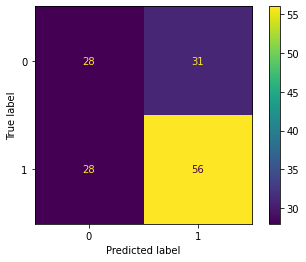

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.6436781609195402
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6549707602339181
 -  F2 score :  0.6619385342789598
 -  ROC AUC :  0.5706214689265536

- KNN Test
Confusion matrix:


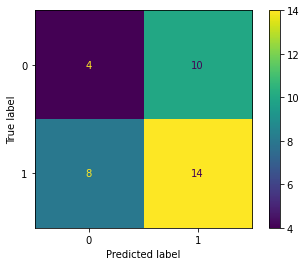

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5833333333333334
 -  Recall :  0.6363636363636364
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.625
 -  ROC AUC :  0.461038961038961

-------------------------
- NB Train
Confusion matrix:


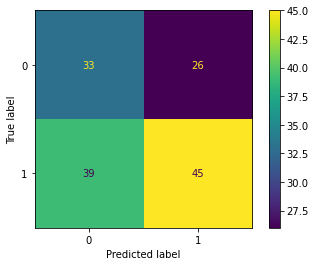

All metric scores:
 -  Accuracy :  0.5454545454545454
 -  Precision :  0.6338028169014085
 -  Recall :  0.5357142857142857
 -  F1 score :  0.5806451612903227
 -  F2 score :  0.5528255528255529
 -  ROC AUC :  0.5475181598062954

- NB Test
Confusion matrix:


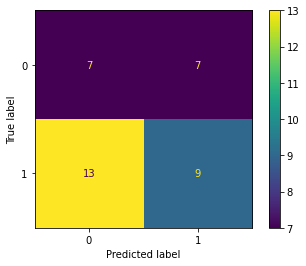

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5625
 -  Recall :  0.4090909090909091
 -  F1 score :  0.47368421052631576
 -  F2 score :  0.4326923076923077
 -  ROC AUC :  0.4545454545454546

-------------------------
- LR Train
Confusion matrix:


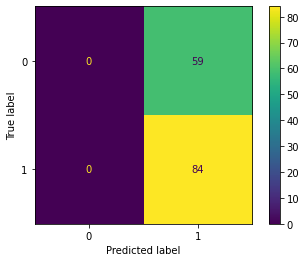

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


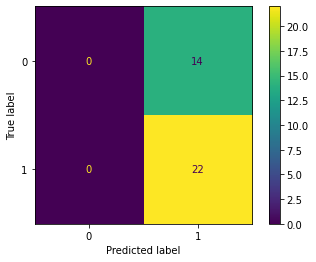

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


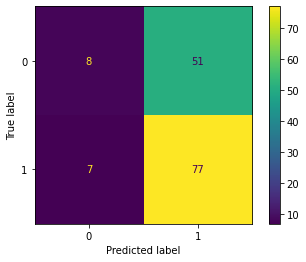

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.6015625
 -  Recall :  0.9166666666666666
 -  F1 score :  0.7264150943396227
 -  F2 score :  0.8297413793103448
 -  ROC AUC :  0.5261299435028248

- SVM Test
Confusion matrix:


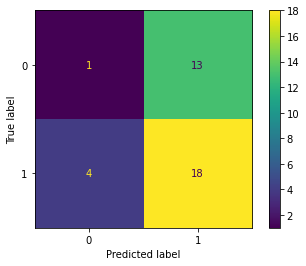

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.5806451612903226
 -  Recall :  0.8181818181818182
 -  F1 score :  0.679245283018868
 -  F2 score :  0.7563025210084033
 -  ROC AUC :  0.4448051948051948

-------------------------
- MLP Train
Confusion matrix:


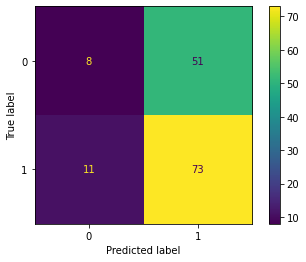

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.5887096774193549
 -  Recall :  0.8690476190476191
 -  F1 score :  0.701923076923077
 -  F2 score :  0.7934782608695653
 -  ROC AUC :  0.502320419693301

- MLP Test
Confusion matrix:


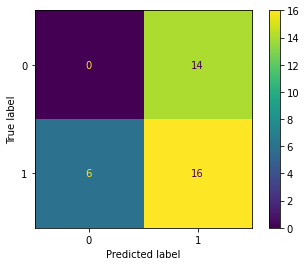

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5333333333333333
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6153846153846153
 -  F2 score :  0.6779661016949153
 -  ROC AUC :  0.36363636363636365

-------------------------
- RF-2 Train
Confusion matrix:


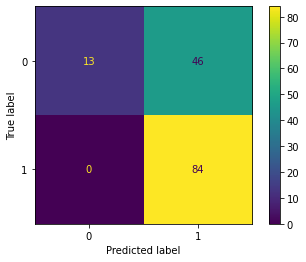

All metric scores:
 -  Accuracy :  0.6783216783216783
 -  Precision :  0.6461538461538462
 -  Recall :  1.0
 -  F1 score :  0.7850467289719627
 -  F2 score :  0.9012875536480687
 -  ROC AUC :  0.6101694915254237

- RF-2 Test
Confusion matrix:


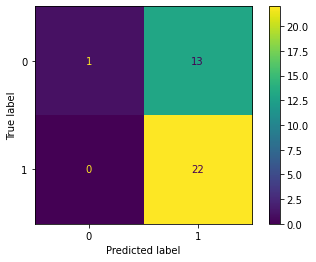

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6285714285714286
 -  Recall :  1.0
 -  F1 score :  0.7719298245614035
 -  F2 score :  0.8943089430894309
 -  ROC AUC :  0.5357142857142857

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:55:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


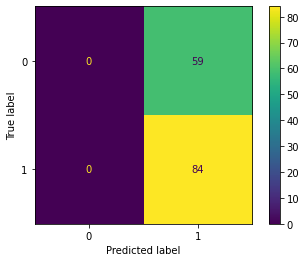

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


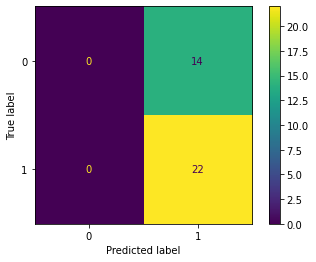

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


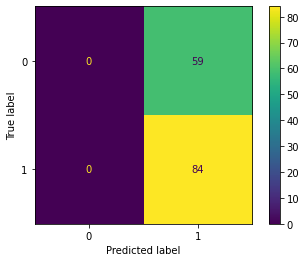

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


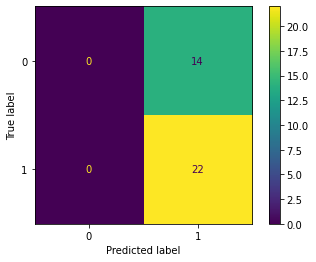

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:55:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


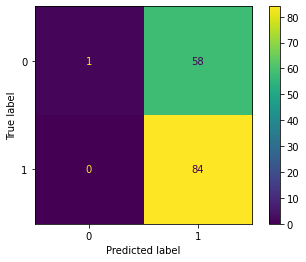

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5915492957746479
 -  Recall :  1.0
 -  F1 score :  0.743362831858407
 -  F2 score :  0.8786610878661089
 -  ROC AUC :  0.5084745762711864
Validation Set: 
Confusion matrix:


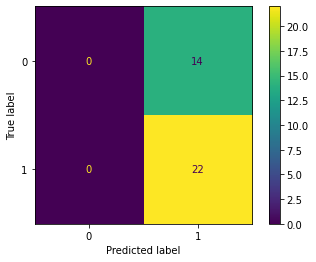

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


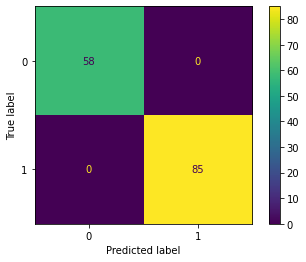

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


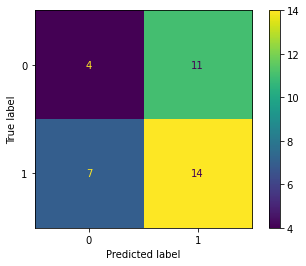

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.56
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.6422018348623854
 -  ROC AUC :  0.4666666666666667

-------------------------
- NB Train
Confusion matrix:


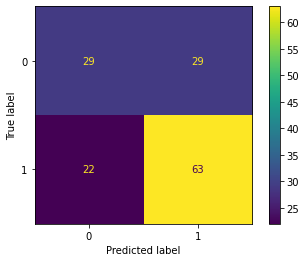

All metric scores:
 -  Accuracy :  0.6433566433566433
 -  Precision :  0.6847826086956522
 -  Recall :  0.7411764705882353
 -  F1 score :  0.7118644067796609
 -  F2 score :  0.7291666666666667
 -  ROC AUC :  0.6205882352941177

- NB Test
Confusion matrix:


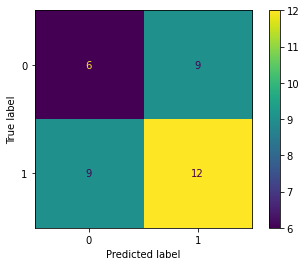

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5714285714285714
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5714285714285714
 -  F2 score :  0.5714285714285714
 -  ROC AUC :  0.48571428571428565

-------------------------
- LR Train
Confusion matrix:


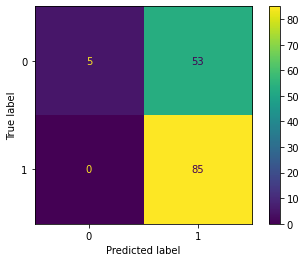

All metric scores:
 -  Accuracy :  0.6293706293706294
 -  Precision :  0.6159420289855072
 -  Recall :  1.0
 -  F1 score :  0.7623318385650223
 -  F2 score :  0.8891213389121339
 -  ROC AUC :  0.5431034482758621

- LR Test
Confusion matrix:


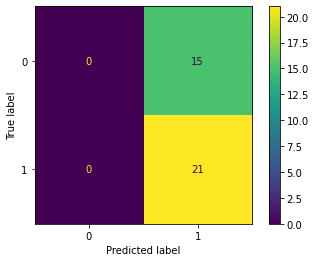

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


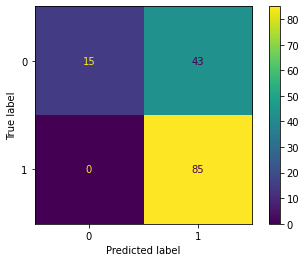

All metric scores:
 -  Accuracy :  0.6993006993006993
 -  Precision :  0.6640625
 -  Recall :  1.0
 -  F1 score :  0.7981220657276995
 -  F2 score :  0.9081196581196581
 -  ROC AUC :  0.6293103448275862

- SVM Test
Confusion matrix:


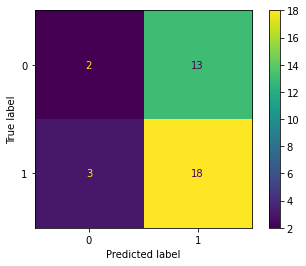

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526

-------------------------
- MLP Train
Confusion matrix:


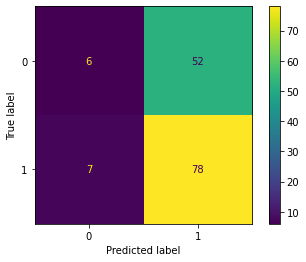

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.6
 -  Recall :  0.9176470588235294
 -  F1 score :  0.7255813953488371
 -  F2 score :  0.8297872340425533
 -  ROC AUC :  0.5105476673427991

- MLP Test
Confusion matrix:


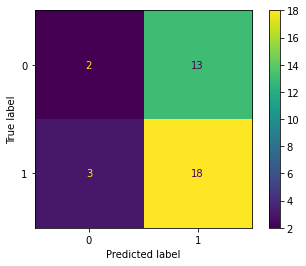

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526

-------------------------
- RF-2 Train
Confusion matrix:


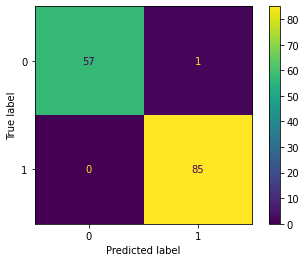

All metric scores:
 -  Accuracy :  0.993006993006993
 -  Precision :  0.9883720930232558
 -  Recall :  1.0
 -  F1 score :  0.9941520467836257
 -  F2 score :  0.9976525821596244
 -  ROC AUC :  0.9913793103448275

- RF-2 Test
Confusion matrix:


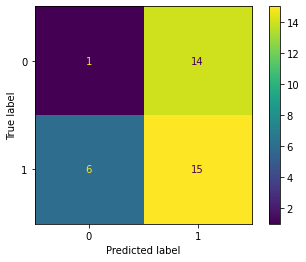

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5172413793103449
 -  Recall :  0.7142857142857143
 -  F1 score :  0.6000000000000001
 -  F2 score :  0.663716814159292
 -  ROC AUC :  0.39047619047619053

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:55:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


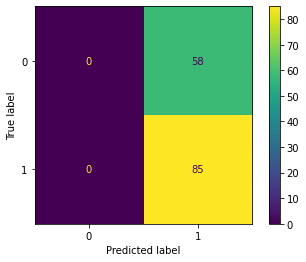

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


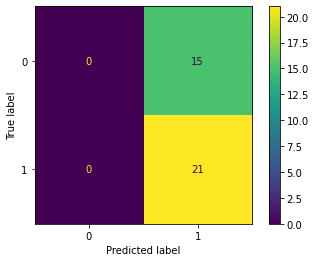

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


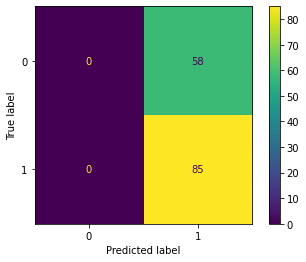

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


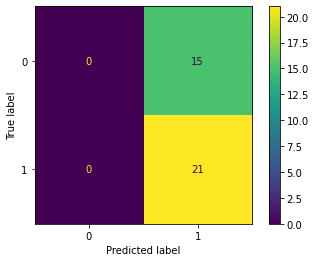

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:55:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


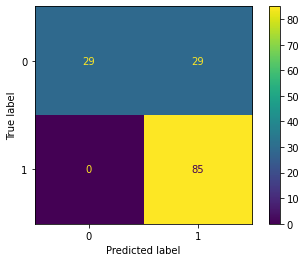

All metric scores:
 -  Accuracy :  0.7972027972027972
 -  Precision :  0.7456140350877193
 -  Recall :  1.0
 -  F1 score :  0.8542713567839196
 -  F2 score :  0.9361233480176211
 -  ROC AUC :  0.75
Validation Set: 
Confusion matrix:


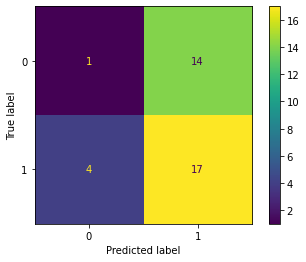

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5483870967741935
 -  Recall :  0.8095238095238095
 -  F1 score :  0.6538461538461537
 -  F2 score :  0.7391304347826086
 -  ROC AUC :  0.4380952380952381
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


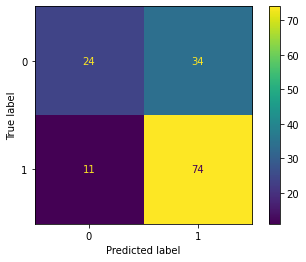

All metric scores:
 -  Accuracy :  0.6853146853146853
 -  Precision :  0.6851851851851852
 -  Recall :  0.8705882352941177
 -  F1 score :  0.766839378238342
 -  F2 score :  0.8258928571428572
 -  ROC AUC :  0.6421906693711967

- KNN Test
Confusion matrix:


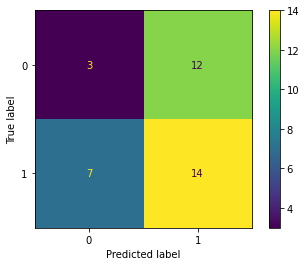

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5384615384615384
 -  Recall :  0.6666666666666666
 -  F1 score :  0.5957446808510638
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.43333333333333324

-------------------------
- NB Train
Confusion matrix:


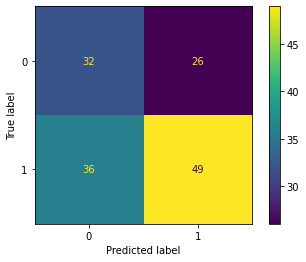

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.6533333333333333
 -  Recall :  0.5764705882352941
 -  F1 score :  0.6124999999999999
 -  F2 score :  0.5903614457831325
 -  ROC AUC :  0.5640973630831643

- NB Test
Confusion matrix:


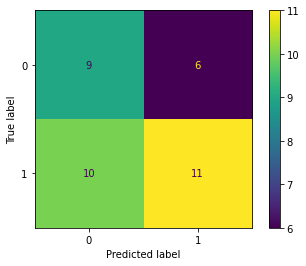

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5619047619047619

-------------------------
- LR Train
Confusion matrix:


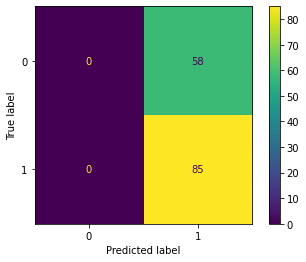

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


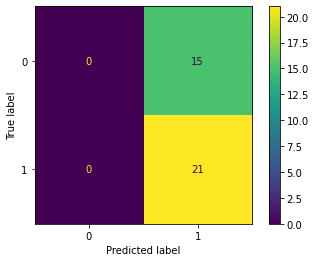

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


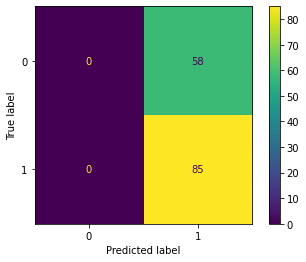

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


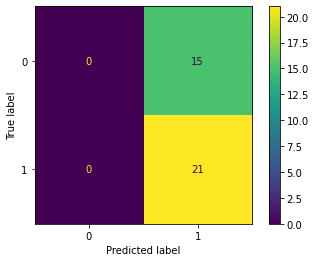

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


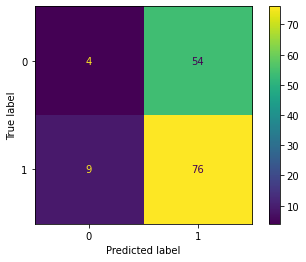

All metric scores:
 -  Accuracy :  0.5594405594405595
 -  Precision :  0.5846153846153846
 -  Recall :  0.8941176470588236
 -  F1 score :  0.7069767441860465
 -  F2 score :  0.8085106382978725
 -  ROC AUC :  0.48154158215010145

- MLP Test
Confusion matrix:


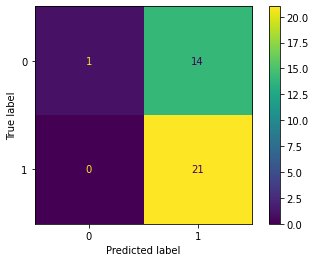

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5333333333333333

-------------------------
- RF-2 Train
Confusion matrix:


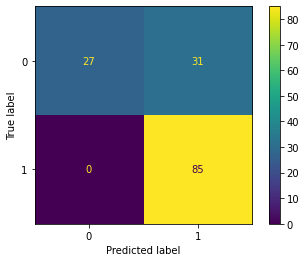

All metric scores:
 -  Accuracy :  0.7832167832167832
 -  Precision :  0.7327586206896551
 -  Recall :  1.0
 -  F1 score :  0.8457711442786069
 -  F2 score :  0.9320175438596492
 -  ROC AUC :  0.7327586206896552

- RF-2 Test
Confusion matrix:


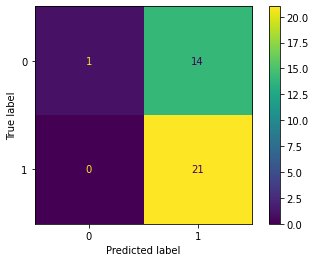

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5333333333333333

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:56:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


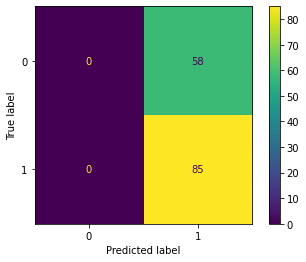

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


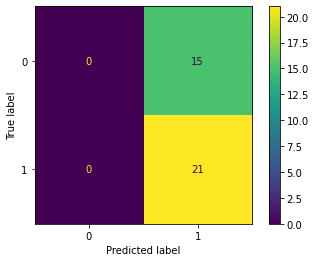

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


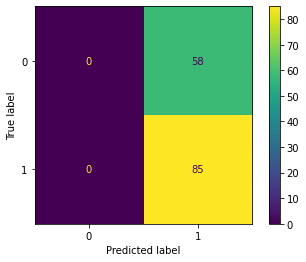

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


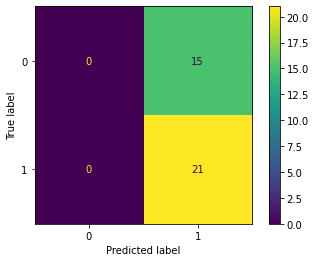

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:56:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


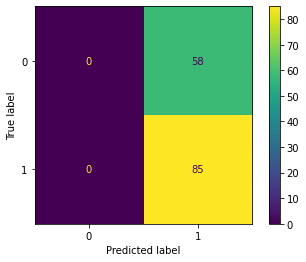

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5
Validation Set: 
Confusion matrix:


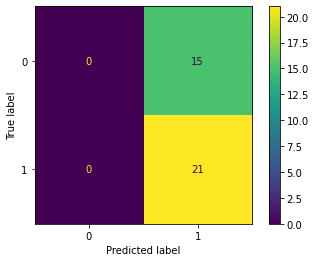

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


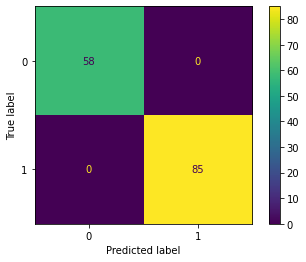

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


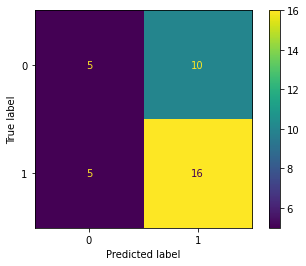

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6153846153846154
 -  Recall :  0.7619047619047619
 -  F1 score :  0.6808510638297872
 -  F2 score :  0.7272727272727273
 -  ROC AUC :  0.5476190476190477

-------------------------
- NB Train
Confusion matrix:


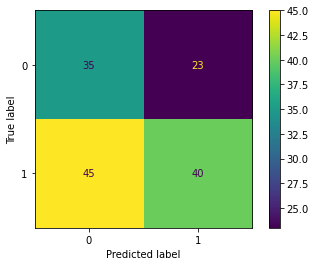

All metric scores:
 -  Accuracy :  0.5244755244755245
 -  Precision :  0.6349206349206349
 -  Recall :  0.47058823529411764
 -  F1 score :  0.5405405405405405
 -  F2 score :  0.4962779156327543
 -  ROC AUC :  0.5370182555780934

- NB Test
Confusion matrix:


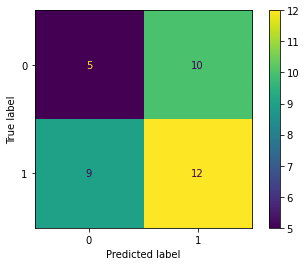

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5454545454545454
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5581395348837208
 -  F2 score :  0.5660377358490566
 -  ROC AUC :  0.4523809523809524

-------------------------
- LR Train
Confusion matrix:


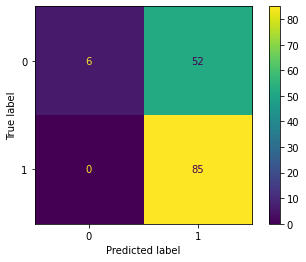

All metric scores:
 -  Accuracy :  0.6363636363636364
 -  Precision :  0.6204379562043796
 -  Recall :  1.0
 -  F1 score :  0.7657657657657658
 -  F2 score :  0.8909853249475891
 -  ROC AUC :  0.5517241379310345

- LR Test
Confusion matrix:


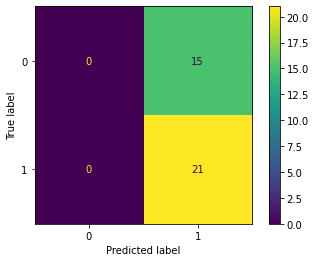

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


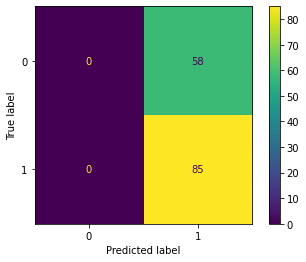

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


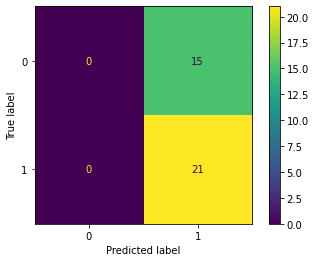

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


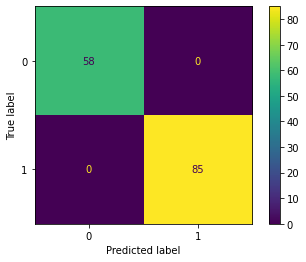

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


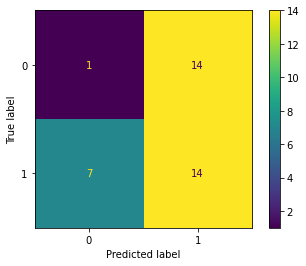

All metric scores:
 -  Accuracy :  0.4166666666666667
 -  Precision :  0.5
 -  Recall :  0.6666666666666666
 -  F1 score :  0.5714285714285715
 -  F2 score :  0.625
 -  ROC AUC :  0.36666666666666664

-------------------------
- RF-2 Train
Confusion matrix:


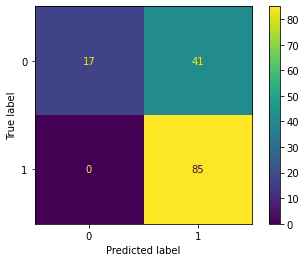

All metric scores:
 -  Accuracy :  0.7132867132867133
 -  Precision :  0.6746031746031746
 -  Recall :  1.0
 -  F1 score :  0.8056872037914692
 -  F2 score :  0.9120171673819744
 -  ROC AUC :  0.646551724137931

- RF-2 Test
Confusion matrix:


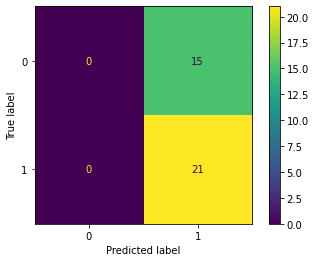

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


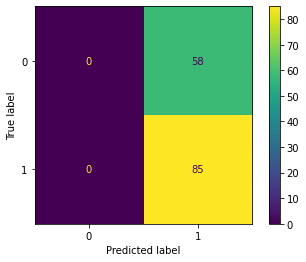

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


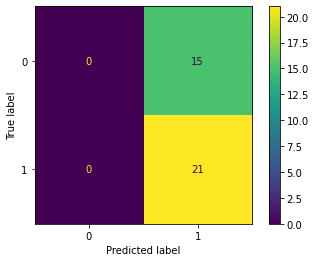

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


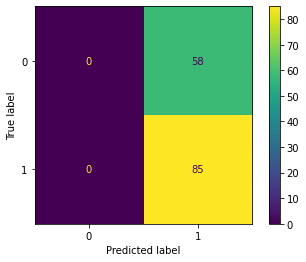

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


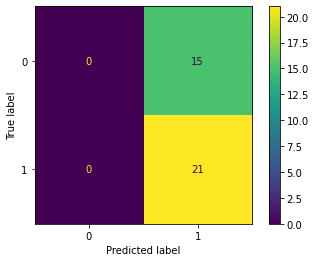

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


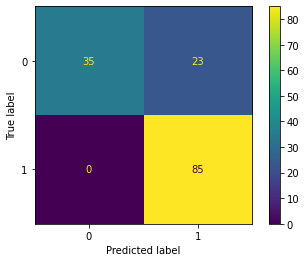

All metric scores:
 -  Accuracy :  0.8391608391608392
 -  Precision :  0.7870370370370371
 -  Recall :  1.0
 -  F1 score :  0.8808290155440415
 -  F2 score :  0.9486607142857142
 -  ROC AUC :  0.8017241379310345
Validation Set: 
Confusion matrix:


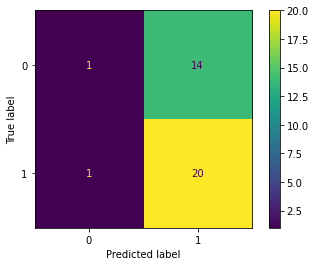

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5882352941176471
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7272727272727274
 -  F2 score :  0.8474576271186443
 -  ROC AUC :  0.5095238095238095
(144, 5000)
(35, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 59
Number Non-Tipical Development: 21
Number Tipical Development: 14

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


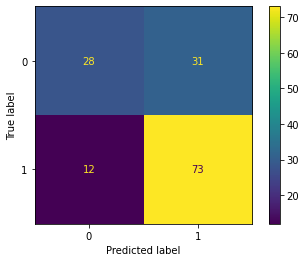

All metric scores:
 -  Accuracy :  0.7013888888888888
 -  Precision :  0.7019230769230769
 -  Recall :  0.8588235294117647
 -  F1 score :  0.7724867724867726
 -  F2 score :  0.822072072072072
 -  ROC AUC :  0.6666999002991026

- KNN Test
Confusion matrix:


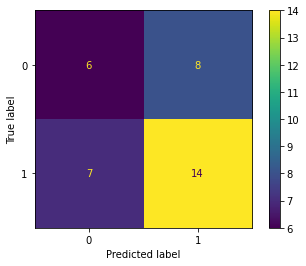

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.6363636363636364
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6511627906976744
 -  F2 score :  0.660377358490566
 -  ROC AUC :  0.5476190476190477

-------------------------
- NB Train
Confusion matrix:


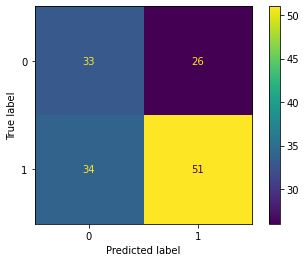

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6623376623376623
 -  Recall :  0.6
 -  F1 score :  0.6296296296296295
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5796610169491526

- NB Test
Confusion matrix:


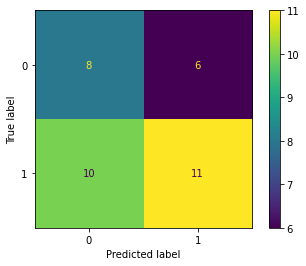

All metric scores:
 -  Accuracy :  0.5428571428571428
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5476190476190476

-------------------------
- LR Train
Confusion matrix:


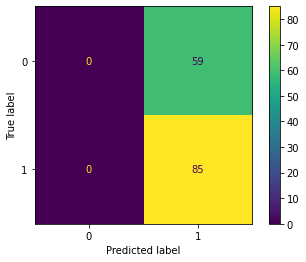

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


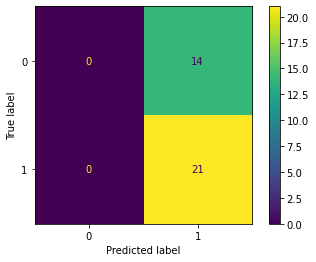

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


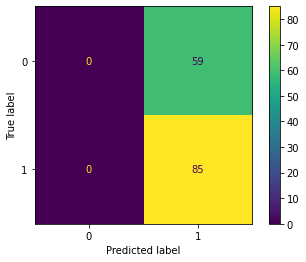

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


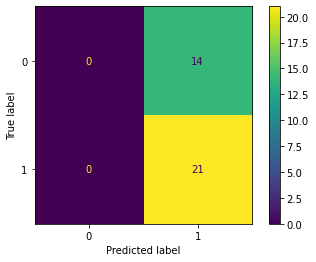

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


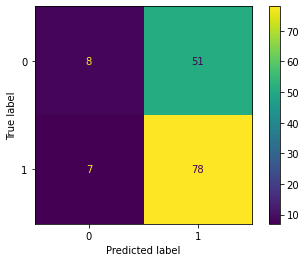

All metric scores:
 -  Accuracy :  0.5972222222222222
 -  Precision :  0.6046511627906976
 -  Recall :  0.9176470588235294
 -  F1 score :  0.7289719626168223
 -  F2 score :  0.8315565031982943
 -  ROC AUC :  0.5266201395812562

- MLP Test
Confusion matrix:


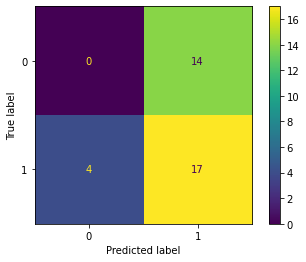

All metric scores:
 -  Accuracy :  0.4857142857142857
 -  Precision :  0.5483870967741935
 -  Recall :  0.8095238095238095
 -  F1 score :  0.6538461538461537
 -  F2 score :  0.7391304347826086
 -  ROC AUC :  0.40476190476190477

-------------------------
- RF-2 Train
Confusion matrix:


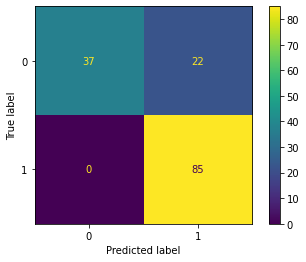

All metric scores:
 -  Accuracy :  0.8472222222222222
 -  Precision :  0.794392523364486
 -  Recall :  1.0
 -  F1 score :  0.8854166666666666
 -  F2 score :  0.9507829977628636
 -  ROC AUC :  0.8135593220338984

- RF-2 Test
Confusion matrix:


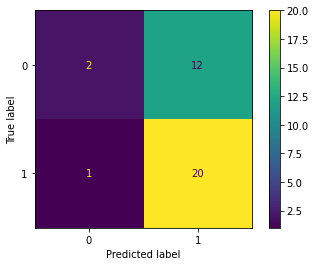

All metric scores:
 -  Accuracy :  0.6285714285714286
 -  Precision :  0.625
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7547169811320755
 -  F2 score :  0.8620689655172412
 -  ROC AUC :  0.5476190476190477

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


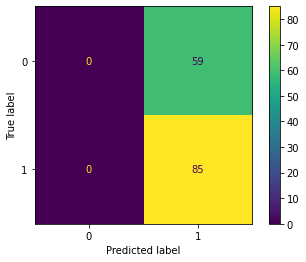

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


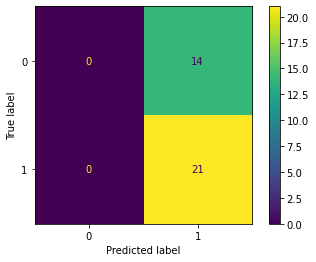

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


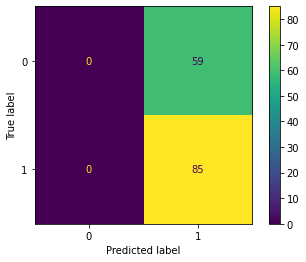

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


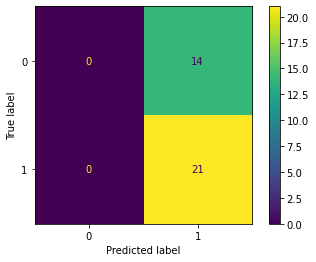

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:58:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


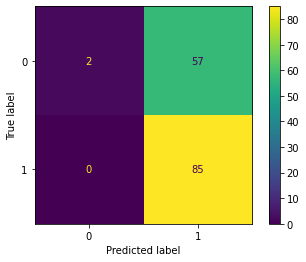

All metric scores:
 -  Accuracy :  0.6041666666666666
 -  Precision :  0.5985915492957746
 -  Recall :  1.0
 -  F1 score :  0.748898678414097
 -  F2 score :  0.8817427385892116
 -  ROC AUC :  0.5169491525423728
Validation Set: 
Confusion matrix:


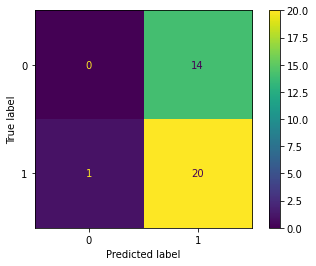

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.5882352941176471
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7272727272727274
 -  F2 score :  0.8474576271186443
 -  ROC AUC :  0.47619047619047616


In [40]:
model_1_prediction_train = []
model_1_prediction_validation = []

model_1_cv_metrics_train = []
model_1_cv_metrics_validation = []

model_1_metrics_train = {}
model_1_metrics_validation = {}

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    X_train_CV = X_train.iloc[train_index]
    X_val_CV = X_train.iloc[test_index]

    print(X_train_CV.shape)
    print(X_val_CV.shape)

    y_train_CV = is_TD(pd.Series(y_train).iloc[train_index])
    y_val_CV = is_TD(pd.Series(y_train).iloc[test_index])

    est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m1.items()]

    est_gs.pop(5)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(7)

    print("\n---------------------------------------------------")

    print("\n---Fold Summary---")

    for (key, estimator) in est_gs:
        estimator.fit(X_train_CV, y_train_CV)

        if(debug):
            print("-", key, "Train")

            model_1_metrics_train[key] =  all_scores(y_train_CV,
                                                    estimator.predict(X_train_CV),
                                                    to_print = True)

            print("\n-", key, "Test")
            model_1_metrics_validation[key] = all_scores(y_val_CV,
                                                         estimator.predict(X_val_CV),
                                                         to_print = True)

            print("\n-------------------------")
            
        else:
            model_1_metrics_train[key] =  all_scores(y_train_CV,
                                                     estimator.predict(X_train_CV),
                                                     to_print = False)

            model_1_metrics_validation[key] = all_scores(y_val_CV,
                                                         estimator.predict(X_val_CV),
                                                         to_print = False)
                                                   
    #soft voting

    print("\n -- Grid Search estimators -- ")

    print("- Soft Voting: ")

    voting = VotingClassifier(estimators=est_gs,
                                   voting='soft',
                                   n_jobs=-1,
                                   verbose=False)

    voting.fit(X_train_CV, y_train_CV)

    print("Training Set: ")
    model_1_metrics_train["voting_ensemble"] =  all_scores(y_train_CV,
                                                           voting.predict(X_train_CV),
                                                           to_print = True)
    print("Validation Set: ")
    model_1_metrics_validation["voting_ensemble"] =  all_scores(y_val_CV,
                                                            voting.predict(X_val_CV),
                                                            to_print = True)
    
    
   


    model_1_prediction_train.append(voting.predict(X_train_CV))
    model_1_prediction_validation.append(voting.predict(X_val_CV))
                                                     
    model_1_cv_metrics_train.append(copy.deepcopy(model_1_metrics_train))
    model_1_cv_metrics_validation.append(copy.deepcopy(model_1_metrics_validation))

In [41]:
t = [print("\nFold ", i, ": \n", pd.Series(model_1_prediction_train[i]).value_counts()) for i in range(K)]


Fold  0 : 
 1    142
0      1
Name: count, dtype: int64

Fold  1 : 
 1    114
0     29
Name: count, dtype: int64

Fold  2 : 
 1    143
Name: count, dtype: int64

Fold  3 : 
 1    108
0     35
Name: count, dtype: int64

Fold  4 : 
 1    142
0      2
Name: count, dtype: int64


In [42]:
t = [print("\nFold ", i, ": \n", pd.Series(model_1_prediction_validation[i]).value_counts()) for i in range(K)]


Fold  0 : 
 1    36
Name: count, dtype: int64

Fold  1 : 
 1    31
0     5
Name: count, dtype: int64

Fold  2 : 
 1    36
Name: count, dtype: int64

Fold  3 : 
 1    34
0     2
Name: count, dtype: int64

Fold  4 : 
 1    34
0     1
Name: count, dtype: int64


### Comparações extra

Celula de visualização extensa dos modelos, comparando os resultados dos pipelines resultantes do GridSearchCV com o setup original dos parametros de cada classificador, e comparando estes com a seleção dos melhores classificadores. Compara também estes resultados para Hard Voting e Soft Voting

In [43]:
# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     X_train_CV = X_train.iloc[train_index]
#     X_val_CV = X_train.iloc[test_index]

#     print(X_train_CV.shape)
#     print(X_val_CV.shape)

#     y_train_CV = is_TD(pd.Series(y_train).iloc[train_index])
#     y_val_CV = is_TD(pd.Series(y_train).iloc[test_index])

#     est_og = [("KNN(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', KNeighborsClassifier())])),
#               ("NB(original)", Pipeline([('scaler', StandardScaler()),
#                                          ('classifier', GaussianNB())])),
#               ("LR(original)", Pipeline([('scaler', StandardScaler()),
#                                          ('classifier', LogisticRegression(max_iter=5000))])),
#               ("SVM(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', svm.SVC(probability=True))])),
#               ("MLP(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', MLPClassifier(random_state=3))])),
#               ("RF(original)", Pipeline([('scaler', StandardScaler()),
#                                          ('classifier', GaussianNB())])),
#               ("XGB(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', XGBClassifier(seed=3,scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
#                                                                       ))])),
#               ("LGBM(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', LGBMClassifier(random_state=3))]))
#              ]

#     est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m1.items()]

#     est_gs.pop(5)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(7)

#     print("\n---------------------------------------------------")

#     print("\n---Fold Summary---")

#     train_scores_gs = []
#     val_scores_gs = []

#     print("\n--Grid Search Estimators")
#     for (key, estimator) in est_gs:
#         estimator.fit(X_train_CV, y_train_CV)

#         print("\n-------------------------")
#         print("-", key, "Train")

#         train_scores_gs.append(all_scores(y_train_CV,
#                                           estimator.predict(X_train_CV),
#                                           to_print = True))

#         print("\n-", key, "Test")
#         val_scores_gs.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))
#     train_scores_og = []
#     val_scores_og = []

#     print("\n  --Original Estimators")
#     for (key, estimator) in est_og:
#         estimator.fit(X_train_CV, y_train_CV)

#         print("\n-------------------------")
#         print("-", key, "Train")

#         train_scores_og.append(all_scores(y_true = y_train_CV,
#                                        y_pred = estimator.predict(X_train_CV),
#                                        to_print = True))

#         print("\n-", key, "Test")
#         val_scores_og.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))


#     est_mix = []

#     for j, (key, _) in enumerate(est_gs):
#         if(val_scores_gs[j]["F2 score"] > val_scores_og[j]["F2 score"]):
#             est_mix.append(est_gs[j])
#         else:
#             est_mix.append(est_og[j])


#     [print(key) for (key, _) in est_mix]


#     voting_training_scores = []
#     voting_validation_scores = []

#     #hard voting

#     print("\n -- Grid Search estimators -- ")

#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_gs,
#                                    voting='hard',
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("GS_HardVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_HardVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     print("- Soft Voting: ")

#     soft_voting = VotingClassifier(estimators=est_gs,
#                                    voting='soft',
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("GS_SoftVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_SoftVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))




#     print("\n -- Untuned estimators -- ")

#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_og,
#                                    voting='hard',
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_HardVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_HardVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     print("- Soft Voting: ")

#     soft_voting = VotingClassifier(estimators=est_og,
#                                    voting='soft',
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_SoftVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_SoftVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))


#     print("\n -- Mixed estimators -- ")

#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_mix,
#                                    voting='hard',
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_HardVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_HardVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     print("- Soft Voting: ")

#     soft_voting = VotingClassifier(estimators=est_mix,
#                                    voting='soft',
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_SoftVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_SoftVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     best_scores = ("null", {"F2 score": -1})
#     for tup in voting_validation_scores:
#         if (tup[1]["F2 score"] > best_scores[1]["F2 score"]):
#             best_scores = tup

#     print("Best voting: ", best_scores[0])
#     print("Scores: ", best_scores[1])

#     print("\n---------------------------------------------------")

## MODEL 2: ASD or non-TD

### Hyperparameter tunning

**Descomentar celula (teclas 'ctrl'+'/' ou 'command'+'/') para rodar o hiperparameter tunning com GridSearchCV, comentado para facilitar execução de todas as celulas de uma vez**

In [44]:
# gs_results_dict_m2={
#     'KNN':[],
#     'NB':[],
#     'LR':[],
#     'SVM':[],
#     'MLP':[],
#     'RF-1':[],
#     'RF-2':[],
#     'XGB-1':[],
#     'XGB-2':[],
#     'XGB-3':[],
#     'XGB-4':[],
#     'LGBM-1':[],
#     'LGBM-2':[]
# }

# pipeline_dict_m2 = copy.deepcopy(pipeline_dict)

# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     print("\nFOLD: " + str(i))

#     X_train_CV = X_train.iloc[train_index]
#     X_train_CV = X_train_CV.iloc[model_1_prediction_train[i] == 1]

#     X_val_CV = X_train.iloc[test_index]
#     X_val_CV = X_val_CV.iloc[model_1_prediction_validation[i] == 1]

#     y_train_CV = is_ASD(pd.Series(y_train).iloc[train_index].iloc[model_1_prediction_train[i] == 1])
#     y_val_CV = is_ASD(pd.Series(y_train).iloc[test_index].iloc[model_1_prediction_validation[i] == 1])
    
#     if debug:
#         print(X_train_CV.shape)
#         print(X_val_CV.shape)
#         print(y_train_CV.shape)
#         print(y_val_CV.shape)

#     ## GRID SEARCHES FOR BEST PARAMETERS

#     inner_kfold_cv = StratifiedKFold(n_splits=3, random_state=4, shuffle=True)
    
#     if debug:
#         for j, (inner_train_index, inner_test_index) in enumerate(inner_kfold_cv.split(X_train_CV, 
#                                                                                    pd.Series(y_train).iloc[train_index].iloc[model_1_prediction_train[i] == 1])):
#             print("INNER FOLD: " + str(j))
#             print(X_train_CV.iloc[inner_train_index].shape)
#             print(X_train_CV.iloc[inner_test_index].shape)
#             print(pd.Series(y_train_CV).iloc[inner_train_index].shape)
#             print(pd.Series(y_train_CV).iloc[inner_test_index].shape)

#     for key in pipeline_dict_m2.keys():
#         gs = grid_search_cv_fit_and_print(X = X_train_CV,
#                                           y = y_train_CV,
#                                           estimator = pipeline_dict_m2[key],
#                                           param_grid = param_dict[key],
#                                           scoring = f2,
#                                           cv = inner_kfold_cv.split(X_train_CV,
#                                                                     pd.Series(y_train).iloc[train_index].iloc[model_1_prediction_train[i] == 1]),
#                                           printing_name = key)

#         gs_results_dict_m2[key].append(gs)

#         if(key == "RF-1"):
#             pipeline_dict_m2[key] = pipeline_dict_m2[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])

#         if(key == "XGB-1"):
#             pipeline_dict_m2[key] = pipeline_dict_m2[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])

#         if(key == "XGB-2"):
#             pipeline_dict_m2[key] = pipeline_dict_m2[key].set_params(
#                 classifier__min_child_weight=gs.best_params_['classifier__min_child_weight'],
#                 classifier__gamma=gs.best_params_['classifier__gamma'])

#         if(key == "XGB-3"):
#             pipeline_dict_m2[key] = pipeline_dict_m2[key].set_params(
#                 classifier__subsample=gs.best_params_['classifier__subsample'],
#                 classifier__colsample_bytree=gs.best_params_['classifier__colsample_bytree'])

#         if(key == "LGBM-1"):
#             pipeline_dict_m2[key] = pipeline_dict_m2[key].set_params(
#                 classifier__boosting_type=gs.best_params_['classifier__boosting_type'],
#                 classifier__feature_fraction=gs.best_params_['classifier__feature_fraction'])


Descomentar para salvar novos resultados, comentado para evitar sobrescrever arquivos em uso

In [45]:
# if(on_drive):
#     with open('/content/drive/MyDrive/Laura Speggiorin - TCC/pickles/Model2_GridSearchResults_kfoldcv.pkl', 'wb') as f:
#         pickle.dump(gs_results_dict_m2, f)
# else:
#     with open('./pickles/Model2_GridSearchResults_kfoldcv.pkl', 'wb') as f:
#         pickle.dump(gs_results_dict_m2, f)

if(on_drive):
    with open('/content/drive/MyDrive/Laura Speggiorin - TCC/pickles/Model2_GridSearchResults_kfoldcv.pkl', 'rb') as f:
        gs_results_dict_m2 = pickle.load(f)
else:
    with open('./pickles/Model2_GridSearchResults_kfoldcv.pkl', 'rb') as f:
        gs_results_dict_m2 = pickle.load(f)

### Training + Voting

(142, 5000)
(36, 5000)
Number ASD Development: 33
Number ASD Development: 9

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


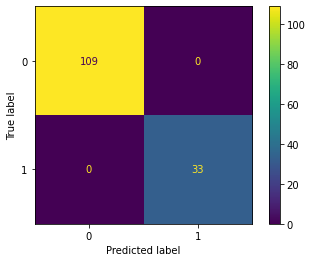

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


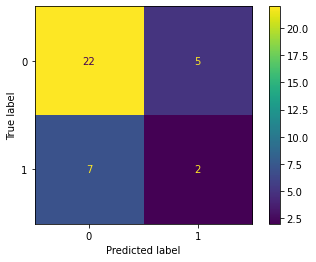

All metric scores:
 -  Accuracy :  0.6666666666666666
 -  Precision :  0.2857142857142857
 -  Recall :  0.2222222222222222
 -  F1 score :  0.25
 -  F2 score :  0.23255813953488366
 -  ROC AUC :  0.5185185185185186

-------------------------
- NB Train
Confusion matrix:


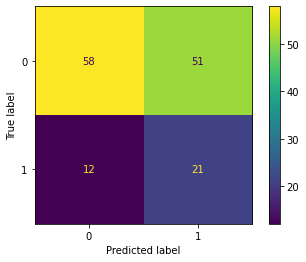

All metric scores:
 -  Accuracy :  0.5563380281690141
 -  Precision :  0.2916666666666667
 -  Recall :  0.6363636363636364
 -  F1 score :  0.4
 -  F2 score :  0.5147058823529411
 -  ROC AUC :  0.5842368640533777

- NB Test
Confusion matrix:


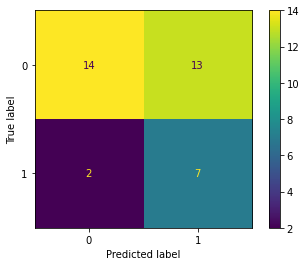

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.35
 -  Recall :  0.7777777777777778
 -  F1 score :  0.48275862068965514
 -  F2 score :  0.6250000000000001
 -  ROC AUC :  0.6481481481481481

-------------------------
- LR Train
Confusion matrix:


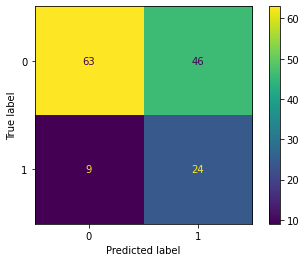

All metric scores:
 -  Accuracy :  0.6126760563380281
 -  Precision :  0.34285714285714286
 -  Recall :  0.7272727272727273
 -  F1 score :  0.46601941747572817
 -  F2 score :  0.5940594059405943
 -  ROC AUC :  0.652627189324437

- LR Test
Confusion matrix:


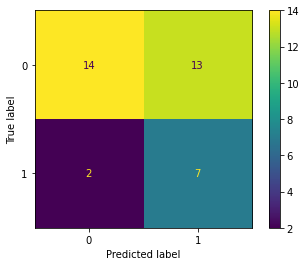

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.35
 -  Recall :  0.7777777777777778
 -  F1 score :  0.48275862068965514
 -  F2 score :  0.6250000000000001
 -  ROC AUC :  0.6481481481481481

-------------------------
- SVM Train
Confusion matrix:


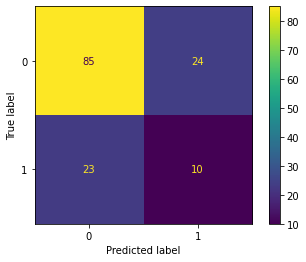

All metric scores:
 -  Accuracy :  0.6690140845070423
 -  Precision :  0.29411764705882354
 -  Recall :  0.30303030303030304
 -  F1 score :  0.29850746268656714
 -  F2 score :  0.30120481927710846
 -  ROC AUC :  0.5414234083958854

- SVM Test
Confusion matrix:


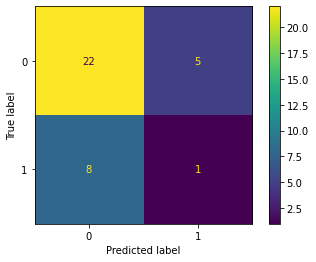

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.16666666666666666
 -  Recall :  0.1111111111111111
 -  F1 score :  0.13333333333333333
 -  F2 score :  0.11904761904761904
 -  ROC AUC :  0.462962962962963

-------------------------
- MLP Train
Confusion matrix:


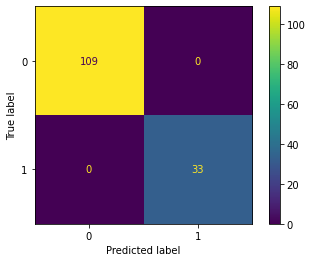

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


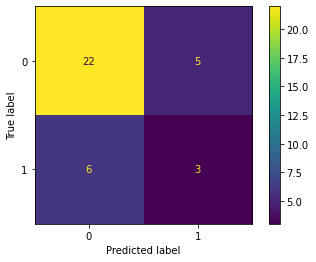

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.375
 -  Recall :  0.3333333333333333
 -  F1 score :  0.35294117647058826
 -  F2 score :  0.34090909090909094
 -  ROC AUC :  0.5740740740740741

-------------------------
- RF-2 Train
Confusion matrix:


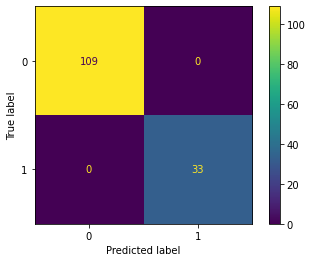

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- RF-2 Test
Confusion matrix:


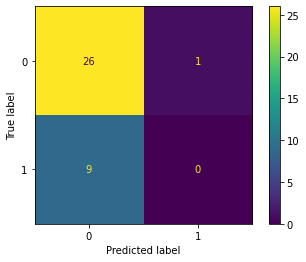

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4814814814814815

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:58:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


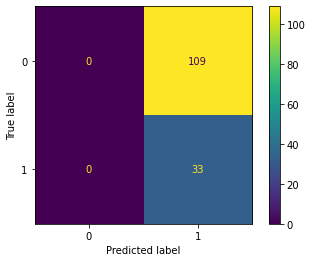

All metric scores:
 -  Accuracy :  0.2323943661971831
 -  Precision :  0.2323943661971831
 -  Recall :  1.0
 -  F1 score :  0.37714285714285717
 -  F2 score :  0.6021897810218978
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


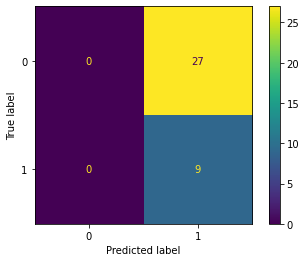

All metric scores:
 -  Accuracy :  0.25
 -  Precision :  0.25
 -  Recall :  1.0
 -  F1 score :  0.4
 -  F2 score :  0.625
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


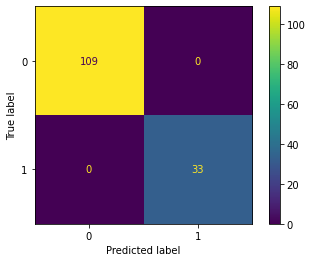

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM-2 Test
Confusion matrix:


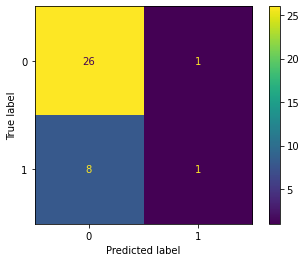

All metric scores:
 -  Accuracy :  0.75
 -  Precision :  0.5
 -  Recall :  0.1111111111111111
 -  F1 score :  0.1818181818181818
 -  F2 score :  0.13157894736842105
 -  ROC AUC :  0.5370370370370371

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:58:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


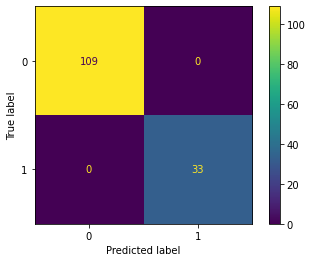

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


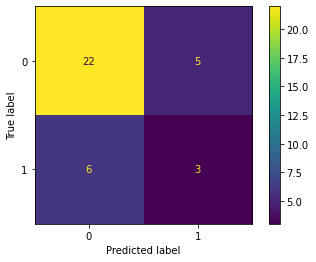

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.375
 -  Recall :  0.3333333333333333
 -  F1 score :  0.35294117647058826
 -  F2 score :  0.34090909090909094
 -  ROC AUC :  0.5740740740740741

---------------------------------------------------
(114, 5000)
(31, 5000)
Number ASD Development: 33
Number ASD Development: 6

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


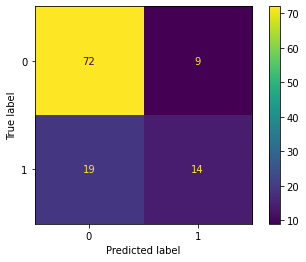

All metric scores:
 -  Accuracy :  0.7543859649122807
 -  Precision :  0.6086956521739131
 -  Recall :  0.42424242424242425
 -  F1 score :  0.5
 -  F2 score :  0.45161290322580644
 -  ROC AUC :  0.6565656565656566

- KNN Test
Confusion matrix:


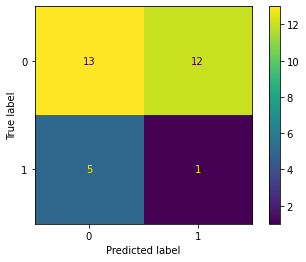

All metric scores:
 -  Accuracy :  0.45161290322580644
 -  Precision :  0.07692307692307693
 -  Recall :  0.16666666666666666
 -  F1 score :  0.10526315789473684
 -  F2 score :  0.13513513513513514
 -  ROC AUC :  0.3433333333333333

-------------------------
- NB Train
Confusion matrix:


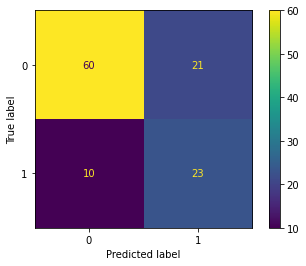

All metric scores:
 -  Accuracy :  0.7280701754385965
 -  Precision :  0.5227272727272727
 -  Recall :  0.696969696969697
 -  F1 score :  0.5974025974025974
 -  F2 score :  0.6534090909090908
 -  ROC AUC :  0.7188552188552189

- NB Test
Confusion matrix:


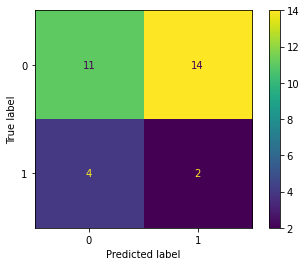

All metric scores:
 -  Accuracy :  0.41935483870967744
 -  Precision :  0.125
 -  Recall :  0.3333333333333333
 -  F1 score :  0.18181818181818182
 -  F2 score :  0.25
 -  ROC AUC :  0.3866666666666666

-------------------------
- LR Train
Confusion matrix:


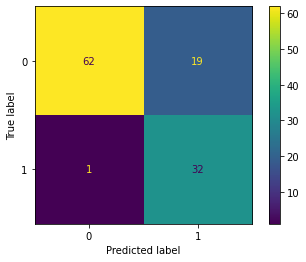

All metric scores:
 -  Accuracy :  0.8245614035087719
 -  Precision :  0.6274509803921569
 -  Recall :  0.9696969696969697
 -  F1 score :  0.761904761904762
 -  F2 score :  0.8743169398907104
 -  ROC AUC :  0.8675645342312011

- LR Test
Confusion matrix:


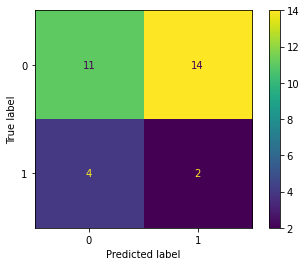

All metric scores:
 -  Accuracy :  0.41935483870967744
 -  Precision :  0.125
 -  Recall :  0.3333333333333333
 -  F1 score :  0.18181818181818182
 -  F2 score :  0.25
 -  ROC AUC :  0.3866666666666666

-------------------------
- SVM Train
Confusion matrix:


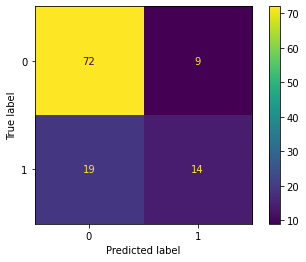

All metric scores:
 -  Accuracy :  0.7543859649122807
 -  Precision :  0.6086956521739131
 -  Recall :  0.42424242424242425
 -  F1 score :  0.5
 -  F2 score :  0.45161290322580644
 -  ROC AUC :  0.6565656565656566

- SVM Test
Confusion matrix:


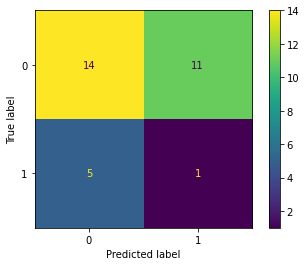

All metric scores:
 -  Accuracy :  0.4838709677419355
 -  Precision :  0.08333333333333333
 -  Recall :  0.16666666666666666
 -  F1 score :  0.1111111111111111
 -  F2 score :  0.13888888888888887
 -  ROC AUC :  0.3633333333333334

-------------------------
- MLP Train
Confusion matrix:


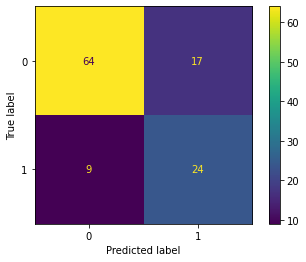

All metric scores:
 -  Accuracy :  0.7719298245614035
 -  Precision :  0.5853658536585366
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6486486486486487
 -  F2 score :  0.6936416184971098
 -  ROC AUC :  0.7586980920314254

- MLP Test
Confusion matrix:


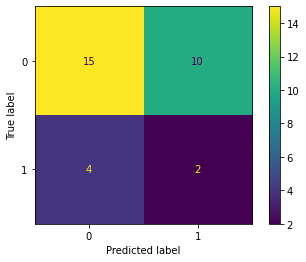

All metric scores:
 -  Accuracy :  0.5483870967741935
 -  Precision :  0.16666666666666666
 -  Recall :  0.3333333333333333
 -  F1 score :  0.2222222222222222
 -  F2 score :  0.27777777777777773
 -  ROC AUC :  0.4666666666666666

-------------------------
- RF-2 Train
Confusion matrix:


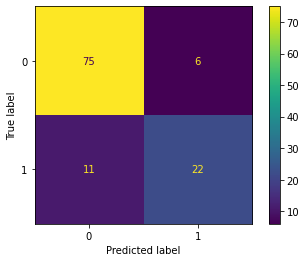

All metric scores:
 -  Accuracy :  0.8508771929824561
 -  Precision :  0.7857142857142857
 -  Recall :  0.6666666666666666
 -  F1 score :  0.721311475409836
 -  F2 score :  0.6874999999999999
 -  ROC AUC :  0.7962962962962963

- RF-2 Test
Confusion matrix:


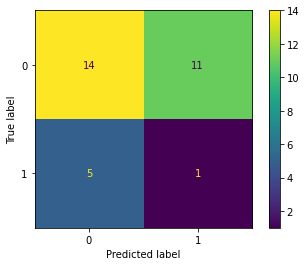

All metric scores:
 -  Accuracy :  0.4838709677419355
 -  Precision :  0.08333333333333333
 -  Recall :  0.16666666666666666
 -  F1 score :  0.1111111111111111
 -  F2 score :  0.13888888888888887
 -  ROC AUC :  0.3633333333333334

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:59:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


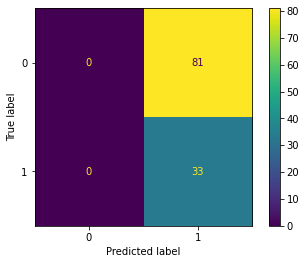

All metric scores:
 -  Accuracy :  0.2894736842105263
 -  Precision :  0.2894736842105263
 -  Recall :  1.0
 -  F1 score :  0.4489795918367347
 -  F2 score :  0.6707317073170732
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


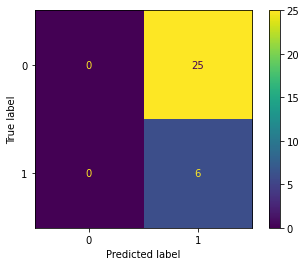

All metric scores:
 -  Accuracy :  0.1935483870967742
 -  Precision :  0.1935483870967742
 -  Recall :  1.0
 -  F1 score :  0.3243243243243243
 -  F2 score :  0.5454545454545455
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


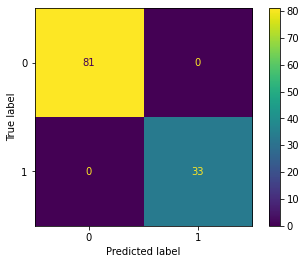

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM-2 Test
Confusion matrix:


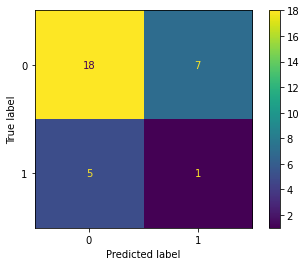

All metric scores:
 -  Accuracy :  0.6129032258064516
 -  Precision :  0.125
 -  Recall :  0.16666666666666666
 -  F1 score :  0.14285714285714288
 -  F2 score :  0.15625
 -  ROC AUC :  0.4433333333333333

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:59:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


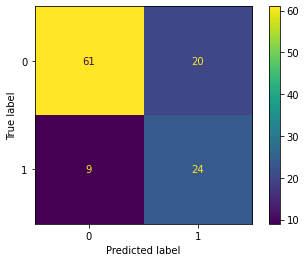

All metric scores:
 -  Accuracy :  0.7456140350877193
 -  Precision :  0.5454545454545454
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6233766233766234
 -  F2 score :  0.6818181818181818
 -  ROC AUC :  0.7401795735129069
Validation Set: 
Confusion matrix:


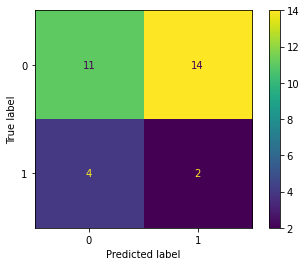

All metric scores:
 -  Accuracy :  0.41935483870967744
 -  Precision :  0.125
 -  Recall :  0.3333333333333333
 -  F1 score :  0.18181818181818182
 -  F2 score :  0.25
 -  ROC AUC :  0.3866666666666666

---------------------------------------------------
(143, 5000)
(36, 5000)
Number ASD Development: 34
Number ASD Development: 8

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


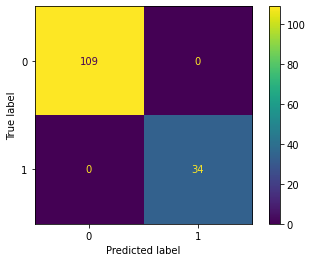

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


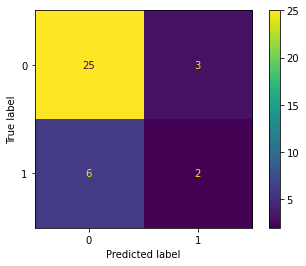

All metric scores:
 -  Accuracy :  0.75
 -  Precision :  0.4
 -  Recall :  0.25
 -  F1 score :  0.3076923076923077
 -  F2 score :  0.27027027027027023
 -  ROC AUC :  0.5714285714285714

-------------------------
- NB Train
Confusion matrix:


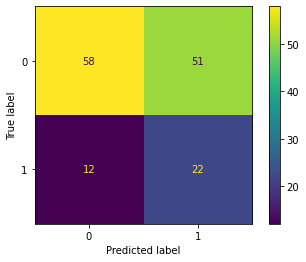

All metric scores:
 -  Accuracy :  0.5594405594405595
 -  Precision :  0.3013698630136986
 -  Recall :  0.6470588235294118
 -  F1 score :  0.411214953271028
 -  F2 score :  0.5263157894736842
 -  ROC AUC :  0.5895844576362654

- NB Test
Confusion matrix:


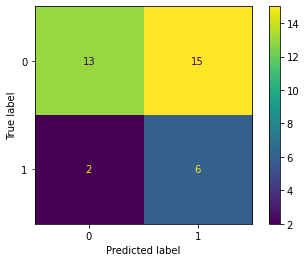

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.2857142857142857
 -  Recall :  0.75
 -  F1 score :  0.4137931034482759
 -  F2 score :  0.5660377358490565
 -  ROC AUC :  0.6071428571428572

-------------------------
- LR Train
Confusion matrix:


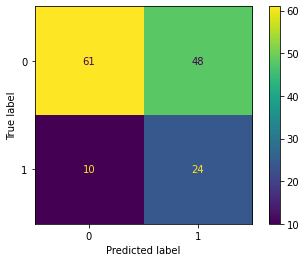

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.3333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.45283018867924524
 -  F2 score :  0.576923076923077
 -  ROC AUC :  0.6327576902320562

- LR Test
Confusion matrix:


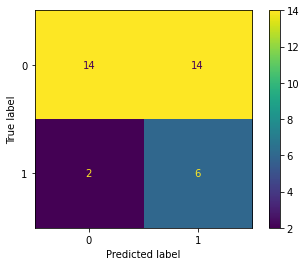

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.3
 -  Recall :  0.75
 -  F1 score :  0.4285714285714285
 -  F2 score :  0.576923076923077
 -  ROC AUC :  0.625

-------------------------
- SVM Train
Confusion matrix:


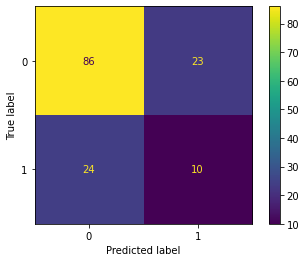

All metric scores:
 -  Accuracy :  0.6713286713286714
 -  Precision :  0.30303030303030304
 -  Recall :  0.29411764705882354
 -  F1 score :  0.29850746268656714
 -  F2 score :  0.29585798816568043
 -  ROC AUC :  0.5415542363734485

- SVM Test
Confusion matrix:


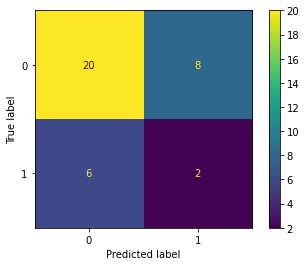

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.2
 -  Recall :  0.25
 -  F1 score :  0.22222222222222224
 -  F2 score :  0.23809523809523808
 -  ROC AUC :  0.48214285714285715

-------------------------
- MLP Train
Confusion matrix:


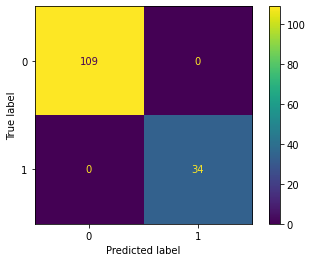

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


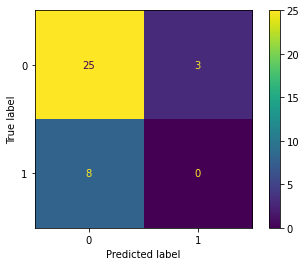

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.44642857142857145

-------------------------
- RF-2 Train
Confusion matrix:


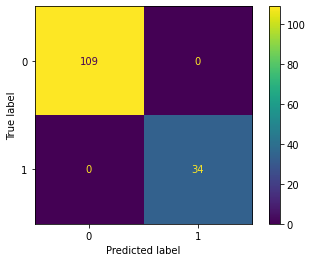

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- RF-2 Test
Confusion matrix:


/home/laura/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


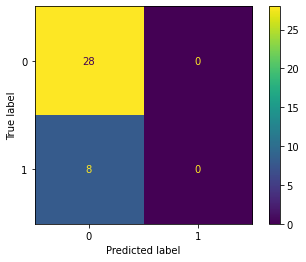

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:59:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


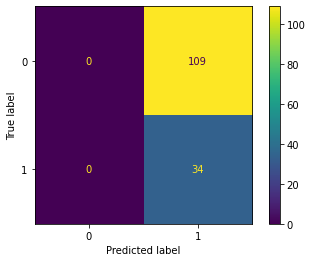

All metric scores:
 -  Accuracy :  0.23776223776223776
 -  Precision :  0.23776223776223776
 -  Recall :  1.0
 -  F1 score :  0.384180790960452
 -  F2 score :  0.6093189964157706
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


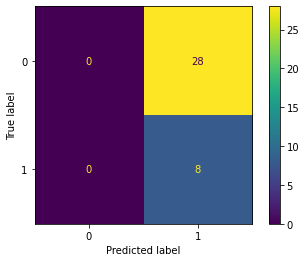

All metric scores:
 -  Accuracy :  0.2222222222222222
 -  Precision :  0.2222222222222222
 -  Recall :  1.0
 -  F1 score :  0.3636363636363636
 -  F2 score :  0.5882352941176471
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


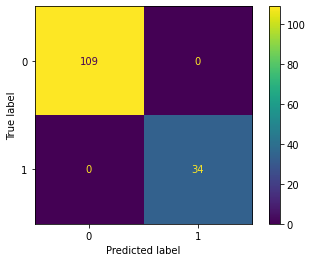

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM-2 Test
Confusion matrix:


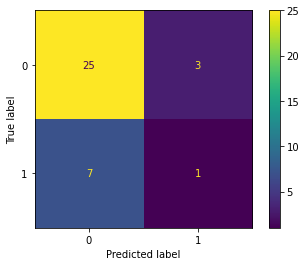

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.25
 -  Recall :  0.125
 -  F1 score :  0.16666666666666666
 -  F2 score :  0.1388888888888889
 -  ROC AUC :  0.5089285714285715

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:59:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


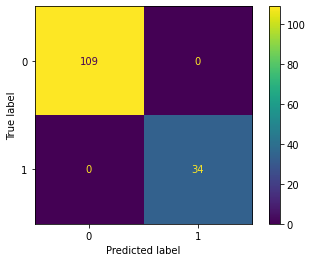

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


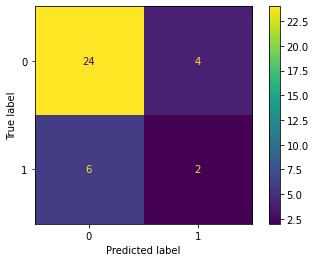

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.3333333333333333
 -  Recall :  0.25
 -  F1 score :  0.28571428571428575
 -  F2 score :  0.2631578947368421
 -  ROC AUC :  0.5535714285714287

---------------------------------------------------
(108, 5000)
(34, 5000)
Number ASD Development: 34
Number ASD Development: 7

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


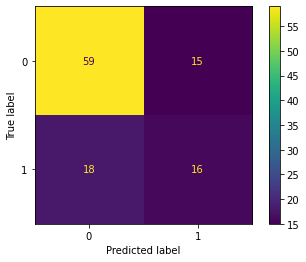

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.5161290322580645
 -  Recall :  0.47058823529411764
 -  F1 score :  0.4923076923076923
 -  F2 score :  0.4790419161676646
 -  ROC AUC :  0.6339427662957074

- KNN Test
Confusion matrix:


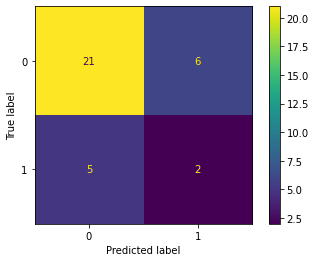

All metric scores:
 -  Accuracy :  0.6764705882352942
 -  Precision :  0.25
 -  Recall :  0.2857142857142857
 -  F1 score :  0.26666666666666666
 -  F2 score :  0.2777777777777778
 -  ROC AUC :  0.5317460317460316

-------------------------
- NB Train
Confusion matrix:


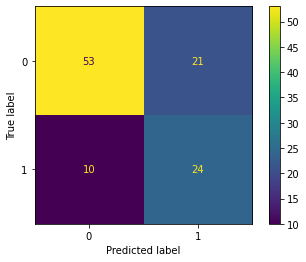

All metric scores:
 -  Accuracy :  0.7129629629629629
 -  Precision :  0.5333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6075949367088608
 -  F2 score :  0.6629834254143646
 -  ROC AUC :  0.7110492845786964

- NB Test
Confusion matrix:


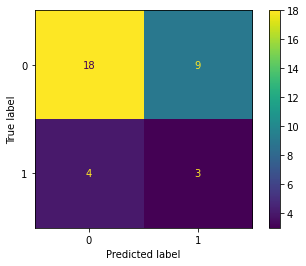

All metric scores:
 -  Accuracy :  0.6176470588235294
 -  Precision :  0.25
 -  Recall :  0.42857142857142855
 -  F1 score :  0.3157894736842105
 -  F2 score :  0.375
 -  ROC AUC :  0.5476190476190477

-------------------------
- LR Train
Confusion matrix:


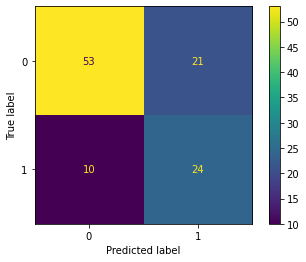

All metric scores:
 -  Accuracy :  0.7129629629629629
 -  Precision :  0.5333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6075949367088608
 -  F2 score :  0.6629834254143646
 -  ROC AUC :  0.7110492845786964

- LR Test
Confusion matrix:


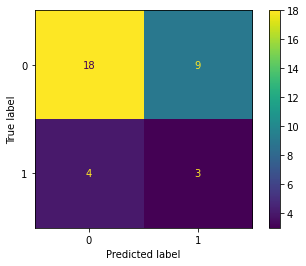

All metric scores:
 -  Accuracy :  0.6176470588235294
 -  Precision :  0.25
 -  Recall :  0.42857142857142855
 -  F1 score :  0.3157894736842105
 -  F2 score :  0.375
 -  ROC AUC :  0.5476190476190477

-------------------------
- SVM Train
Confusion matrix:


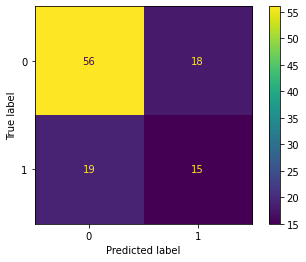

All metric scores:
 -  Accuracy :  0.6574074074074074
 -  Precision :  0.45454545454545453
 -  Recall :  0.4411764705882353
 -  F1 score :  0.4477611940298507
 -  F2 score :  0.44378698224852065
 -  ROC AUC :  0.598966613672496

- SVM Test
Confusion matrix:


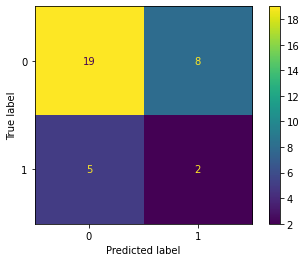

All metric scores:
 -  Accuracy :  0.6176470588235294
 -  Precision :  0.2
 -  Recall :  0.2857142857142857
 -  F1 score :  0.23529411764705882
 -  F2 score :  0.26315789473684204
 -  ROC AUC :  0.49470899470899465

-------------------------
- MLP Train
Confusion matrix:


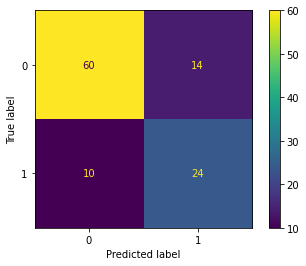

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.631578947368421
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6666666666666667
 -  F2 score :  0.6896551724137931
 -  ROC AUC :  0.7583465818759937

- MLP Test
Confusion matrix:


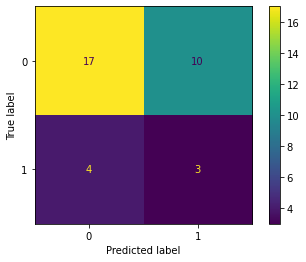

All metric scores:
 -  Accuracy :  0.5882352941176471
 -  Precision :  0.23076923076923078
 -  Recall :  0.42857142857142855
 -  F1 score :  0.3
 -  F2 score :  0.36585365853658536
 -  ROC AUC :  0.5291005291005291

-------------------------
- RF-2 Train
Confusion matrix:


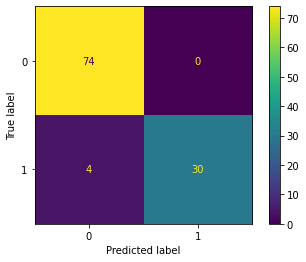

All metric scores:
 -  Accuracy :  0.9629629629629629
 -  Precision :  1.0
 -  Recall :  0.8823529411764706
 -  F1 score :  0.9375
 -  F2 score :  0.9036144578313253
 -  ROC AUC :  0.9411764705882353

- RF-2 Test
Confusion matrix:


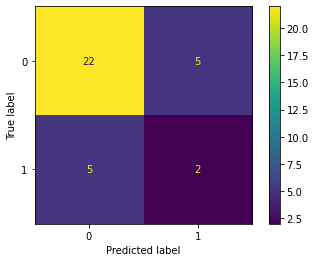

All metric scores:
 -  Accuracy :  0.7058823529411765
 -  Precision :  0.2857142857142857
 -  Recall :  0.2857142857142857
 -  F1 score :  0.2857142857142857
 -  F2 score :  0.2857142857142857
 -  ROC AUC :  0.5502645502645502

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:00:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


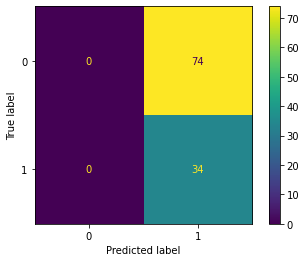

All metric scores:
 -  Accuracy :  0.3148148148148148
 -  Precision :  0.3148148148148148
 -  Recall :  1.0
 -  F1 score :  0.4788732394366197
 -  F2 score :  0.6967213114754098
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


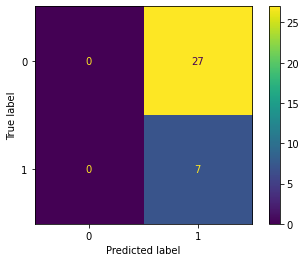

All metric scores:
 -  Accuracy :  0.20588235294117646
 -  Precision :  0.20588235294117646
 -  Recall :  1.0
 -  F1 score :  0.34146341463414637
 -  F2 score :  0.564516129032258
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


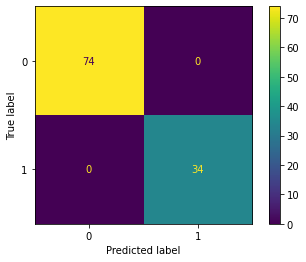

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM-2 Test
Confusion matrix:


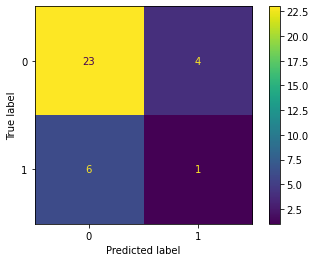

All metric scores:
 -  Accuracy :  0.7058823529411765
 -  Precision :  0.2
 -  Recall :  0.14285714285714285
 -  F1 score :  0.16666666666666666
 -  F2 score :  0.15151515151515152
 -  ROC AUC :  0.4973544973544973

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:00:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


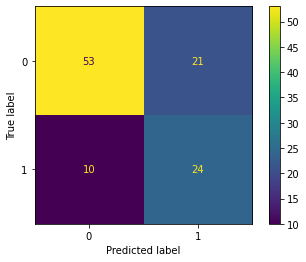

All metric scores:
 -  Accuracy :  0.7129629629629629
 -  Precision :  0.5333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6075949367088608
 -  F2 score :  0.6629834254143646
 -  ROC AUC :  0.7110492845786964
Validation Set: 
Confusion matrix:


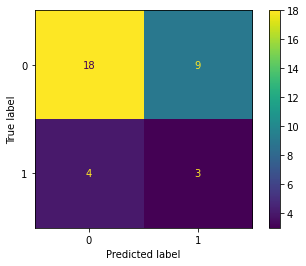

All metric scores:
 -  Accuracy :  0.6176470588235294
 -  Precision :  0.25
 -  Recall :  0.42857142857142855
 -  F1 score :  0.3157894736842105
 -  F2 score :  0.375
 -  ROC AUC :  0.5476190476190477

---------------------------------------------------
(142, 5000)
(34, 5000)
Number ASD Development: 34
Number ASD Development: 7

---------------------------------------------------

---Fold Summary---
- KNN Train
Confusion matrix:


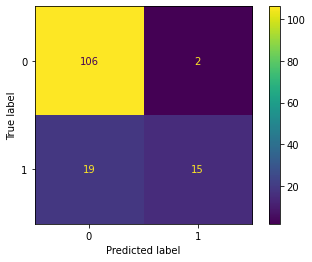

All metric scores:
 -  Accuracy :  0.852112676056338
 -  Precision :  0.8823529411764706
 -  Recall :  0.4411764705882353
 -  F1 score :  0.5882352941176471
 -  F2 score :  0.4901960784313726
 -  ROC AUC :  0.7113289760348583

- KNN Test
Confusion matrix:


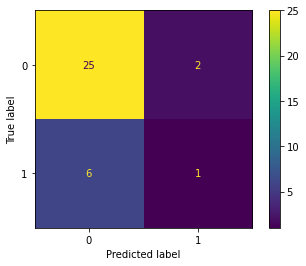

All metric scores:
 -  Accuracy :  0.7647058823529411
 -  Precision :  0.3333333333333333
 -  Recall :  0.14285714285714285
 -  F1 score :  0.2
 -  F2 score :  0.16129032258064516
 -  ROC AUC :  0.5343915343915344

-------------------------
- NB Train
Confusion matrix:


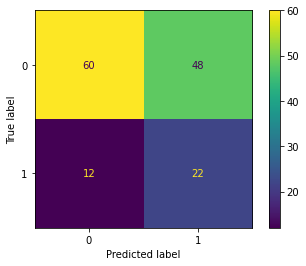

All metric scores:
 -  Accuracy :  0.5774647887323944
 -  Precision :  0.3142857142857143
 -  Recall :  0.6470588235294118
 -  F1 score :  0.4230769230769231
 -  F2 score :  0.5339805825242718
 -  ROC AUC :  0.6013071895424836

- NB Test
Confusion matrix:


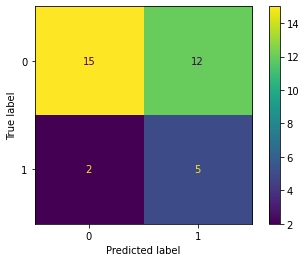

All metric scores:
 -  Accuracy :  0.5882352941176471
 -  Precision :  0.29411764705882354
 -  Recall :  0.7142857142857143
 -  F1 score :  0.4166666666666667
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.6349206349206349

-------------------------
- LR Train
Confusion matrix:


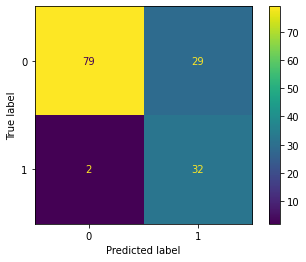

All metric scores:
 -  Accuracy :  0.7816901408450704
 -  Precision :  0.5245901639344263
 -  Recall :  0.9411764705882353
 -  F1 score :  0.6736842105263159
 -  F2 score :  0.8121827411167513
 -  ROC AUC :  0.8363289760348583

- LR Test
Confusion matrix:


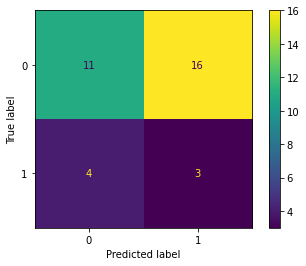

All metric scores:
 -  Accuracy :  0.4117647058823529
 -  Precision :  0.15789473684210525
 -  Recall :  0.42857142857142855
 -  F1 score :  0.23076923076923078
 -  F2 score :  0.3191489361702127
 -  ROC AUC :  0.417989417989418

-------------------------
- SVM Train
Confusion matrix:


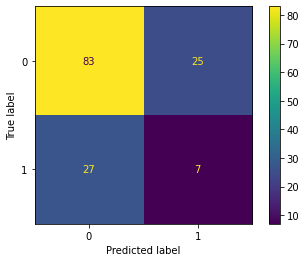

All metric scores:
 -  Accuracy :  0.6338028169014085
 -  Precision :  0.21875
 -  Recall :  0.20588235294117646
 -  F1 score :  0.21212121212121213
 -  F2 score :  0.20833333333333331
 -  ROC AUC :  0.48720043572984745

- SVM Test
Confusion matrix:


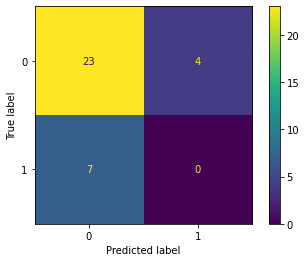

All metric scores:
 -  Accuracy :  0.6764705882352942
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.42592592592592593

-------------------------
- MLP Train
Confusion matrix:


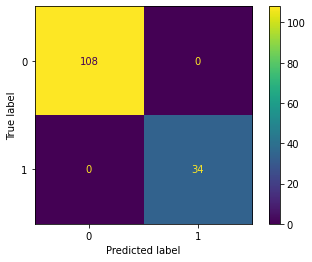

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


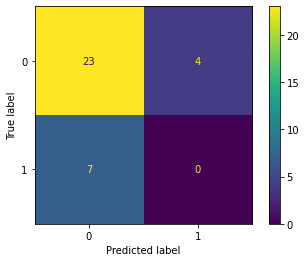

All metric scores:
 -  Accuracy :  0.6764705882352942
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.42592592592592593

-------------------------
- RF-2 Train
Confusion matrix:


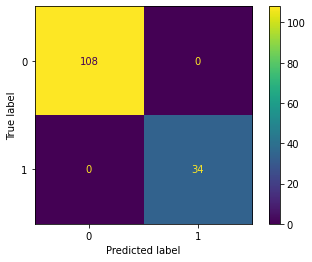

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- RF-2 Test
Confusion matrix:


/home/laura/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


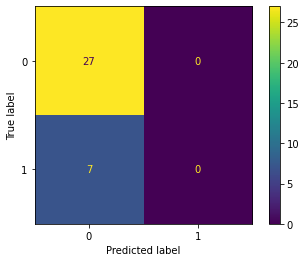

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:00:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


- XGB-4 Train
Confusion matrix:


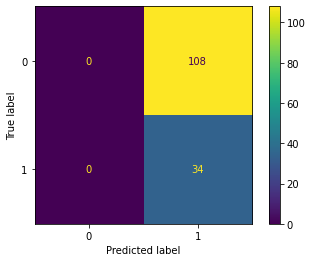

All metric scores:
 -  Accuracy :  0.23943661971830985
 -  Precision :  0.23943661971830985
 -  Recall :  1.0
 -  F1 score :  0.38636363636363635
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


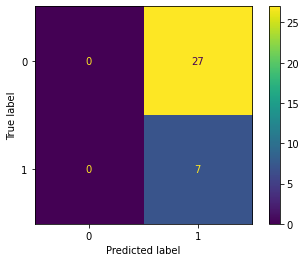

All metric scores:
 -  Accuracy :  0.20588235294117646
 -  Precision :  0.20588235294117646
 -  Recall :  1.0
 -  F1 score :  0.34146341463414637
 -  F2 score :  0.564516129032258
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


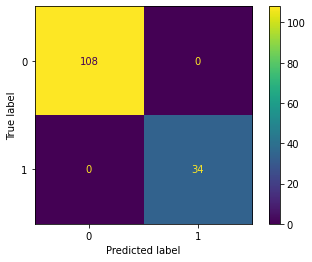

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM-2 Test
Confusion matrix:


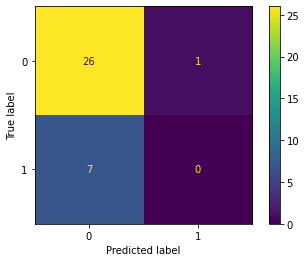

All metric scores:
 -  Accuracy :  0.7647058823529411
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4814814814814815

-------------------------

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:00:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


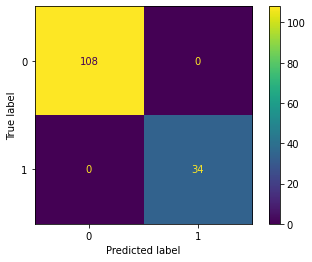

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


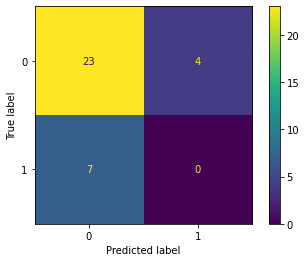

All metric scores:
 -  Accuracy :  0.6764705882352942
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.42592592592592593

---------------------------------------------------


In [46]:
model_2_prediction_train = []
model_2_prediction_validation = []

model_2_cv_metrics_train = []
model_2_cv_metrics_validation = []

model_2_metrics_train = {}
model_2_metrics_validation = {}

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    X_train_CV = X_train.iloc[train_index]
    X_train_CV = X_train_CV.iloc[model_1_prediction_train[i] == 1]

    X_val_CV = X_train.iloc[test_index]
    X_val_CV = X_val_CV.iloc[model_1_prediction_validation[i] == 1]

    print(X_train_CV.shape)
    print(X_val_CV.shape)

    y_train_CV = is_ASD(pd.Series(y_train).iloc[train_index].iloc[model_1_prediction_train[i] == 1])
    y_val_CV = is_ASD(pd.Series(y_train).iloc[test_index].iloc[model_1_prediction_validation[i] == 1])

    est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m2.items()]

    est_gs.pop(5)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(7)

    print("\n---------------------------------------------------")

    print("\n---Fold Summary---")

    for (key, estimator) in est_gs:
        estimator.fit(X_train_CV, y_train_CV)
        
        if(debug):
            print("-", key, "Train")

            model_2_metrics_train[key] =  all_scores(y_train_CV,
                                                    estimator.predict(X_train_CV),
                                                    to_print = True)

            print("\n-", key, "Test")
            model_2_metrics_validation[key] = all_scores(y_val_CV,
                                                         estimator.predict(X_val_CV),
                                                         to_print = True)

            print("\n-------------------------")
            
        else:
            model_1_metrics_train[key] =  all_scores(y_train_CV,
                                                     estimator.predict(X_train_CV),
                                                     to_print = False)

            model_1_metrics_validation[key] = all_scores(y_val_CV,
                                                         estimator.predict(X_val_CV),
                                                         to_print = False)


    #soft voting

    print("\n -- Grid Search estimators -- ")

    print("- Soft Voting: ")

    voting = VotingClassifier(estimators=est_gs,
                                   voting='soft',
                                   n_jobs=-1,
                                   verbose=False)

    voting.fit(X_train_CV, y_train_CV)

    print("Training Set: ")
    model_2_metrics_train["voting_ensemble"] =  all_scores(y_train_CV,
                                                           voting.predict(X_train_CV),
                                                           to_print = True)
    print("Validation Set: ")
    model_2_metrics_validation["voting_ensemble"] =  all_scores(y_val_CV,
                                                            voting.predict(X_val_CV),
                                                            to_print = True)

    print("\n---------------------------------------------------")

    model_2_prediction_train.append(voting.predict(X_train_CV))
    model_2_prediction_validation.append(voting.predict(X_val_CV))
    
    model_2_cv_metrics_train.append(copy.deepcopy(model_2_metrics_train))
    model_2_cv_metrics_validation.append(copy.deepcopy(model_2_metrics_validation))

In [47]:
t = [print("\nFold ", i, ": \n", pd.Series(model_2_prediction_train[i]).value_counts()) for i in range(K)]


Fold  0 : 
 0    109
1     33
Name: count, dtype: int64

Fold  1 : 
 0    70
1    44
Name: count, dtype: int64

Fold  2 : 
 0    109
1     34
Name: count, dtype: int64

Fold  3 : 
 0    63
1    45
Name: count, dtype: int64

Fold  4 : 
 0    108
1     34
Name: count, dtype: int64


In [48]:
t = [print("\nFold ", i, ": \n", pd.Series(model_2_prediction_validation[i]).value_counts()) for i in range(K)]


Fold  0 : 
 0    28
1     8
Name: count, dtype: int64

Fold  1 : 
 1    16
0    15
Name: count, dtype: int64

Fold  2 : 
 0    30
1     6
Name: count, dtype: int64

Fold  3 : 
 0    22
1    12
Name: count, dtype: int64

Fold  4 : 
 0    30
1     4
Name: count, dtype: int64


### Comparações extra

Celula de visualização extensa dos modelos, comparando os resultados dos pipelines resultantes do GridSearchCV com o setup original dos parametros de cada classificador, e comparando estes com a seleção dos melhores classificadores. Compara também estes resultados para Hard Voting e Soft Voting

In [49]:
# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     X_train_CV = X_train.iloc[train_index]
#     X_train_CV = X_train_CV.iloc[model_1_prediction_train[i] == 1]

#     X_val_CV = X_train.iloc[test_index]
#     X_val_CV = X_val_CV.iloc[model_1_prediction_validation[i] == 1]

#     print(X_train_CV.shape)
#     print(X_val_CV.shape)

#     y_train_CV = is_ASD(pd.Series(y_train).iloc[train_index].iloc[model_1_prediction_train[i] == 1])
#     y_val_CV = is_ASD(pd.Series(y_train).iloc[test_index].iloc[model_1_prediction_validation[i] == 1])

#     est_og = [("KNN(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', KNeighborsClassifier())])),
#               ("NB(original)", Pipeline([('scaler', StandardScaler()),
#                                          ('classifier', GaussianNB())])),
#               ("LR(original)", Pipeline([('scaler', StandardScaler()),
#                                          ('classifier', LogisticRegression(max_iter=5000))])),
#               ("SVM(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', svm.SVC(probability=True))])),
#               ("MLP(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', MLPClassifier(random_state=3))])),
#               ("RF(original)", Pipeline([('scaler', StandardScaler()),
#                                          ('classifier', GaussianNB())])),
#               ("XGB(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', XGBClassifier(seed=3,scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
#                                                                       ))])),
#               ("LGBM(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', LGBMClassifier(random_state=3))]))
#              ]

#     est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m1.items()]

#     est_gs.pop(5)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(7)

#     print("\n---------------------------------------------------")

#     print("\n---Fold Summary---")

#     train_scores_gs = []
#     val_scores_gs = []

#     print("\n--Grid Search Estimators")
#     for (key, estimator) in est_gs:
#         estimator.fit(X_train_CV, y_train_CV)

#         print("\n-------------------------")
#         print("-", key, "Train")

#         train_scores_gs.append(all_scores(y_train_CV,
#                                           estimator.predict(X_train_CV),
#                                           to_print = True))

#         print("\n-", key, "Test")
#         val_scores_gs.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))
#     train_scores_og = []
#     val_scores_og = []

#     print("\n  --Original Estimators")
#     for (key, estimator) in est_og:
#         estimator.fit(X_train_CV, y_train_CV)

#         print("\n-------------------------")
#         print("-", key, "Train")

#         train_scores_og.append(all_scores(y_true = y_train_CV,
#                                        y_pred = estimator.predict(X_train_CV),
#                                        to_print = True))

#         print("\n-", key, "Test")
#         val_scores_og.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))


#     est_mix = []

#     for j, (key, _) in enumerate(est_gs):
#         if(val_scores_gs[j]["F2 score"] > val_scores_og[j]["F2 score"]):
#             est_mix.append(est_gs[j])
#         else:
#             est_mix.append(est_og[j])


#     [print(key) for (key, _) in est_mix]


#     voting_training_scores = []
#     voting_validation_scores = []

#     #hard voting

#     print("\n -- Grid Search estimators -- ")

#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_gs,
#                                    voting='hard',
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("GS_HardVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_HardVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     print("- Soft Voting: ")

#     soft_voting = VotingClassifier(estimators=est_gs,
#                                    voting='soft',
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("GS_SoftVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_SoftVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))




#     print("\n -- Untuned estimators -- ")

#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_og,
#                                    voting='hard',
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_HardVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_HardVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     print("- Soft Voting: ")

#     soft_voting = VotingClassifier(estimators=est_og,
#                                    voting='soft',
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_SoftVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_SoftVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))


#     print("\n -- Mixed estimators -- ")

#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_mix,
#                                    voting='hard',
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_HardVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_HardVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     print("- Soft Voting: ")

#     soft_voting = VotingClassifier(estimators=est_mix,
#                                    voting='soft',
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_SoftVoting",
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))

#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_SoftVoting",
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     best_scores = ("null", {"F2 score": -1})
#     for tup in voting_validation_scores:
#         if (tup[1]["F2 score"] > best_scores[1]["F2 score"]):
#             best_scores = tup

#     print("Best voting: ", best_scores[0])
#     print("Scores: ", best_scores[1])

#     print("\n---------------------------------------------------")

# Validation

## Hyperparameter choosing

In [50]:
pipeline_dict_m1_test = copy.deepcopy(pipeline_dict)
pipeline_dict_m2_test = copy.deepcopy(pipeline_dict)

In [51]:
global_metrics_df = {}

### KNN

In [52]:
weights_1 = []
weights_2 = []
n_neighbors_1 = []
n_neighbors_2 = []
leaf_size_1 = []
leaf_size_2 = []
p_1 = p_2 = []
metric_1 = []
metric_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["KNN"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["KNN"][i].best_params_)
    
    weights_1.append(param_grid_1["classifier__weights"])
    p_1.append(param_grid_1["classifier__p"])
    metric_1.append(param_grid_1["classifier__metric"])
    n_neighbors_1.append(param_grid_1["classifier__n_neighbors"])
    leaf_size_1.append(param_grid_1["classifier__leaf_size"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["KNN"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["KNN"][i].best_params_)
    
    weights_2.append(param_grid_2["classifier__weights"])
    p_2.append(param_grid_2["classifier__p"])
    metric_2.append(param_grid_2["classifier__metric"])
    n_neighbors_2.append(param_grid_2["classifier__n_neighbors"])
    leaf_size_2.append(param_grid_2["classifier__leaf_size"])

M1:  {'classifier__leaf_size': 20, 'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 13, 'classifier__p': 1, 'classifier__weights': 'uniform'}
M2:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 1, 'classifier__p': 1, 'classifier__weights': 'uniform'}
M1:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 14, 'classifier__p': 1, 'classifier__weights': 'distance'}
M2:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 13, 'classifier__p': 2, 'classifier__weights': 'uniform'}
M1:  {'classifier__leaf_size': 20, 'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 13, 'classifier__p': 1, 'classifier__weights': 'uniform'}
M2:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 1, 'classifier__p': 2, 'classifier__weights': 'uniform'}
M1:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', '

In [53]:
# MODEL 1    
if debug:
    print("- KNN Model 1 Selected parameters")
    
    print("Weights: ", stats.mode(weights_1).mode[0])
    print("p: ", stats.mode(p_1).mode[0])
    print("Metric: ", stats.mode(metric_1).mode[0])
    print("n_neighbors: ", int(np.median(n_neighbors_1)))
    print("leaf_size: ", int(np.median(leaf_size_1)))

# MODEL 1
pipeline_dict_m1_test["KNN"] = pipeline_dict_m1_test["KNN"].set_params(
    # nominal parameters
    classifier__weights = stats.mode(weights_1).mode[0],
    classifier__p = stats.mode(p_1).mode[0],
    classifier__metric = stats.mode(metric_1).mode[0],
    
    # integer parameters
    classifier__n_neighbors = int(np.median(n_neighbors_1)),
    classifier__leaf_size = int(np.median(leaf_size_1))
)

- KNN Model 1 Selected parameters
Weights:  uniform
p:  1
Metric:  minkowski
n_neighbors:  13
leaf_size:  20


Number Non-Tipical Development: 106
Number Tipical Development: 73
Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


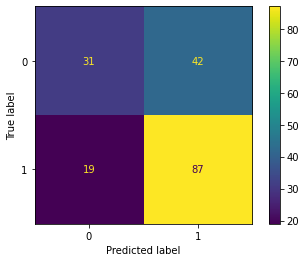

All metric scores:
 -  Accuracy :  0.659217877094972
 -  Precision :  0.6744186046511628
 -  Recall :  0.8207547169811321
 -  F1 score :  0.7404255319148936
 -  F2 score :  0.786618444846293
 -  ROC AUC :  0.6227061256138537
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


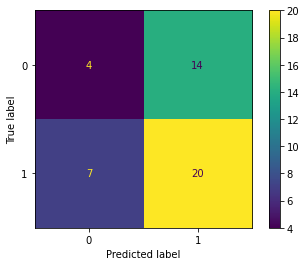

All metric scores:
 -  Accuracy :  0.5333333333333333
 -  Precision :  0.5882352941176471
 -  Recall :  0.7407407407407407
 -  F1 score :  0.6557377049180328
 -  F2 score :  0.704225352112676
 -  ROC AUC :  0.4814814814814814


In [54]:
pipeline_dict_m1_test["KNN"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["KNN"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["KNN"].predict(X_test),
                       to_print = True)

In [55]:
global_metrics_df = pd.concat([pd.DataFrame([{
    'classifier': "KNN",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "KNN",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   

     recall  F1_score  F2_score   ROC_AUC  
0  0.820755  0.740426  0.786618  0.622706  
0  0.740741  0.655738  0.704225  0.481481  


In [56]:
# MODEL 2    
if debug:
    print("- KNN Model 2 Selected parameters")
    
    print("Weights: ", stats.mode(weights_2).mode[0])
    print("p: ", stats.mode(p_2).mode[0])
    print("Metric: ", stats.mode(metric_2).mode[0])
    print("n_neighbors: ", int(np.median(n_neighbors_2)))
    print("leaf_size: ", int(np.median(leaf_size_2)))

# MODEL 2
pipeline_dict_m2_test["KNN"] = pipeline_dict_m2_test["KNN"].set_params(
    # nominal parameters
    classifier__weights = stats.mode(weights_2).mode[0],
    classifier__p = stats.mode(p_2).mode[0],
    classifier__metric = stats.mode(metric_2).mode[0],
    
    # integer parameters
    classifier__n_neighbors = int(np.median(n_neighbors_2)),
    classifier__leaf_size = int(np.median(leaf_size_2))
)

- KNN Model 2 Selected parameters
Weights:  uniform
p:  1
Metric:  minkowski
n_neighbors:  3
leaf_size:  20


Number ASD Development: 34
Training Set: 
Number ASD Development: 34
Confusion matrix:


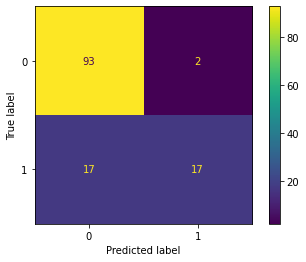

All metric scores:
 -  Accuracy :  0.8527131782945736
 -  Precision :  0.8947368421052632
 -  Recall :  0.5
 -  F1 score :  0.6415094339622641
 -  F2 score :  0.5483870967741935
 -  ROC AUC :  0.7394736842105264
Training Set: 
Number ASD Development: 8
Confusion matrix:


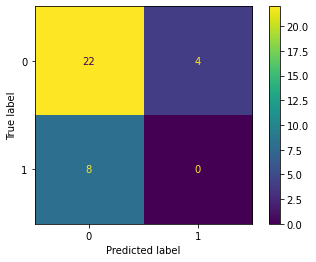

All metric scores:
 -  Accuracy :  0.6470588235294118
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4230769230769231


In [57]:
pipeline_dict_m2_test["KNN"].fit(X_train.iloc[pipeline_dict_m1_test["KNN"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["KNN"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                   iloc[pipeline_dict_m1_test["KNN"].
                                        predict(X_train) == 1]),
                   y_pred = pipeline_dict_m2_test["KNN"].predict(X_train.
                                                                 iloc[pipeline_dict_m1_test["KNN"].
                                                                      predict(X_train) == 1]),
                   to_print = True)

print("Training Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["KNN"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["KNN"].predict(X_test.
                                                                     iloc[pipeline_dict_m1_test["KNN"].
                                                                          predict(X_test) == 1]),
                       to_print = True)

In [58]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "KNN",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "KNN",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   

     recall  F1_score  F2_score   ROC_AUC  
0  0.820755  0.740426  0.786618  0.622706  
0  0.740741  0.655738  0.704225  0.481481  
0  0.500000  0.641509  0.548387  0.739474  
0  0.000000  0.000000  0.000000  0.423077  


### NB

In [59]:
var_smoothing_1 = []
var_smoothing_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["NB"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["NB"][i].best_params_)
    
    var_smoothing_1.append(param_grid_1["classifier__var_smoothing"])

    # MODEL 2
    param_grid_2 = gs_results_dict_m2["NB"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["NB"][i].best_params_)
    
    var_smoothing_2.append(param_grid_2["classifier__var_smoothing"])

M1:  {'classifier__var_smoothing': 0.0}
M2:  {'classifier__var_smoothing': 0.25}
M1:  {'classifier__var_smoothing': 0.18}
M2:  {'classifier__var_smoothing': 0.0}
M1:  {'classifier__var_smoothing': 0.0}
M2:  {'classifier__var_smoothing': 0.87}
M1:  {'classifier__var_smoothing': 0.22}
M2:  {'classifier__var_smoothing': 0.0}
M1:  {'classifier__var_smoothing': 0.01}
M2:  {'classifier__var_smoothing': 0.0}


In [60]:
# MODEL 1    
if debug:
    print("- NB Model 1 Selected parameters")
    
    print("var_smoothing: ", np.mean(var_smoothing_1))

# MODEL 1
pipeline_dict_m1_test["NB"] = pipeline_dict_m1_test["NB"].set_params(
    # real-number parameters
    classifier__var_smoothing = np.mean(var_smoothing_1)
)

- NB Model 1 Selected parameters
var_smoothing:  0.082


Number Non-Tipical Development: 106
Number Tipical Development: 73
Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


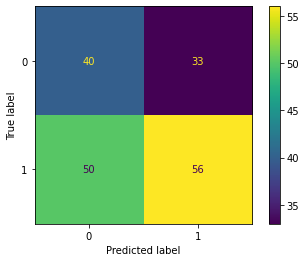

All metric scores:
 -  Accuracy :  0.5363128491620112
 -  Precision :  0.6292134831460674
 -  Recall :  0.5283018867924528
 -  F1 score :  0.5743589743589743
 -  F2 score :  0.5458089668615984
 -  ROC AUC :  0.5381235461359524
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


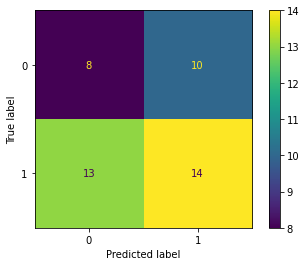

All metric scores:
 -  Accuracy :  0.4888888888888889
 -  Precision :  0.5833333333333334
 -  Recall :  0.5185185185185185
 -  F1 score :  0.5490196078431373
 -  F2 score :  0.5303030303030303
 -  ROC AUC :  0.4814814814814815


In [61]:
pipeline_dict_m1_test["NB"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["NB"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["NB"].predict(X_test),
                       to_print = True)

In [62]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "NB",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "NB",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   

     recall  F1_score  F2_score   ROC_AUC  
0  0.820755  0.740426  0.786618  0.622706  
0  0.740741  0.655738  0.704225  0.481481  
0  0.500000  0.641509  0.548387  0.739474  
0  0.000000  0.000000  0.000000  0.423077  
0  0.528302  0.574359  0.545809  0.538124  
0  0.518519  0.549020  0.530303  0.481481  


In [63]:
# MODEL 2    
if debug:
    print("- NB Model 2 Selected parameters")
    
    print("var_smoothing: ", np.mean(var_smoothing_2))

# MODEL 2
pipeline_dict_m2_test["NB"] = pipeline_dict_m2_test["NB"].set_params(
    # real-number parameters
    classifier__var_smoothing = np.mean(var_smoothing_2)
)

- NB Model 2 Selected parameters
var_smoothing:  0.22400000000000003


Number ASD Development: 17
Training Set: 
Number ASD Development: 17
Confusion matrix:


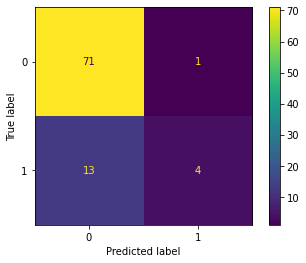

All metric scores:
 -  Accuracy :  0.8426966292134831
 -  Precision :  0.8
 -  Recall :  0.23529411764705882
 -  F1 score :  0.3636363636363636
 -  F2 score :  0.273972602739726
 -  ROC AUC :  0.610702614379085
Training Set: 
Number ASD Development: 4
Confusion matrix:


/home/laura/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


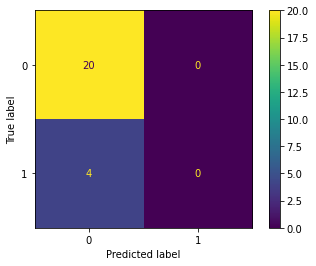

All metric scores:
 -  Accuracy :  0.8333333333333334
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5


In [64]:
pipeline_dict_m2_test["NB"].fit(X_train.iloc[pipeline_dict_m1_test["NB"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["NB"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["NB"].
                                             predict(X_train) == 1]),
                        y_pred = pipeline_dict_m2_test["NB"].predict(X_train.
                                                                     iloc[pipeline_dict_m1_test["NB"].
                                                                          predict(X_train) == 1]),
                        to_print = True)

print("Training Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["NB"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["NB"].predict(X_test.
                                                                    iloc[pipeline_dict_m1_test["NB"].
                                                                         predict(X_test) == 1]),
                       to_print = True)

In [65]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "NB",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "NB",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   

     recall  F1_score  F2_score   ROC_AUC  
0  0.820755  0.740426  0.786618  0.622706  
0  0.740741  0.655738  0.704225  0.481481  
0  0.500000  0.641509  0.548387  0.739474  
0  0.000000  0.000000  0.000000  0.423077  
0  0.528302  0.574359  0.545809  0.538124  
0  0.518519  0.549020  0.530303  

### LR

In [66]:
penalty_1 = [] 
penalty_2 = []
C_1 = []
C_2 = []
solver_1 = [] 
solver_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["LR"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["LR"][i].best_params_)
    
    penalty_1.append(param_grid_1["classifier__penalty"])
    solver_1.append(param_grid_1["classifier__solver"])
    C_1.append(param_grid_1["classifier__C"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["LR"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["LR"][i].best_params_)
    
    penalty_2.append(param_grid_2["classifier__penalty"])
    solver_2.append(param_grid_2["classifier__solver"])
    C_2.append(param_grid_2["classifier__C"])

M1:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
M2:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
M1:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
M2:  {'classifier__C': 0.0008858667904100823, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
M1:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
M2:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
M1:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
M2:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
M1:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
M2:  {'classifier__C': 0.00042813323987193956, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [67]:
# MODEL 1    
if debug:
    print("- LR Model 1 Selected parameters")
    
    print("Penalty: ", stats.mode(penalty_1).mode[0])
    print("Solver: ", stats.mode(solver_1).mode[0])
    print("C: ", np.mean(C_1))
    
# MODEL 1
pipeline_dict_m1_test["LR"] = pipeline_dict_m1_test["LR"].set_params(
    # nominal parameters
    classifier__penalty = stats.mode(penalty_1).mode[0],
    classifier__solver = stats.mode(solver_1).mode[0],
    
    # real-number parameters
    classifier__C = np.mean(C_1)
)

- LR Model 1 Selected parameters
Penalty:  l1
Solver:  saga
C:  0.0001


Number Non-Tipical Development: 106
Number Tipical Development: 73
Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


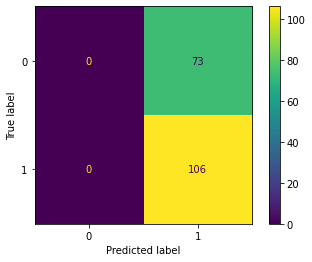

All metric scores:
 -  Accuracy :  0.5921787709497207
 -  Precision :  0.5921787709497207
 -  Recall :  1.0
 -  F1 score :  0.7438596491228071
 -  F2 score :  0.87893864013267
 -  ROC AUC :  0.5
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


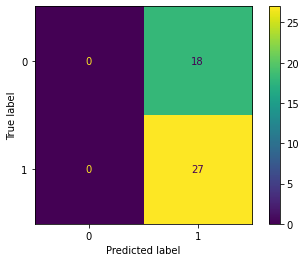

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5


In [68]:
pipeline_dict_m1_test["LR"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["LR"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["LR"].predict(X_test),
                       to_print = True)

In [69]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "LR",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "LR",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   

     recall  F1_score  F2_score   ROC_AUC  
0  0.820755  0.740426  0.786618  0.622706  
0  0.740741  0.655738  0.704225  0.481481  
0  0.5000

In [70]:
# MODEL 2   
if debug:
    print("- LR Model 2 Selected parameters")
    
    print("Penalty: ", stats.mode(penalty_2).mode[0])
    print("Solver: ", stats.mode(solver_2).mode[0])
    print("C: ", np.mean(C_2))
    
# MODEL 2
pipeline_dict_m2_test["LR"] = pipeline_dict_m2_test["LR"].set_params(
    # nominal parameters
    classifier__penalty = stats.mode(penalty_2).mode[0],
    classifier__solver = stats.mode(solver_2).mode[0],
    
    # real-number parameters
    classifier__C = np.mean(C_2)
)

- LR Model 2 Selected parameters
Penalty:  l2
Solver:  liblinear
C:  0.00032280000605640444


Number ASD Development: 42
Training Set: 
Number ASD Development: 42
Confusion matrix:


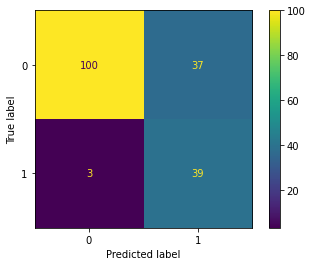

All metric scores:
 -  Accuracy :  0.776536312849162
 -  Precision :  0.5131578947368421
 -  Recall :  0.9285714285714286
 -  F1 score :  0.6610169491525424
 -  F2 score :  0.7991803278688525
 -  ROC AUC :  0.8292492179353493
Test Set: 
Number ASD Development: 11
Confusion matrix:


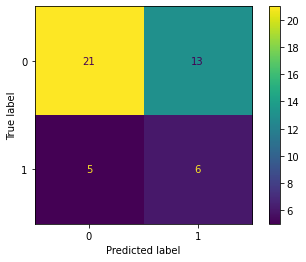

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.3157894736842105
 -  Recall :  0.5454545454545454
 -  F1 score :  0.39999999999999997
 -  F2 score :  0.47619047619047616
 -  ROC AUC :  0.5815508021390374


In [71]:
pipeline_dict_m2_test["LR"].fit(X_train.iloc[pipeline_dict_m1_test["LR"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["LR"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["LR"].
                                             predict(X_train) == 1]),
                        y_pred = pipeline_dict_m2_test["LR"].predict(X_train.
                                                                     iloc[pipeline_dict_m1_test["LR"].
                                                                          predict(X_train) == 1]),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["LR"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["LR"].predict(X_test.
                                                                    iloc[pipeline_dict_m1_test["LR"].
                                                                         predict(X_test) == 1]),
                       to_print = True)

In [72]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "LR",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "LR",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

### SVM

In [73]:
kernel_1 = []
kernel_2 = []
C_1 = []
C_2 = []
coef0_1 = []
coef0_2 = []
shrinking_1 = []
shrinking_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["SVM"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["SVM"][i].best_params_)
    
    kernel_1.append(param_grid_1["classifier__kernel"])
    shrinking_1.append(param_grid_1["classifier__shrinking"])
    coef0_1.append(param_grid_1["classifier__coef0"])
    C_1.append(param_grid_1["classifier__C"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["SVM"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["SVM"][i].best_params_)
    
    kernel_2.append(param_grid_2["classifier__kernel"])
    shrinking_2.append(param_grid_2["classifier__shrinking"])
    coef0_2.append(param_grid_2["classifier__coef0"])
    C_2.append(param_grid_2["classifier__C"])

M1:  {'classifier__C': 0.4832930238571752, 'classifier__coef0': 1, 'classifier__kernel': 'sigmoid', 'classifier__shrinking': True}
M2:  {'classifier__C': 100.0, 'classifier__coef0': 2, 'classifier__kernel': 'sigmoid', 'classifier__shrinking': True}
M1:  {'classifier__C': 0.11288378916846889, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
M2:  {'classifier__C': 1.2742749857031335, 'classifier__coef0': 1, 'classifier__kernel': 'sigmoid', 'classifier__shrinking': True}
M1:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
M2:  {'classifier__C': 23.357214690901213, 'classifier__coef0': 1, 'classifier__kernel': 'sigmoid', 'classifier__shrinking': True}
M1:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
M2:  {'classifier__C': 2.06913808111479, 'classifier__coef0': 1, 'classifier__kernel': 'sigmoid', 'classifier__shrinking': True}
M1:

In [74]:
# MODEL 1    
if debug:
    print("- SVM Model 1 Selected parameters")
    
    print("Kernel: ", stats.mode(kernel_1).mode[0])
    print("Shrinking: ", stats.mode(shrinking_1).mode[0])
    print("coef0: ", int(np.median(coef0_1)))
    print("C: ", np.mean(C_1))
    
# MODEL 1
pipeline_dict_m1_test["SVM"] = pipeline_dict_m1_test["SVM"].set_params(
    # nominal parameters
    classifier__kernel = stats.mode(kernel_1).mode[0],
    classifier__shrinking = stats.mode(shrinking_1).mode[0],
    
    # integer parameters
    classifier__coef0 = int(np.median(coef0_1)),
    
    # real-number parameters
    classifier__C = np.mean(C_1)
)

- SVM Model 1 Selected parameters
Kernel:  poly
Shrinking:  True
coef0:  1
C:  0.12523536260512882


Number Non-Tipical Development: 106
Number Tipical Development: 73
Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


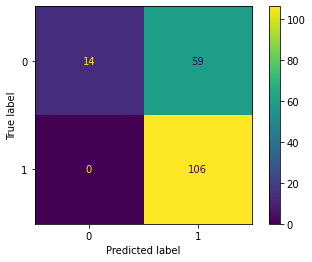

All metric scores:
 -  Accuracy :  0.6703910614525139
 -  Precision :  0.6424242424242425
 -  Recall :  1.0
 -  F1 score :  0.7822878228782287
 -  F2 score :  0.8998302207130731
 -  ROC AUC :  0.595890410958904
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


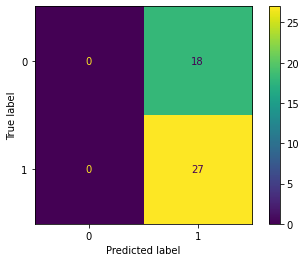

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5


In [75]:
pipeline_dict_m1_test["SVM"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["SVM"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["SVM"].predict(X_test),
                       to_print = True)

In [76]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "SVM",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "SVM",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

In [77]:
# MODEL 2   
if debug:
    print("- SVM Model 2 Selected parameters")
    
    print("Kernel: ", stats.mode(kernel_2).mode[0])
    print("Shrinking: ", stats.mode(shrinking_2).mode[0])
    print("coef0: ", stats.mode(solver_2).mode[0])
    print("C: ", np.mean(C_2))
    
# MODEL 2
pipeline_dict_m2_test["SVM"] = pipeline_dict_m2_test["SVM"].set_params(
    # nominal parameters
    classifier__kernel = stats.mode(kernel_2).mode[0],
    classifier__shrinking = stats.mode(shrinking_2).mode[0],
    
    # integer parameters
    classifier__coef0 = int(np.median(coef0_2)),
    
    # real-number parameters
    classifier__C = np.mean(C_2)
)

- SVM Model 2 Selected parameters
Kernel:  sigmoid
Shrinking:  True
coef0:  liblinear
C:  45.34012555154383


Number ASD Development: 42
Training Set: 
Number ASD Development: 42
Confusion matrix:


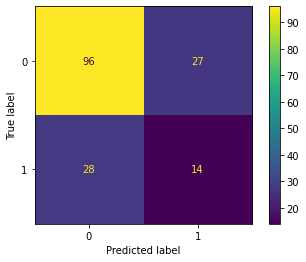

All metric scores:
 -  Accuracy :  0.6666666666666666
 -  Precision :  0.34146341463414637
 -  Recall :  0.3333333333333333
 -  F1 score :  0.3373493975903615
 -  F2 score :  0.33492822966507174
 -  ROC AUC :  0.556910569105691
Test Set: 
Number ASD Development: 11
Confusion matrix:


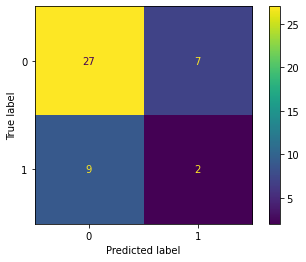

All metric scores:
 -  Accuracy :  0.6444444444444445
 -  Precision :  0.2222222222222222
 -  Recall :  0.18181818181818182
 -  F1 score :  0.19999999999999998
 -  F2 score :  0.18867924528301888
 -  ROC AUC :  0.48796791443850274


In [78]:
pipeline_dict_m2_test["SVM"].fit(X_train.iloc[pipeline_dict_m1_test["SVM"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["SVM"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["SVM"].
                                             predict(X_train) == 1]),
                        y_pred = pipeline_dict_m2_test["SVM"].predict(X_train.
                                                                     iloc[pipeline_dict_m1_test["SVM"].
                                                                          predict(X_train) == 1]),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["SVM"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["SVM"].predict(X_test.
                                                                    iloc[pipeline_dict_m1_test["SVM"].
                                                                         predict(X_test) == 1]),
                       to_print = True)

In [79]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "SVM",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "SVM",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

### MLP

In [80]:
hidden_layer_sizes_1 = []
hidden_layer_sizes_2 = []
solver_1 = []
solver_2 = []
learning_rate_1 = []
learning_rate_2 = []
alpha_1 = []
alpha_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["MLP"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["MLP"][i].best_params_)
    
    hidden_layer_sizes_1.append(param_grid_1["classifier__hidden_layer_sizes"])
    solver_1.append(param_grid_1["classifier__solver"])
    learning_rate_1.append(param_grid_1["classifier__learning_rate"])
    alpha_1.append(param_grid_1["classifier__alpha"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["MLP"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["MLP"][i].best_params_)
    
    hidden_layer_sizes_2.append(param_grid_2["classifier__hidden_layer_sizes"])
    solver_2.append(param_grid_2["classifier__solver"])
    learning_rate_2.append(param_grid_2["classifier__learning_rate"])
    alpha_2.append(param_grid_2["classifier__alpha"])

M1:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
M2:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (10, 30, 10), 'classifier__learning_rate': 'constant', 'classifier__solver': 'lbfgs'}
M1:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
M2:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
M1:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
M2:  {'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
M1:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50,

In [81]:
# MODEL 1    
if debug:
    print("- MLP Model 1 Selected parameters")
    
    print("Hidden layer sizes: ", stats.mode(hidden_layer_sizes_1).mode[0])
    print("Solver: ", stats.mode(solver_1).mode[0])
    print("Learning rate: ", stats.mode(learning_rate_1).mode[0])
    print("Alpha: ", np.mean(alpha_1))
    
# MODEL 1
pipeline_dict_m1_test["MLP"] = pipeline_dict_m1_test["MLP"].set_params(
    # nominal parameters
    classifier__hidden_layer_sizes = stats.mode(hidden_layer_sizes_1).mode[0],
    classifier__solver = stats.mode(solver_1).mode[0],
    classifier__learning_rate = stats.mode(learning_rate_1).mode[0],
    
    # real-number parameters
    classifier__alpha = np.mean(alpha_1)
)

- MLP Model 1 Selected parameters
Hidden layer sizes:  [ 50 100  50]
Solver:  sgd
Learning rate:  invscaling
Alpha:  1e-05


Number Non-Tipical Development: 106
Number Tipical Development: 73
Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


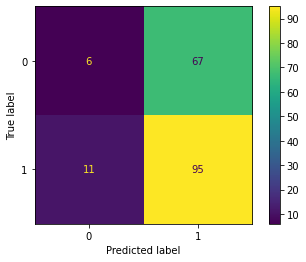

All metric scores:
 -  Accuracy :  0.5642458100558659
 -  Precision :  0.5864197530864198
 -  Recall :  0.8962264150943396
 -  F1 score :  0.708955223880597
 -  F2 score :  0.810580204778157
 -  ROC AUC :  0.4892090979581287
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


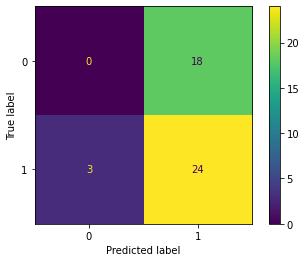

All metric scores:
 -  Accuracy :  0.5333333333333333
 -  Precision :  0.5714285714285714
 -  Recall :  0.8888888888888888
 -  F1 score :  0.6956521739130435
 -  F2 score :  0.7999999999999998
 -  ROC AUC :  0.4444444444444444


In [82]:
pipeline_dict_m1_test["MLP"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["MLP"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["MLP"].predict(X_test),
                       to_print = True)

In [83]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "MLP",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "MLP",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

In [84]:
# MODEL 2   
if debug:
    print("- MLP Model 2 Selected parameters")
    
    print("Hidden layer sizes: ", stats.mode(hidden_layer_sizes_2).mode[0])
    print("Solver: ", stats.mode(solver_2).mode[0])
    print("Learning rate: ", stats.mode(learning_rate_2).mode[0])
    print("Alpha: ", np.mean(alpha_2))
    
# MODEL 2
pipeline_dict_m2_test["MLP"] = pipeline_dict_m2_test["MLP"].set_params(
    # nominal parameters
    classifier__hidden_layer_sizes = stats.mode(hidden_layer_sizes_2).mode[0],
    classifier__solver = stats.mode(solver_2).mode[0],
    classifier__learning_rate = stats.mode(learning_rate_2).mode[0],
    
    # real-number parameters
    classifier__alpha = np.mean(alpha_2)
)

- MLP Model 2 Selected parameters
Hidden layer sizes:  [ 50 100  50]
Solver:  lbfgs
Learning rate:  constant
Alpha:  0.002984990988746275


Number ASD Development: 38
Training Set: 
Number ASD Development: 38
Confusion matrix:


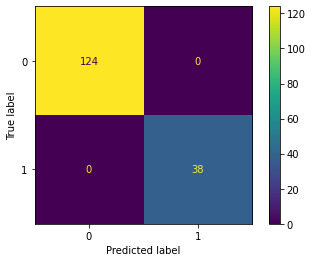

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Test Set: 
Number ASD Development: 10
Confusion matrix:


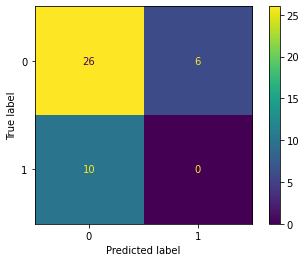

All metric scores:
 -  Accuracy :  0.6190476190476191
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.40625


In [85]:
pipeline_dict_m2_test["MLP"].fit(X_train.iloc[pipeline_dict_m1_test["MLP"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["MLP"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["MLP"].
                                             predict(X_train) == 1]),
                        y_pred = pipeline_dict_m2_test["MLP"].predict(X_train.
                                                                     iloc[pipeline_dict_m1_test["MLP"].
                                                                          predict(X_train) == 1]),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["MLP"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["MLP"].predict(X_test.
                                                                    iloc[pipeline_dict_m1_test["MLP"].
                                                                         predict(X_test) == 1]),
                       to_print = True)

In [86]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "MLP",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "MLP",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

### RF

In [87]:
n_estimators_1 = []
n_estimators_2 = []
max_depth_1 = []
max_depth_2 = []

min_samples_split_1 = []
min_samples_split_2 = []
min_samples_leaf_1 = []
min_samples_leaf_2 = []
criterion_1 = []
criterion_2 = []
max_features_1 = []
max_features_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["RF-1"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["RF-1"][i].best_params_)
    
    n_estimators_1.append(param_grid_1["classifier__n_estimators"])
    max_depth_1.append(param_grid_1["classifier__max_depth"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["RF-1"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["RF-1"][i].best_params_)
    
    n_estimators_2.append(param_grid_2["classifier__n_estimators"])
    max_depth_2.append(param_grid_2["classifier__max_depth"])
    
    ######
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["RF-2"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["RF-2"][i].best_params_)
    
    min_samples_split_1.append(param_grid_1["classifier__min_samples_split"])
    min_samples_leaf_1.append(param_grid_1["classifier__min_samples_leaf"])
    criterion_1.append(param_grid_1["classifier__criterion"])
    max_features_1.append(param_grid_1["classifier__max_features"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["RF-2"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["RF-2"][i].best_params_)
    
    min_samples_split_2.append(param_grid_2["classifier__min_samples_split"])
    min_samples_leaf_2.append(param_grid_2["classifier__min_samples_leaf"])
    criterion_2.append(param_grid_2["classifier__criterion"])
    max_features_2.append(param_grid_2["classifier__max_features"])

M1:  {'classifier__max_depth': 1, 'classifier__n_estimators': 120}
M2:  {'classifier__max_depth': 50, 'classifier__n_estimators': 1}
M1:  {'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 30, 'classifier__min_samples_split': 5}
M2:  {'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
M1:  {'classifier__max_depth': 1, 'classifier__n_estimators': 360}
M2:  {'classifier__max_depth': 45, 'classifier__n_estimators': 1}
M1:  {'classifier__criterion': 'gini', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20}
M2:  {'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 15}
M1:  {'classifier__max_depth': 1, 'classifier__n_estimators': 120}
M2:  {'classifier__max_depth': 30, 'classifier__n_estimators': 1}
M1:  {'cla

In [88]:
# MODEL 1    
if debug:
    print("- RF Model 1 Selected parameters")
    
    print("criterion: ", stats.mode(criterion_1).mode[0])
    print("max_features: ", stats.mode(max_features_1).mode[0])
    
    print("n_estimators: ", int(np.median(n_estimators_1)))
    print("max_depth: ", int(np.median(max_depth_1)))
    print("min_samples_split: ", int(np.median(min_samples_split_1)))
    print("min_samples_leaf: ", int(np.median(min_samples_leaf_1)))
    
# MODEL 1
pipeline_dict_m1_test["RF-2"] = pipeline_dict_m1_test["RF-2"].set_params(
    # nominal parameters
    classifier__criterion = stats.mode(criterion_1).mode[0],
    classifier__max_features = stats.mode(max_features_1).mode[0],
    
    # integer parameters
    classifier__n_estimators = int(np.median(n_estimators_1)),
    classifier__max_depth = int(np.median(max_depth_1)),
    classifier__min_samples_split = int(np.median(min_samples_split_1)),
    classifier__min_samples_leaf = int(np.median(min_samples_leaf_1))
)

- RF Model 1 Selected parameters
criterion:  gini
max_features:  sqrt
n_estimators:  120
max_depth:  1
min_samples_split:  20
min_samples_leaf:  20


Number Non-Tipical Development: 106
Number Tipical Development: 73
Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


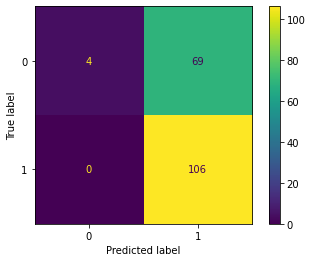

All metric scores:
 -  Accuracy :  0.6145251396648045
 -  Precision :  0.6057142857142858
 -  Recall :  1.0
 -  F1 score :  0.7544483985765125
 -  F2 score :  0.8848080133555927
 -  ROC AUC :  0.5273972602739726
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


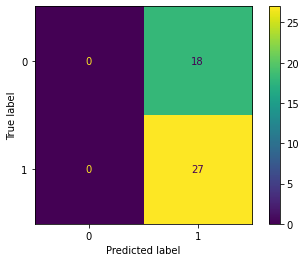

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5


In [89]:
pipeline_dict_m1_test["RF-2"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["RF-2"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["RF-2"].predict(X_test),
                       to_print = True)

In [90]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "RF",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "RF",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

In [91]:
# MODEL 2
if debug:
    print("- RF Model 2 Selected parameters")
    
    print("criterion: ", stats.mode(criterion_2).mode[0])
    print("max_features: ", stats.mode(max_features_2).mode[0])
    
    print("n_estimators: ", int(np.median(n_estimators_2)))
    print("max_depth: ", int(np.median(max_depth_2)))
    print("min_samples_split: ", int(np.median(min_samples_split_2)))
    print("min_samples_leaf: ", int(np.median(min_samples_leaf_2)))
    
# MODEL 2
pipeline_dict_m2_test["RF-2"] = pipeline_dict_m2_test["RF-2"].set_params(
    # nominal parameters
    classifier__criterion = stats.mode(criterion_2).mode[0],
    classifier__max_features = stats.mode(max_features_2).mode[0],
    
    # integer parameters
    classifier__n_estimators = int(np.median(n_estimators_2)),
    classifier__max_depth = int(np.median(max_depth_2)),
    classifier__min_samples_split = int(np.median(min_samples_split_2)),
    classifier__min_samples_leaf = int(np.median(min_samples_leaf_2))
)

- RF Model 2 Selected parameters
criterion:  gini
max_features:  sqrt
n_estimators:  1
max_depth:  30
min_samples_split:  5
min_samples_leaf:  1


Number ASD Development: 42
Training Set: 
Number ASD Development: 42
Confusion matrix:


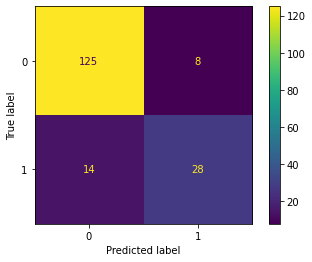

All metric scores:
 -  Accuracy :  0.8742857142857143
 -  Precision :  0.7777777777777778
 -  Recall :  0.6666666666666666
 -  F1 score :  0.717948717948718
 -  F2 score :  0.6862745098039216
 -  ROC AUC :  0.8032581453634084
Test Set: 
Number ASD Development: 11
Confusion matrix:


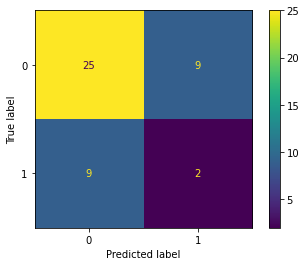

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.18181818181818182
 -  Recall :  0.18181818181818182
 -  F1 score :  0.18181818181818182
 -  F2 score :  0.18181818181818185
 -  ROC AUC :  0.4585561497326204


In [92]:
pipeline_dict_m2_test["RF-2"].fit(X_train.iloc[pipeline_dict_m1_test["RF-2"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["RF-2"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["RF-2"].
                                             predict(X_train) == 1]),
                        y_pred = pipeline_dict_m2_test["RF-2"].predict(X_train.
                                                                     iloc[pipeline_dict_m1_test["RF-2"].
                                                                          predict(X_train) == 1]),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["RF-2"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["RF-2"].predict(X_test.
                                                                    iloc[pipeline_dict_m1_test["RF-2"].
                                                                         predict(X_test) == 1]),
                       to_print = True)

In [93]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "RF",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "RF",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

### XGB

In [94]:
n_estimators_1 = []
n_estimators_2 = []
max_depth_1 = []
max_depth_2 = []

min_child_weight_1 = []
min_child_weight_2 = []
gamma_1 = []
gamma_2 = []

subsample_1 = []
subsample_2 = []
colsample_bytree_1 = []
colsample_bytree_2 = []

objective_1 = []
objective_2 = []
learning_rate_1 = []
learning_rate_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["XGB-1"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["XGB-1"][i].best_params_)
    
    n_estimators_1.append(param_grid_1["classifier__n_estimators"])
    max_depth_1.append(param_grid_1["classifier__max_depth"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["XGB-1"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["XGB-1"][i].best_params_)
    
    n_estimators_2.append(param_grid_2["classifier__n_estimators"])
    max_depth_2.append(param_grid_2["classifier__max_depth"])
    
    ######
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["XGB-2"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["XGB-2"][i].best_params_)
    
    min_child_weight_1.append(param_grid_1["classifier__min_child_weight"])
    gamma_1.append(param_grid_1["classifier__gamma"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["XGB-2"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["XGB-2"][i].best_params_)
    
    min_child_weight_2.append(param_grid_2["classifier__min_child_weight"])
    gamma_2.append(param_grid_2["classifier__gamma"])
           
    ######
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["XGB-3"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["XGB-3"][i].best_params_)
    
    subsample_1.append(param_grid_1["classifier__subsample"])
    colsample_bytree_1.append(param_grid_1["classifier__colsample_bytree"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["XGB-3"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["XGB-3"][i].best_params_)
    
    subsample_2.append(param_grid_2["classifier__subsample"])
    colsample_bytree_2.append(param_grid_2["classifier__colsample_bytree"])
                  
    ######
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["XGB-4"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["XGB-4"][i].best_params_)
    
    objective_1.append(param_grid_1["classifier__objective"])
    learning_rate_1.append(param_grid_1["classifier__learning_rate"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["XGB-4"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["XGB-4"][i].best_params_)
    
    objective_2.append(param_grid_2["classifier__objective"])
    learning_rate_2.append(param_grid_2["classifier__learning_rate"])


M1:  {'classifier__max_depth': 3, 'classifier__n_estimators': 51}
M2:  {'classifier__max_depth': 3, 'classifier__n_estimators': 11}
M1:  {'classifier__gamma': 0.54, 'classifier__min_child_weight': 3}
M2:  {'classifier__gamma': 0.0, 'classifier__min_child_weight': 1}
M1:  {'classifier__colsample_bytree': 0.0, 'classifier__subsample': 0.041666666666666664}
M2:  {'classifier__colsample_bytree': 0.9583333333333333, 'classifier__subsample': 0.20833333333333331}
M1:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
M2:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
M1:  {'classifier__max_depth': 2, 'classifier__n_estimators': 41}
M2:  {'classifier__max_depth': 1, 'classifier__n_estimators': 46}
M1:  {'classifier__gamma': 0.0, 'classifier__min_child_weight': 2}
M2:  {'classifier__gamma': 0.18, 'classifier__min_child_weight': 1}
M1:  {'classifier__colsample_bytree': 0.4583333333333333, 'classifier__subsample': 0.9166666666666666}
M2:

In [95]:
# MODEL 1    
if debug:
    print("- XGB Model 1 Selected parameters")
    
    print("objective: ", stats.mode(objective_1).mode[0])
    
    print("n_estimators: ", int(np.median(n_estimators_1)))
    print("max_depth: ", int(np.median(max_depth_1)))
    print("min_child_weight: ", int(np.median(min_child_weight_1)))
    
    print("gamma: ", np.mean(gamma_1))
    print("subsample: ", np.mean(subsample_1))
    print("colsample_bytree: ", np.mean(colsample_bytree_1))
    print("learning_rate: ", np.mean(learning_rate_1))
    
# MODEL 1
pipeline_dict_m1_test["XGB-4"] = pipeline_dict_m1_test["XGB-4"].set_params(
    # nominal parameters
    classifier__objective = stats.mode(objective_1).mode[0],
    
    # integer parameters
    classifier__n_estimators = int(np.median(n_estimators_1)),
    classifier__max_depth = int(np.median(max_depth_1)),
    classifier__min_child_weight = int(np.median(min_child_weight_1)),
    
    # real-number parameters
    classifier__gamma = np.mean(gamma_1),
    classifier__subsample = np.mean(subsample_1),
    classifier__colsample_bytree = np.mean(colsample_bytree_1),
    classifier__learning_rate = np.mean(learning_rate_1)
)

- XGB Model 1 Selected parameters
objective:  binary:hinge
n_estimators:  41
max_depth:  3
min_child_weight:  2
gamma:  0.35200000000000004
subsample:  0.6833333333333332
colsample_bytree:  0.325
learning_rate:  0.005


Number Non-Tipical Development: 106
Number Tipical Development: 73


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:01:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


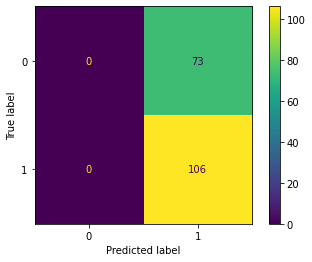

All metric scores:
 -  Accuracy :  0.5921787709497207
 -  Precision :  0.5921787709497207
 -  Recall :  1.0
 -  F1 score :  0.7438596491228071
 -  F2 score :  0.87893864013267
 -  ROC AUC :  0.5
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


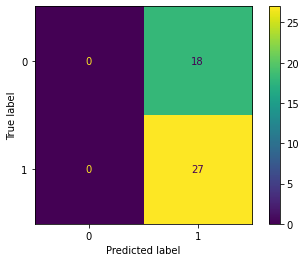

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5


In [96]:
pipeline_dict_m1_test["XGB-4"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["XGB-4"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["XGB-4"].predict(X_test),
                       to_print = True)

In [97]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "XGB",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "XGB",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

In [98]:
# MODEL 2
if debug:
    print("- XGB Model 2 Selected parameters")
    
    print("objective: ", stats.mode(objective_2).mode[0])
    
    print("n_estimators: ", int(np.median(n_estimators_2)))
    print("max_depth: ", int(np.median(max_depth_2)))
    print("min_child_weight: ", int(np.median(min_child_weight_2)))
    
    print("gamma: ", np.mean(gamma_2))
    print("subsample: ", np.mean(subsample_2))
    print("colsample_bytree: ", np.mean(colsample_bytree_2))
    print("learning_rate: ", np.mean(learning_rate_2))
    
# MODEL 2
pipeline_dict_m2_test["XGB-4"] = pipeline_dict_m2_test["XGB-4"].set_params(
    # nominal parameters
    classifier__objective = stats.mode(objective_2).mode[0],
    
    # integer parameters
    classifier__n_estimators = int(np.median(n_estimators_2)),
    classifier__max_depth = int(np.median(max_depth_2)),
    classifier__min_child_weight = int(np.median(min_child_weight_2)),
    
    # real-number parameters
    classifier__gamma = np.mean(gamma_2),
    classifier__subsample = np.mean(subsample_2),
    classifier__colsample_bytree = np.mean(colsample_bytree_2),
    classifier__learning_rate = np.mean(learning_rate_2)
)

- XGB Model 2 Selected parameters
objective:  binary:hinge
n_estimators:  41
max_depth:  2
min_child_weight:  1
gamma:  0.138
subsample:  0.20833333333333331
colsample_bytree:  0.55
learning_rate:  0.005


Number ASD Development: 42


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:01:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Number ASD Development: 42
Confusion matrix:


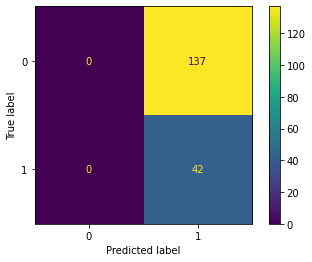

All metric scores:
 -  Accuracy :  0.2346368715083799
 -  Precision :  0.2346368715083799
 -  Recall :  1.0
 -  F1 score :  0.38009049773755654
 -  F2 score :  0.6051873198847263
 -  ROC AUC :  0.5
Test Set: 
Number ASD Development: 11
Confusion matrix:


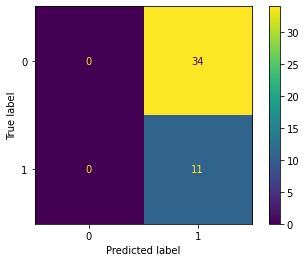

All metric scores:
 -  Accuracy :  0.24444444444444444
 -  Precision :  0.24444444444444444
 -  Recall :  1.0
 -  F1 score :  0.39285714285714285
 -  F2 score :  0.6179775280898876
 -  ROC AUC :  0.5


In [99]:
pipeline_dict_m2_test["XGB-4"].fit(X_train.iloc[pipeline_dict_m1_test["XGB-4"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["XGB-4"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["XGB-4"].
                                             predict(X_train) == 1]),
                        y_pred = pipeline_dict_m2_test["XGB-4"].predict(X_train.
                                                                     iloc[pipeline_dict_m1_test["XGB-4"].
                                                                          predict(X_train) == 1]),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["XGB-4"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["XGB-4"].predict(X_test.
                                                                    iloc[pipeline_dict_m1_test["XGB-4"].
                                                                         predict(X_test) == 1]),
                       to_print = True)

In [100]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "XGB",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "XGB",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

### LGBM

In [101]:
boosting_type_1 = []
boosting_type_2 = []
feature_fraction_1 = []
feature_fraction_2 = []

learning_rate_1 = []
learning_rate_2 = []
subsample_1 = []
subsample_2 = []

for i in range(K):
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["LGBM-1"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["LGBM-1"][i].best_params_)
    
    boosting_type_1.append(param_grid_1["classifier__boosting_type"])
    feature_fraction_1.append(param_grid_1["classifier__feature_fraction"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["LGBM-1"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["LGBM-1"][i].best_params_)
    
    boosting_type_2.append(param_grid_2["classifier__boosting_type"])
    feature_fraction_2.append(param_grid_2["classifier__feature_fraction"])
    
    ######
    
    # MODEL 1
    param_grid_1 = gs_results_dict_m1["LGBM-2"][i].best_params_
    
    if debug:
        print("M1: ", gs_results_dict_m1["LGBM-2"][i].best_params_)
    
    learning_rate_1.append(param_grid_1["classifier__learning_rate"])
    subsample_1.append(param_grid_1["classifier__subsample"])
    
    # MODEL 2
    param_grid_2 = gs_results_dict_m2["LGBM-2"][i].best_params_
    
    if debug:
        print("M2: ", gs_results_dict_m2["LGBM-2"][i].best_params_)
    
    learning_rate_2.append(param_grid_2["classifier__learning_rate"])
    subsample_2.append(param_grid_2["classifier__subsample"])

M1:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.1}
M2:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.95}
M1:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}
M2:  {'classifier__learning_rate': 1.0, 'classifier__subsample': 0.05}
M1:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.05}
M2:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.05}
M1:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}
M2:  {'classifier__learning_rate': 0.13894954943731375, 'classifier__subsample': 0.05}
M1:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.1}
M2:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.9}
M1:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}
M2:  {'classifier__learning_rate': 1.0, 'classifier__subsample': 0.05}
M1:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.15}

In [102]:
# MODEL 1    
if debug:
    print("- LGBM Model 1 Selected parameters")
    
    print("boosting_type: ", stats.mode(boosting_type_1).mode[0])
    
    print("feature_fraction: ", np.mean(feature_fraction_1))
    print("subsample: ", np.mean(subsample_1))
    print("learning_rate: ", np.mean(learning_rate_1))
    
# MODEL 1
pipeline_dict_m1_test["LGBM-2"] = pipeline_dict_m1_test["LGBM-2"].set_params(
    # nominal parameters
    classifier__boosting_type = stats.mode(boosting_type_1).mode[0],
    
    # real-number parameters
    classifier__feature_fraction = np.mean(feature_fraction_1),
    classifier__subsample = np.mean(subsample_1),
    classifier__learning_rate = np.mean(learning_rate_1)
)

- LGBM Model 1 Selected parameters
boosting_type:  rf
feature_fraction:  0.09
subsample:  0.05
learning_rate:  0.0001


Number Non-Tipical Development: 106
Number Tipical Development: 73
Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


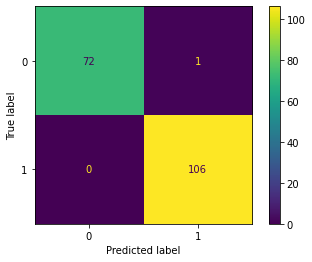

All metric scores:
 -  Accuracy :  0.994413407821229
 -  Precision :  0.9906542056074766
 -  Recall :  1.0
 -  F1 score :  0.9953051643192489
 -  F2 score :  0.9981167608286253
 -  ROC AUC :  0.9931506849315068
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


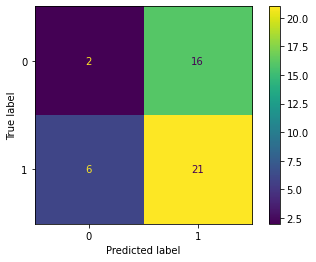

All metric scores:
 -  Accuracy :  0.5111111111111111
 -  Precision :  0.5675675675675675
 -  Recall :  0.7777777777777778
 -  F1 score :  0.65625
 -  F2 score :  0.7241379310344829
 -  ROC AUC :  0.4444444444444445


In [103]:
pipeline_dict_m1_test["LGBM-2"].fit(X_train, is_TD(y_train))

print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = pipeline_dict_m1_test["LGBM-2"].predict(X_train),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = pipeline_dict_m1_test["LGBM-2"].predict(X_test),
                       to_print = True)

In [104]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "LGBM",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "LGBM",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

In [105]:
# MODEL 2 
if debug:
    print("- LGBM Model 2 Selected parameters")
    
    print("boosting_type: ", stats.mode(boosting_type_2).mode[0])
    
    print("feature_fraction: ", np.mean(feature_fraction_2))
    print("subsample: ", np.mean(subsample_2))
    print("learning_rate: ", np.mean(learning_rate_2))
    
# MODEL 2
pipeline_dict_m2_test["LGBM-2"] = pipeline_dict_m2_test["LGBM-2"].set_params(
    # nominal parameters
    classifier__boosting_type = stats.mode(boosting_type_2).mode[0],
    
    # real-number parameters
    classifier__feature_fraction = np.mean(feature_fraction_2),
    classifier__subsample = np.mean(subsample_2),
    classifier__learning_rate = np.mean(learning_rate_2)
)

- LGBM Model 2 Selected parameters
boosting_type:  rf
feature_fraction:  0.58
subsample:  0.05
learning_rate:  0.8277899098874627


Number ASD Development: 42
Training Set: 
Number ASD Development: 42
Confusion matrix:


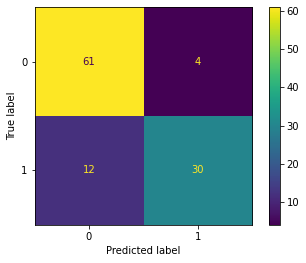

All metric scores:
 -  Accuracy :  0.8504672897196262
 -  Precision :  0.8823529411764706
 -  Recall :  0.7142857142857143
 -  F1 score :  0.7894736842105262
 -  F2 score :  0.7425742574257427
 -  ROC AUC :  0.8263736263736264
Test Set: 
Number ASD Development: 8
Confusion matrix:


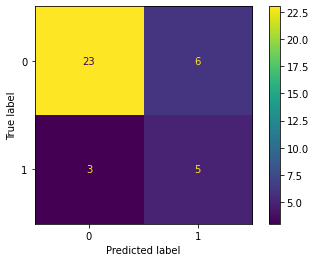

All metric scores:
 -  Accuracy :  0.7567567567567568
 -  Precision :  0.45454545454545453
 -  Recall :  0.625
 -  F1 score :  0.5263157894736842
 -  F2 score :  0.5813953488372092
 -  ROC AUC :  0.709051724137931


In [106]:
pipeline_dict_m2_test["LGBM-2"].fit(X_train.iloc[pipeline_dict_m1_test["LGBM-2"].
                                              predict(X_train) == 1],
                                 is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["LGBM-2"].
                                             predict(X_train) == 1]))

print("Training Set: ")
train_temp = all_scores(y_true = is_ASD(pd.Series(y_train).
                                        iloc[pipeline_dict_m1_test["LGBM-2"].
                                             predict(X_train) == 1]),
                        y_pred = pipeline_dict_m2_test["LGBM-2"].predict(X_train.
                                                                     iloc[pipeline_dict_m1_test["LGBM-2"].
                                                                          predict(X_train) == 1]),
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_ASD(pd.Series(y_test).
                                       iloc[pipeline_dict_m1_test["LGBM-2"].
                                            predict(X_test) == 1]),
                       y_pred = pipeline_dict_m2_test["LGBM-2"].predict(X_test.
                                                                    iloc[pipeline_dict_m1_test["LGBM-2"].
                                                                         predict(X_test) == 1]),
                       to_print = True)

In [107]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "LGBM",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "LGBM",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

  classifier dataframe    model      confusion_matrix  accuracy  precision  \
0        KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   0.674419   
0        KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   0.588235   
0        KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   0.894737   
0        KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   0.000000   
0         NB     train  model_1  [[40, 33], [50, 56]]  0.536313   0.629213   
0         NB      test  model_1   [[8, 10], [13, 14]]  0.488889   0.583333   
0         NB     train  model_2    [[71, 1], [13, 4]]  0.842697   0.800000   
0         NB      test  model_2     [[20, 0], [4, 0]]  0.833333   0.000000   
0         LR     train  model_1   [[0, 73], [0, 106]]  0.592179   0.592179   
0         LR      test  model_1    [[0, 18], [0, 27]]  0.600000   0.600000   
0         LR     train  model_2  [[100, 37], [3, 39]]  0.776536   0.513158   
0         LR      test  model_2    [[21, 13], [5, 6]]  0.600000 

## Testing 

In [108]:
# Model 1: TD or not
est_1 = [
    ('KNN', pipeline_dict_m1_test['KNN']['classifier']),
    ('NB', pipeline_dict_m1_test['NB']['classifier']),
    ('LR', pipeline_dict_m1_test['LR']['classifier']),
    ('SVM', pipeline_dict_m1_test['SVM']['classifier']),
    ('MLP', pipeline_dict_m1_test['MLP']['classifier']),
    ('RF', pipeline_dict_m1_test['RF-2']['classifier']),
    ('XGB', pipeline_dict_m1_test['XGB-4']['classifier']),
    ('LGBM', pipeline_dict_m1_test['LGBM-2']['classifier'])
]

pipe_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('voting', VotingClassifier(estimators=est_1,
                                   voting='soft',
                                   n_jobs=-1,
                                   verbose=True))
])

In [109]:
pipe_1.fit(X_train, is_TD(y_train))

model_1_predict_train = pipe_1.predict(X_train)
model_1_predict_test = pipe_1.predict(X_test)

Number Non-Tipical Development: 106
Number Tipical Development: 73


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Number Non-Tipical Development: 106
Number Tipical Development: 73
Confusion matrix:


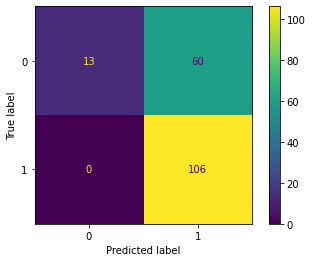

All metric scores:
 -  Accuracy :  0.664804469273743
 -  Precision :  0.6385542168674698
 -  Recall :  1.0
 -  F1 score :  0.7794117647058824
 -  F2 score :  0.8983050847457626
 -  ROC AUC :  0.589041095890411
Test Set: 
Number Non-Tipical Development: 27
Number Tipical Development: 18
Confusion matrix:


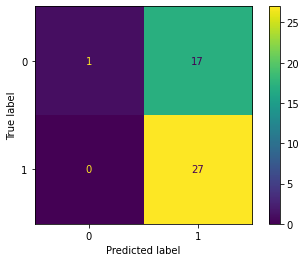

All metric scores:
 -  Accuracy :  0.6222222222222222
 -  Precision :  0.6136363636363636
 -  Recall :  1.0
 -  F1 score :  0.7605633802816901
 -  F2 score :  0.8881578947368421
 -  ROC AUC :  0.5277777777777778


In [110]:
print("Training Set: ")
train_temp = all_scores(y_true = is_TD(y_train),
                        y_pred = model_1_predict_train,
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = is_TD(y_test),
                       y_pred = model_1_predict_test,
                       to_print = True)

In [111]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "voting_ensemble",
    'dataframe': "train",
    'model': "model_1",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "voting_ensemble",
    'dataframe': "test",
    'model': "model_1",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0)

if debug:
    print(global_metrics_df)

        classifier dataframe    model      confusion_matrix  accuracy  \
0              KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   
0              KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   
0              KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   
0              KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   
0               NB     train  model_1  [[40, 33], [50, 56]]  0.536313   
0               NB      test  model_1   [[8, 10], [13, 14]]  0.488889   
0               NB     train  model_2    [[71, 1], [13, 4]]  0.842697   
0               NB      test  model_2     [[20, 0], [4, 0]]  0.833333   
0               LR     train  model_1   [[0, 73], [0, 106]]  0.592179   
0               LR      test  model_1    [[0, 18], [0, 27]]  0.600000   
0               LR     train  model_2  [[100, 37], [3, 39]]  0.776536   
0               LR      test  model_2    [[21, 13], [5, 6]]  0.600000   
0              SVM     train  model_1  [[14, 59], [

In [112]:
#model 2: ASD or not

est_2 = [
    ('KNN', pipeline_dict_m2_test['KNN']['classifier']),
    ('NB', pipeline_dict_m2_test['NB']['classifier']),
    ('LR', pipeline_dict_m2_test['LR']['classifier']),
    ('SVM', pipeline_dict_m2_test['SVM']['classifier']),
    ('MLP', pipeline_dict_m2_test['MLP']['classifier']),
    ('RF', pipeline_dict_m2_test['RF-2']['classifier']),
    ('XGB', pipeline_dict_m2_test['XGB-4']['classifier']),
    ('LGBM', pipeline_dict_m2_test['LGBM-2']['classifier'])
]

pipe_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('voting', VotingClassifier(estimators=est_2,
                                   voting='soft',
                                   n_jobs=-1,
                                   verbose=True))
])

In [113]:
X_train_m2 = X_train.iloc[model_1_predict_train == 1]
X_test_m2 = X_test.iloc[model_1_predict_test == 1]

y_train_m2 = is_ASD(pd.Series(y_train).iloc[model_1_predict_train == 1])
y_test_m2 = is_ASD(pd.Series(y_test).iloc[model_1_predict_test == 1])

Number ASD Development: 42
Number ASD Development: 11


In [114]:
pipe_2.fit(X_train_m2, y_train_m2)

model_2_prediction_train = pipe_2.predict(X_train_m2)
model_2_prediction_test = pipe_2.predict(X_test_m2)

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


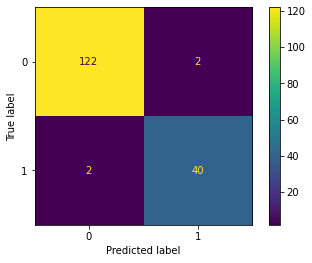

All metric scores:
 -  Accuracy :  0.9759036144578314
 -  Precision :  0.9523809523809523
 -  Recall :  0.9523809523809523
 -  F1 score :  0.9523809523809523
 -  F2 score :  0.9523809523809524
 -  ROC AUC :  0.9681259600614439
Test Set: 
Confusion matrix:


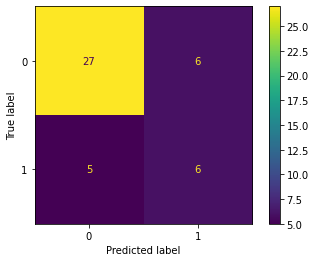

All metric scores:
 -  Accuracy :  0.75
 -  Precision :  0.5
 -  Recall :  0.5454545454545454
 -  F1 score :  0.5217391304347826
 -  F2 score :  0.5357142857142857
 -  ROC AUC :  0.6818181818181817


In [115]:
print("Training Set: ")
train_temp = all_scores(y_true = y_train_m2,
                        y_pred = model_2_prediction_train,
                        to_print = True)

print("Test Set: ")
test_temp = all_scores(y_true = y_test_m2,
                       y_pred = model_2_prediction_test,
                       to_print = True)

In [116]:
global_metrics_df = pd.concat([global_metrics_df,
    pd.DataFrame([{
    'classifier': "voting_ensemble",
    'dataframe': "train",
    'model': "model_2",
    'confusion_matrix': train_temp[0],
    'accuracy': train_temp[1],
    'precision': train_temp[2],
    'recall': train_temp[3],
    'F1_score': train_temp[4],
    'F2_score': train_temp[5],
    'ROC_AUC': train_temp[6]
}]), 
                               pd.DataFrame([{
    'classifier': "voting_ensemble",
    'dataframe': "test",
    'model': "model_2",
    'confusion_matrix': test_temp[0],
    'accuracy': test_temp[1],
    'precision': test_temp[2],
    'recall': test_temp[3],
    'F1_score': test_temp[4],
    'F2_score': test_temp[5],
    'ROC_AUC': test_temp[6]
}])], axis=0, ignore_index=True)

if debug:
    print(global_metrics_df)

         classifier dataframe    model      confusion_matrix  accuracy  \
0               KNN     train  model_1  [[31, 42], [19, 87]]  0.659218   
1               KNN      test  model_1    [[4, 14], [7, 20]]  0.533333   
2               KNN     train  model_2   [[93, 2], [17, 17]]  0.852713   
3               KNN      test  model_2     [[22, 4], [8, 0]]  0.647059   
4                NB     train  model_1  [[40, 33], [50, 56]]  0.536313   
5                NB      test  model_1   [[8, 10], [13, 14]]  0.488889   
6                NB     train  model_2    [[71, 1], [13, 4]]  0.842697   
7                NB      test  model_2     [[20, 0], [4, 0]]  0.833333   
8                LR     train  model_1   [[0, 73], [0, 106]]  0.592179   
9                LR      test  model_1    [[0, 18], [0, 27]]  0.600000   
10               LR     train  model_2  [[100, 37], [3, 39]]  0.776536   
11               LR      test  model_2    [[21, 13], [5, 6]]  0.600000   
12              SVM     train  model_1

Saving table with all metrics for all classifiers independently (including final results)

In [117]:
if(on_drive):
    file_name = '/content/drive/MyDrive/Laura Speggiorin - TCC/metrics_all_classifiers.csv'
else:
    file_name = './metrics_all_classifiers.csv'
    
global_metrics_df.to_csv(file_name)

## Plots

### Metrics plots

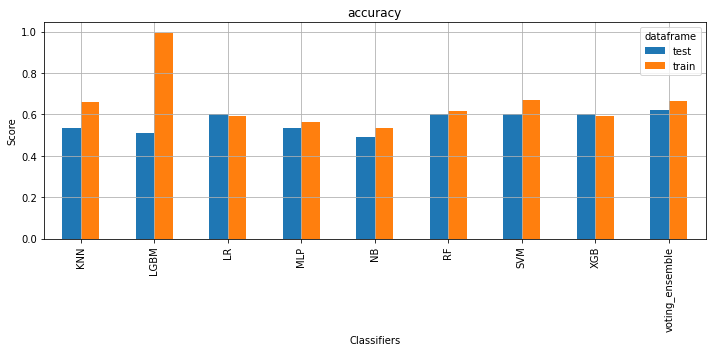

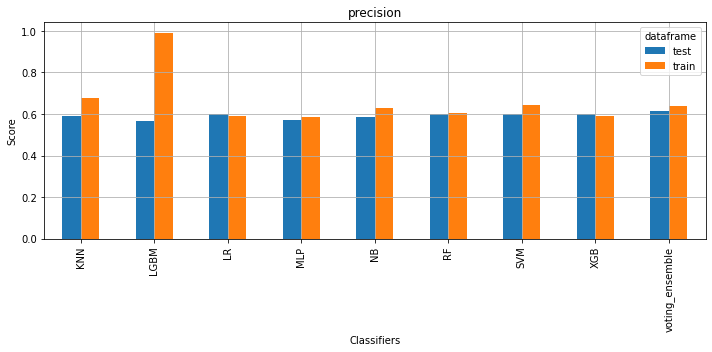

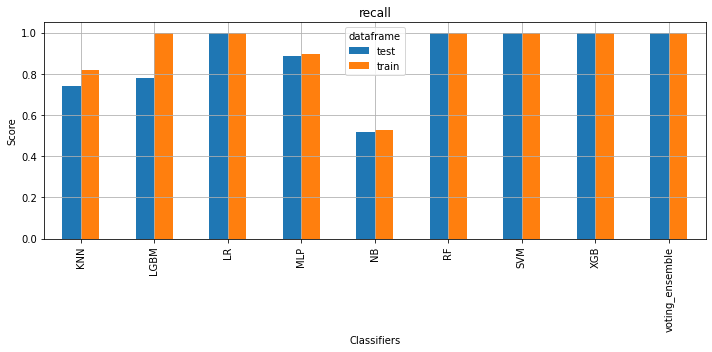

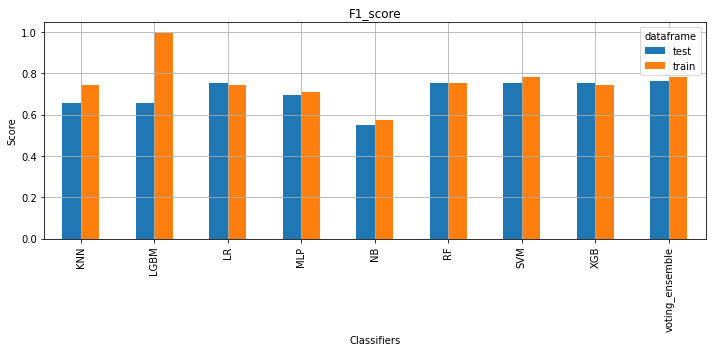

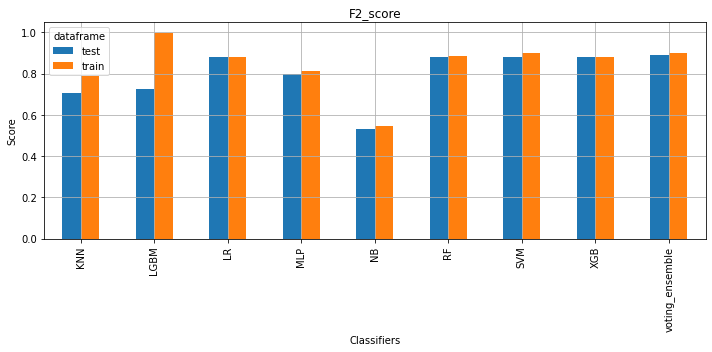

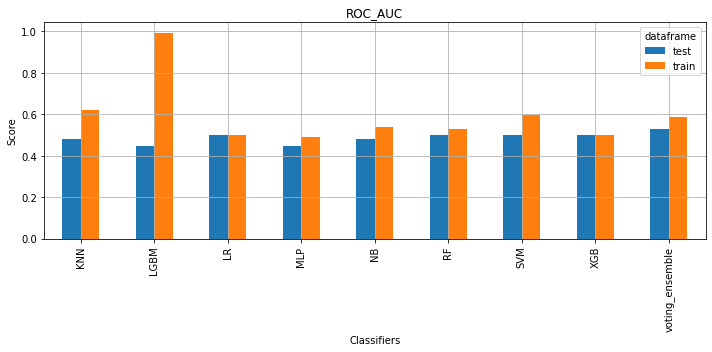

In [118]:
plot_df_m1 = global_metrics_df[global_metrics_df['model'] == 'model_1']

for i in range(4,10):
    
    metric_name = plot_df_m1.columns[i]
    
    pivot_df = plot_df_m1[['classifier', 'dataframe',metric_name]].pivot(index='classifier',
                                                                                    columns = 'dataframe',
                                                                                    values = metric_name)
    
    plot = pivot_df.plot.bar(title= metric_name,figsize=(10,5), grid=True,
                            xlabel = "Classifiers", ylabel = "Score").get_figure()
    
    plt.tight_layout()
    
    # Save figure

    if(on_drive):
        plot.savefig('./content/drive/MyDrive/Laura Speggiorin - TCC/plot_'+ metric_name +'_all_classifiers(model_1).pdf')
        plot.savefig('./content/drive/MyDrive/Laura Speggiorin - TCC/plot_'+ metric_name +'_all_classifiers(model_1).png')
    else:
        plot.savefig('./plot_'+ metric_name +'_all_classifiers(model_1).pdf')
        plot.savefig('./plot_'+ metric_name +'_all_classifiers(model_1).png')

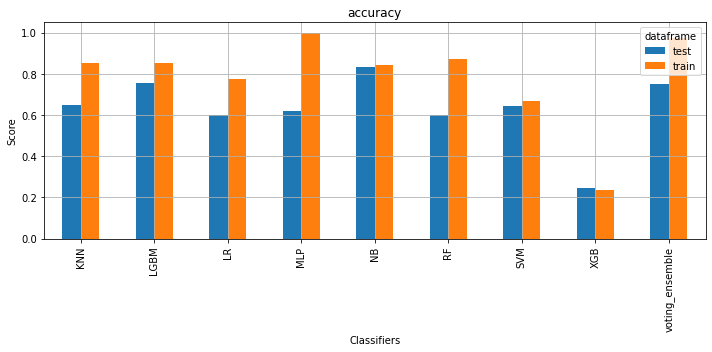

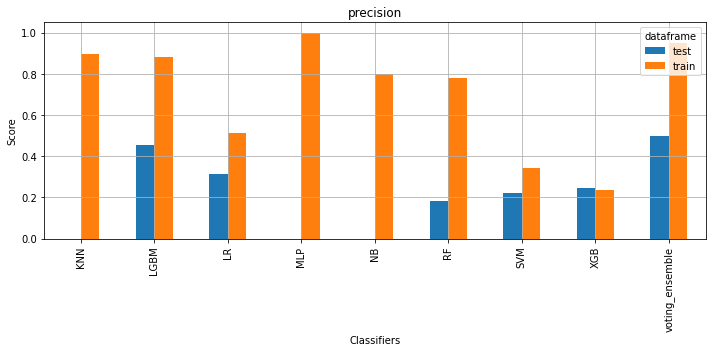

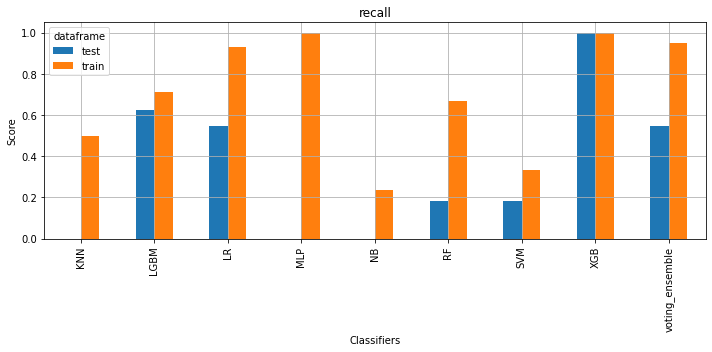

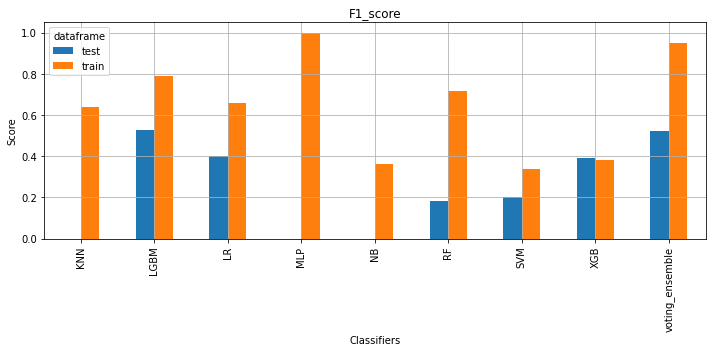

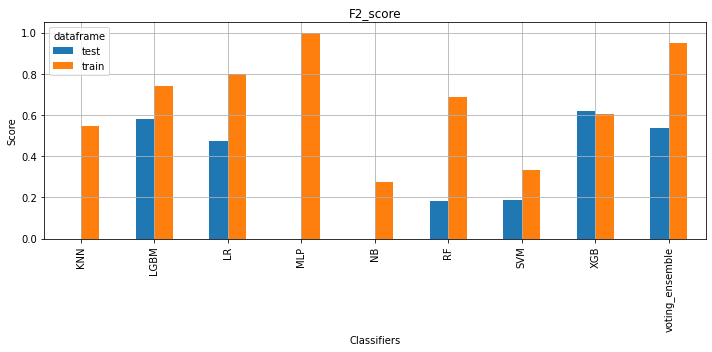

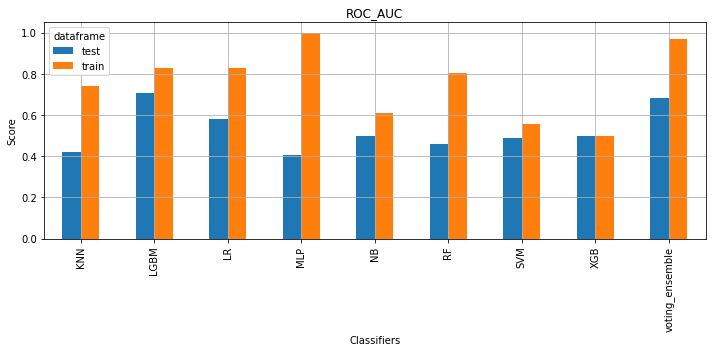

In [119]:
plot_df_m2 = global_metrics_df[global_metrics_df['model'] == 'model_2']

for i in range(4,10):
    
    metric_name = plot_df_m2.columns[i]
    
    pivot_df = plot_df_m2[['classifier', 'dataframe',metric_name]].pivot(index='classifier',
                                                                                    columns = 'dataframe',
                                                                                    values = metric_name)
    
    plot = pivot_df.plot.bar(title= metric_name, grid=True, figsize=(10,5),
                            xlabel = "Classifiers", ylabel = "Score").get_figure()
    
    plt.tight_layout()

    # Save figure


    if(on_drive):
        plot.savefig('./content/drive/MyDrive/Laura Speggiorin - TCC/plot_'+ metric_name +'_all_classifiers(model_2).png')
        plot.savefig('./content/drive/MyDrive/Laura Speggiorin - TCC/plot_'+ metric_name +'_all_classifiers(model_2).pdf')
    else:
        plot.savefig('./plot_'+ metric_name +'_all_classifiers(model_2).pdf')
        plot.savefig('./plot_'+ metric_name +'_all_classifiers(model_2).png')
        

### GridSearch plots

In [120]:
def plot_gc_score(results_dict, title, file_path):

    mean_sc = []

    metric_names = list(results_dict.keys())
    metric_names.pop(5)
    metric_names.pop(6)
    metric_names.pop(6)
    metric_names.pop(6)
    metric_names.pop(7)
        
    for i in range(K):
        line = []

        for key in metric_names:
            line.append(results_dict[key][i].best_score_)

        mean_sc.append(line)
    
    metric_names[5] = "RF"
    metric_names[6] = "XGB"
    metric_names[7] = "LGBM"
    
    gs_means = pd.DataFrame(mean_sc, columns = metric_names)
    
    gs_means_mean = gs_means.agg([np.mean, np.std])
    gs_means_mean = gs_means_mean.transpose()
    
    plot = gs_means_mean.plot(kind = "line", y = "mean", legend = True,
               title = title, xlabel = "Classifiers", ylabel = "F2-score",
               yerr = "std", marker='.').get_figure()
    
    plot.savefig(file_path)
    

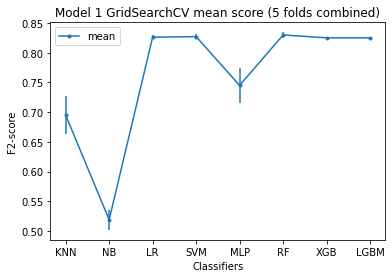

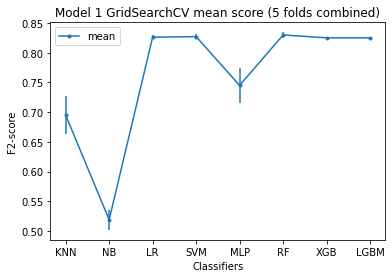

In [121]:
if(on_drive):
    filename_pdf = './content/drive/MyDrive/Laura Speggiorin - TCC/plot_gs_summary(model_1).png'
    filename_png = './content/drive/MyDrive/Laura Speggiorin - TCC/plot_gs_summary(model_1).pdf'
else:
    filename_pdf = './plot_gs_summary(model_1).pdf'
    filename_png = './plot_gs_summary(model_1).png'

plot_gc_score(gs_results_dict_m1,
              "Model 1 GridSearchCV mean score (5 folds combined)",
             filename_pdf)

plot_gc_score(gs_results_dict_m1,
              "Model 1 GridSearchCV mean score (5 folds combined)",
             filename_png)

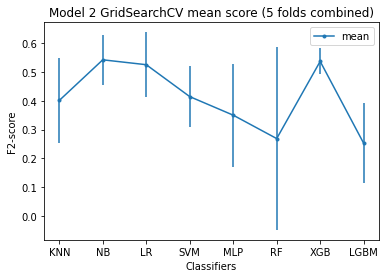

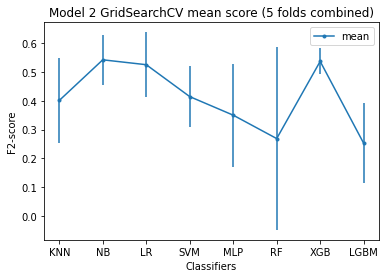

In [122]:
if(on_drive):
    filename_pdf = './content/drive/MyDrive/Laura Speggiorin - TCC/plot_gs_summary(model_2).png'
    filename_png = './content/drive/MyDrive/Laura Speggiorin - TCC/plot_gs_summary(model_2).pdf'
else:
    filename_pdf = './plot_gs_summary(model_2).pdf'
    filename_png = './plot_gs_summary(model_2).png'

plot_gc_score(gs_results_dict_m2,
              "Model 2 GridSearchCV mean score (5 folds combined)",
             filename_pdf)

plot_gc_score(gs_results_dict_m2,
              "Model 2 GridSearchCV mean score (5 folds combined)",
             filename_png)

### CV plots

In [123]:
## model 1

cv_metrics_m1_df = pd.DataFrame()

for key in model_1_cv_metrics_train[0].keys():
    
    metrics_train_dict = {}
    metrics_val_dict = {}
    
    for i in range(1,7):
        metrics_list_train = [model_1_cv_metrics_train[j][key][i] for j in range(K)]
        metric_list_val = [model_1_cv_metrics_validation[j][key][i] for j in range(K)]
        
        metrics_train_dict[model_1_cv_metrics_train[0][key].keys()[i]] = metrics_list_train
        metrics_val_dict[model_1_cv_metrics_validation[0][key].keys()[i]] = metric_list_val
    
    if key == "RF-2": key = "RF"
    if key == "XGB-4": key = "XGB"
    if key == "LGBM-2": key = "LGBM"
    
    cv_metrics_m1_df = pd.concat([cv_metrics_m1_df,
                                  pd.DataFrame([{
        'classifier': key,
        'dataframe': "train",
        'accuracy': metrics_train_dict["Accuracy"],
        'precision': metrics_train_dict["Precision"],
        'recall': metrics_train_dict["Recall"],
        'F1_score': metrics_train_dict["F1 score"],
        'F2_score': metrics_train_dict["F2 score"],
        'ROC_AUC': metrics_train_dict["ROC AUC"]
    }]),
                                  pd.DataFrame([{
        'classifier': key,
        'dataframe': "validation",
        'accuracy': metrics_val_dict["Accuracy"],
        'precision': metrics_val_dict["Precision"],
        'recall': metrics_val_dict["Recall"],
        'F1_score': metrics_val_dict["F1 score"],
        'F2_score': metrics_val_dict["F2 score"],
        'ROC_AUC': metrics_val_dict["ROC AUC"]
    }])], ignore_index = True)
    
cv_metrics_m1_df

,classifier,dataframe,accuracy,precision,recall,F1_score,F2_score,ROC_AUC
0,KNN,train,"[0.5874125874125874, 1.0, 0.6853146853146853, ...","[0.6436781609195402, 1.0, 0.6851851851851852, ...","[0.6666666666666666, 1.0, 0.8705882352941177, ...","[0.6549707602339181, 1.0, 0.766839378238342, 1...","[0.6619385342789598, 1.0, 0.8258928571428572, ...","[0.5706214689265536, 1.0, 0.6421906693711967, ..."
1,KNN,validation,"[0.5, 0.5, 0.4722222222222222, 0.5833333333333...","[0.5833333333333334, 0.56, 0.5384615384615384,...","[0.6363636363636364, 0.6666666666666666, 0.666...","[0.6086956521739131, 0.6086956521739131, 0.595...","[0.625, 0.6422018348623854, 0.6363636363636364...","[0.461038961038961, 0.4666666666666667, 0.4333..."
2,NB,train,"[0.5454545454545454, 0.6433566433566433, 0.566...","[0.6338028169014085, 0.6847826086956522, 0.653...","[0.5357142857142857, 0.7411764705882353, 0.576...","[0.5806451612903227, 0.7118644067796609, 0.612...","[0.5528255528255529, 0.7291666666666667, 0.590...","[0.5475181598062954, 0.6205882352941177, 0.564..."
3,NB,validation,"[0.4444444444444444, 0.5, 0.5555555555555556, ...","[0.5625, 0.5714285714285714, 0.647058823529411...","[0.4090909090909091, 0.5714285714285714, 0.523...","[0.47368421052631576, 0.5714285714285714, 0.57...","[0.4326923076923077, 0.5714285714285714, 0.544...","[0.4545454545454546, 0.48571428571428565, 0.56..."
4,LR,train,"[0.5874125874125874, 0.6293706293706294, 0.594...","[0.5874125874125874, 0.6159420289855072, 0.594...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.7400881057268722, 0.7623318385650223, 0.745...","[0.8768267223382046, 0.8891213389121339, 0.879...","[0.5, 0.5431034482758621, 0.5, 0.5517241379310..."
5,LR,validation,"[0.6111111111111112, 0.5833333333333334, 0.583...","[0.6111111111111112, 0.5833333333333334, 0.583...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.7586206896551725, 0.7368421052631579, 0.736...","[0.8870967741935484, 0.875, 0.875, 0.875, 0.88...","[0.5, 0.5, 0.5, 0.5, 0.5]"
6,SVM,train,"[0.5944055944055944, 0.6993006993006993, 0.594...","[0.6015625, 0.6640625, 0.5944055944055944, 0.5...","[0.9166666666666666, 1.0, 1.0, 1.0, 1.0]","[0.7264150943396227, 0.7981220657276995, 0.745...","[0.8297413793103448, 0.9081196581196581, 0.879...","[0.5261299435028248, 0.6293103448275862, 0.5, ..."
7,SVM,validation,"[0.5277777777777778, 0.5555555555555556, 0.583...","[0.5806451612903226, 0.5806451612903226, 0.583...","[0.8181818181818182, 0.8571428571428571, 1.0, ...","[0.679245283018868, 0.6923076923076923, 0.7368...","[0.7563025210084033, 0.7826086956521738, 0.875...","[0.4448051948051948, 0.49523809523809526, 0.5,..."
8,MLP,train,"[0.5664335664335665, 0.5874125874125874, 0.559...","[0.5887096774193549, 0.6, 0.5846153846153846, ...","[0.8690476190476191, 0.9176470588235294, 0.894...","[0.701923076923077, 0.7255813953488371, 0.7069...","[0.7934782608695653, 0.8297872340425533, 0.808...","[0.502320419693301, 0.5105476673427991, 0.4815..."
9,MLP,validation,"[0.4444444444444444, 0.5555555555555556, 0.611...","[0.5333333333333333, 0.5806451612903226, 0.6, ...","[0.7272727272727273, 0.8571428571428571, 1.0, ...","[0.6153846153846153, 0.6923076923076923, 0.749...","[0.6779661016949153, 0.7826086956521738, 0.882...","[0.36363636363636365, 0.49523809523809526, 0.5..."


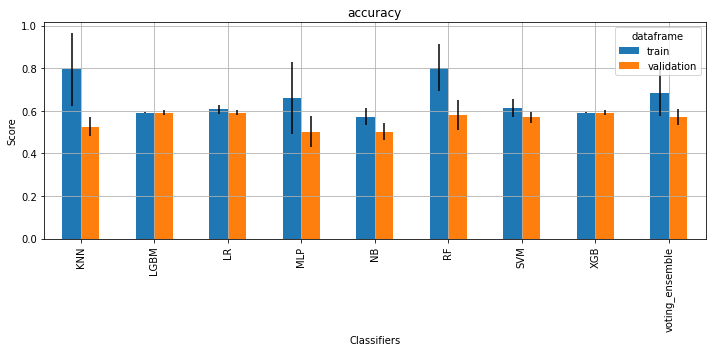

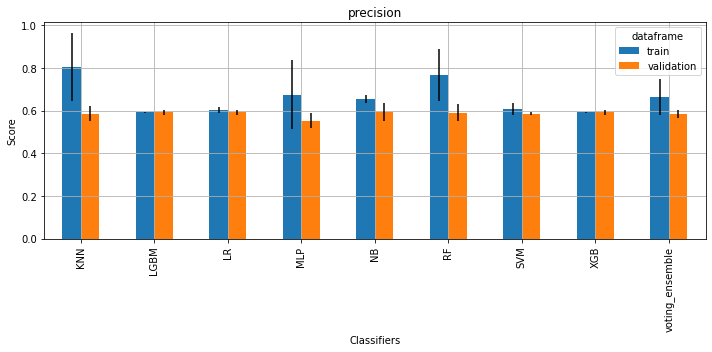

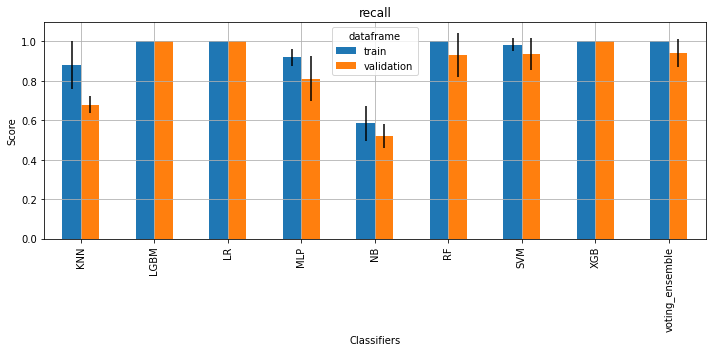

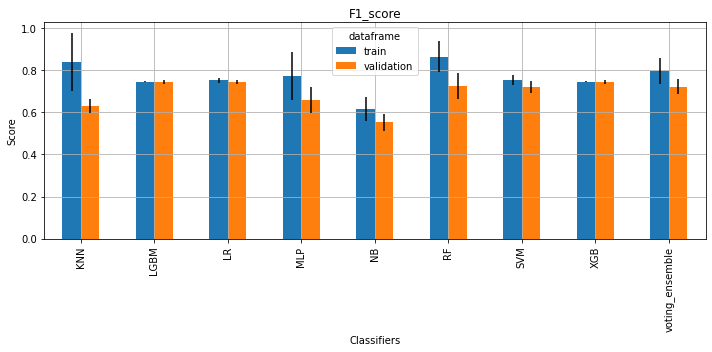

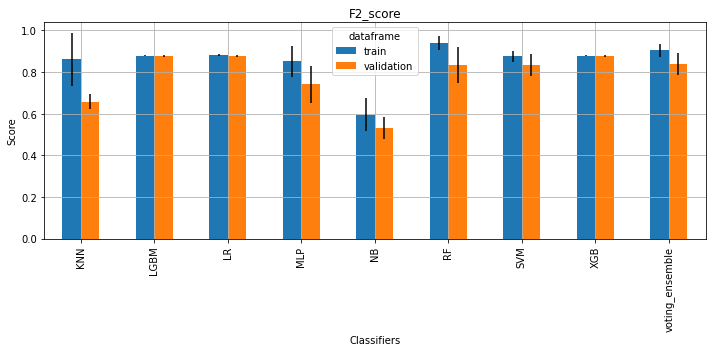

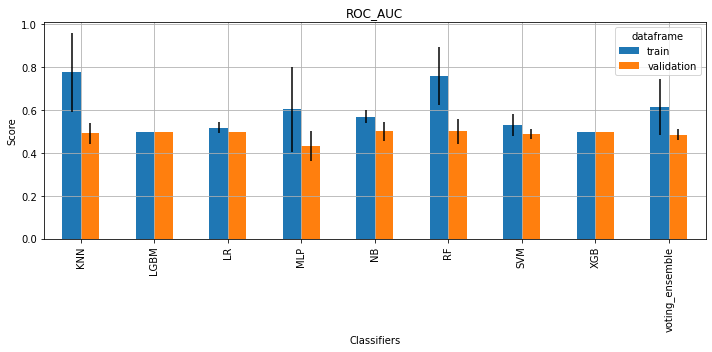

In [124]:
## model 1

cv_metrics_m1_df

for i, key in enumerate(cv_metrics_m1_df.keys()[2:]):
    
    pivot_df = pd.concat([pd.Series(cv_metrics_m1_df['classifier']), 
                          pd.Series(cv_metrics_m1_df['dataframe']), 
                          pd.Series([np.mean(cv_metrics_m1_df[key][j]) for j in range(len(cv_metrics_m1_df[key]))]),
                          pd.Series([np.std(cv_metrics_m1_df[key][j]) for j in range(len(cv_metrics_m1_df[key]))])], axis = 1)

    pivot_df.columns = ["classifier", "dataframe", "mean", "std"]
    
 
    pivot_df = pivot_df.pivot(index='classifier',columns = 'dataframe')
    
    plot = pivot_df.plot(kind = "bar", y = "mean", yerr ="std",  
                         title= key, grid=True, figsize=(10, 5),
                        xlabel = "Classifiers", ylabel = "Score").get_figure()
    
    plt.tight_layout()
    
    #Save figure
    if(on_drive):
        filepath = './content/drive/MyDrive/Laura Speggiorin - TCC/plot_cv_' + key + '_all_classifiers(model_1)'
    else:
        filepath = './plot_cv_' + key + '_all_classifiers(model_1)'
        
    plot.savefig(filepath +'.png')
    plot.savefig(filepath +'.pdf')


In [125]:
## model 2

cv_metrics_m2_df = pd.DataFrame()

for key in model_2_cv_metrics_train[0].keys():
    
    metrics_train_dict = {}
    metrics_val_dict = {}
    
    for i in range(1,7):
        metrics_list_train = [model_2_cv_metrics_train[j][key][i] for j in range(K)]
        metric_list_val = [model_2_cv_metrics_validation[j][key][i] for j in range(K)]
        
        metrics_train_dict[model_2_cv_metrics_train[0][key].keys()[i]] = metrics_list_train
        metrics_val_dict[model_2_cv_metrics_validation[0][key].keys()[i]] = metric_list_val
    
    if key == "RF-2": key = "RF"
    if key == "XGB-4": key = "XGB"
    if key == "LGBM-2": key = "LGBM"
    
    cv_metrics_m2_df = pd.concat([cv_metrics_m2_df,
                                  pd.DataFrame([{
        'classifier': key,
        'dataframe': "train",
        'accuracy': metrics_train_dict["Accuracy"],
        'precision': metrics_train_dict["Precision"],
        'recall': metrics_train_dict["Recall"],
        'F1_score': metrics_train_dict["F1 score"],
        'F2_score': metrics_train_dict["F2 score"],
        'ROC_AUC': metrics_train_dict["ROC AUC"]
    }]),
                                  pd.DataFrame([{
        'classifier': key,
        'dataframe': "validation",
        'accuracy': metrics_val_dict["Accuracy"],
        'precision': metrics_val_dict["Precision"],
        'recall': metrics_val_dict["Recall"],
        'F1_score': metrics_val_dict["F1 score"],
        'F2_score': metrics_val_dict["F2 score"],
        'ROC_AUC': metrics_val_dict["ROC AUC"]
    }])], ignore_index = True)
    
cv_metrics_m1_df

,classifier,dataframe,accuracy,precision,recall,F1_score,F2_score,ROC_AUC
0,KNN,train,"[0.5874125874125874, 1.0, 0.6853146853146853, ...","[0.6436781609195402, 1.0, 0.6851851851851852, ...","[0.6666666666666666, 1.0, 0.8705882352941177, ...","[0.6549707602339181, 1.0, 0.766839378238342, 1...","[0.6619385342789598, 1.0, 0.8258928571428572, ...","[0.5706214689265536, 1.0, 0.6421906693711967, ..."
1,KNN,validation,"[0.5, 0.5, 0.4722222222222222, 0.5833333333333...","[0.5833333333333334, 0.56, 0.5384615384615384,...","[0.6363636363636364, 0.6666666666666666, 0.666...","[0.6086956521739131, 0.6086956521739131, 0.595...","[0.625, 0.6422018348623854, 0.6363636363636364...","[0.461038961038961, 0.4666666666666667, 0.4333..."
2,NB,train,"[0.5454545454545454, 0.6433566433566433, 0.566...","[0.6338028169014085, 0.6847826086956522, 0.653...","[0.5357142857142857, 0.7411764705882353, 0.576...","[0.5806451612903227, 0.7118644067796609, 0.612...","[0.5528255528255529, 0.7291666666666667, 0.590...","[0.5475181598062954, 0.6205882352941177, 0.564..."
3,NB,validation,"[0.4444444444444444, 0.5, 0.5555555555555556, ...","[0.5625, 0.5714285714285714, 0.647058823529411...","[0.4090909090909091, 0.5714285714285714, 0.523...","[0.47368421052631576, 0.5714285714285714, 0.57...","[0.4326923076923077, 0.5714285714285714, 0.544...","[0.4545454545454546, 0.48571428571428565, 0.56..."
4,LR,train,"[0.5874125874125874, 0.6293706293706294, 0.594...","[0.5874125874125874, 0.6159420289855072, 0.594...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.7400881057268722, 0.7623318385650223, 0.745...","[0.8768267223382046, 0.8891213389121339, 0.879...","[0.5, 0.5431034482758621, 0.5, 0.5517241379310..."
5,LR,validation,"[0.6111111111111112, 0.5833333333333334, 0.583...","[0.6111111111111112, 0.5833333333333334, 0.583...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.7586206896551725, 0.7368421052631579, 0.736...","[0.8870967741935484, 0.875, 0.875, 0.875, 0.88...","[0.5, 0.5, 0.5, 0.5, 0.5]"
6,SVM,train,"[0.5944055944055944, 0.6993006993006993, 0.594...","[0.6015625, 0.6640625, 0.5944055944055944, 0.5...","[0.9166666666666666, 1.0, 1.0, 1.0, 1.0]","[0.7264150943396227, 0.7981220657276995, 0.745...","[0.8297413793103448, 0.9081196581196581, 0.879...","[0.5261299435028248, 0.6293103448275862, 0.5, ..."
7,SVM,validation,"[0.5277777777777778, 0.5555555555555556, 0.583...","[0.5806451612903226, 0.5806451612903226, 0.583...","[0.8181818181818182, 0.8571428571428571, 1.0, ...","[0.679245283018868, 0.6923076923076923, 0.7368...","[0.7563025210084033, 0.7826086956521738, 0.875...","[0.4448051948051948, 0.49523809523809526, 0.5,..."
8,MLP,train,"[0.5664335664335665, 0.5874125874125874, 0.559...","[0.5887096774193549, 0.6, 0.5846153846153846, ...","[0.8690476190476191, 0.9176470588235294, 0.894...","[0.701923076923077, 0.7255813953488371, 0.7069...","[0.7934782608695653, 0.8297872340425533, 0.808...","[0.502320419693301, 0.5105476673427991, 0.4815..."
9,MLP,validation,"[0.4444444444444444, 0.5555555555555556, 0.611...","[0.5333333333333333, 0.5806451612903226, 0.6, ...","[0.7272727272727273, 0.8571428571428571, 1.0, ...","[0.6153846153846153, 0.6923076923076923, 0.749...","[0.6779661016949153, 0.7826086956521738, 0.882...","[0.36363636363636365, 0.49523809523809526, 0.5..."


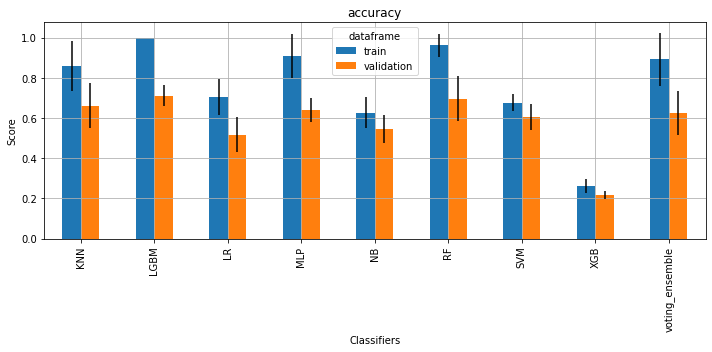

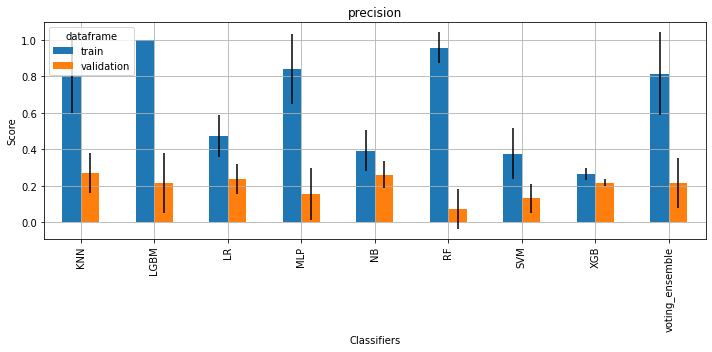

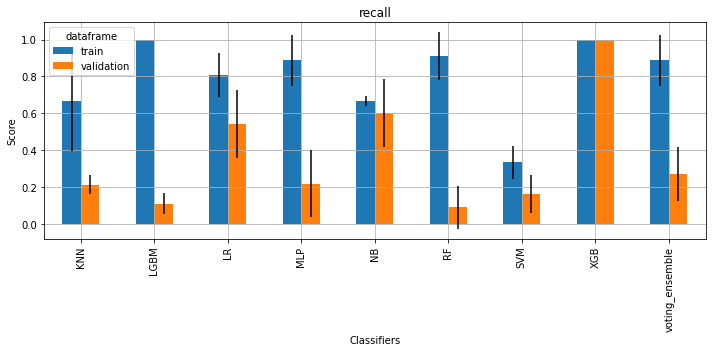

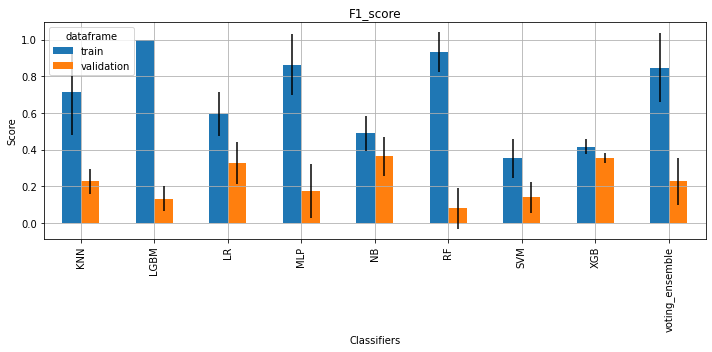

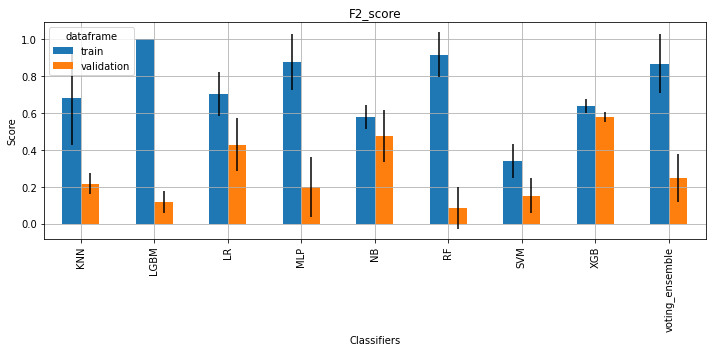

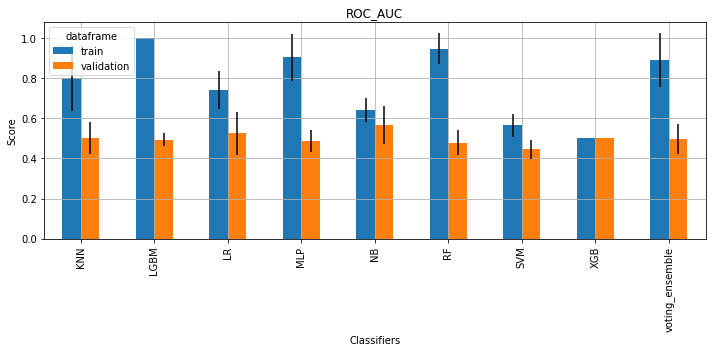

In [126]:
cv_metrics_m2_df

for i, key in enumerate(cv_metrics_m2_df.keys()[2:]):
    
    pivot_df = pd.concat([pd.Series(cv_metrics_m2_df['classifier']), 
                          pd.Series(cv_metrics_m2_df['dataframe']), 
                          pd.Series([np.mean(cv_metrics_m2_df[key][j]) for j in range(len(cv_metrics_m2_df[key]))]),
                          pd.Series([np.std(cv_metrics_m2_df[key][j]) for j in range(len(cv_metrics_m2_df[key]))])], axis = 1)

    pivot_df.columns = ["classifier", "dataframe", "mean", "std"]
    
 
    pivot_df = pivot_df.pivot(index='classifier',columns = 'dataframe')
    
    plot = pivot_df.plot(kind = "bar", y = "mean", yerr ="std",  
                         title= key, grid=True, figsize=(10, 5),
                        xlabel = "Classifiers", ylabel = "Score").get_figure()
    
    plt.tight_layout()
    
    #Save figure
    if(on_drive):
        filepath = './content/drive/MyDrive/Laura Speggiorin - TCC/plot_cv_' + key + '_all_classifiers(model_2)'
    else:
        filepath = './plot_cv_' + key + '_all_classifiers(model_2)'
        
    plot.savefig(filepath +'.png')
    plot.savefig(filepath +'.pdf')


In [127]:
df_m2 = pd.Series(y_test).iloc[model_1_predict_test == 1]
df_m2 = df_m2.reset_index(drop=True)
df_m2

0         TD
1     Non-TD
2        ASD
3     Non-TD
4        ASD
5         TD
6         TD
7         TD
8         TD
9         TD
10       ASD
11       ASD
12    Non-TD
13        TD
14       ASD
15        TD
16        TD
17    Non-TD
18    Non-TD
19    Non-TD
20    Non-TD
21        TD
22       ASD
23    Non-TD
24    Non-TD
25    Non-TD
26        TD
27       ASD
28        TD
29       ASD
30       ASD
31    Non-TD
32        TD
33        TD
34        TD
35    Non-TD
36    Non-TD
37       ASD
38    Non-TD
39        TD
40        TD
41    Non-TD
42       ASD
43    Non-TD
dtype: object

In [128]:
a = pd.concat([df_m2, pd.DataFrame(model_2_prediction_test)], axis = 1)

a.columns = ["label", "prediction"]

In [129]:
a.value_counts()

label   prediction
TD      0             15
Non-TD  0             12
ASD     1              6
        0              5
Non-TD  1              4
TD      1              2
Name: count, dtype: int64

[Voting] ....................... (3 of 8) Processing LR, total=   0.0s
[Voting] ....................... (2 of 8) Processing NB, total=   0.0s
[Voting] ...................... (1 of 8) Processing KNN, total=   0.0s
[Voting] ..................... (8 of 8) Processing LGBM, total=   0.3s
[Voting] ....................... (6 of 8) Processing RF, total=   0.3s
[Voting] ...................... (4 of 8) Processing SVM, total=   0.8s
[Voting] ...................... (5 of 8) Processing MLP, total=   1.3s
[Voting] ...................... (7 of 8) Processing XGB, total=   2.4s
[Voting] ....................... (6 of 8) Processing RF, total=   0.0s
[Voting] ...................... (1 of 8) Processing KNN, total=   0.0s
[Voting] ....................... (2 of 8) Processing NB, total=   0.0s
[Voting] ....................... (3 of 8) Processing LR, total=   0.1s
[Voting] ...................... (4 of 8) Processing SVM, total=   0.3s
[Voting] ..................... (8 of 8) Processing LGBM, total=   0.7s
[Votin